In [40]:
!nvidia-smi

Tue Dec 20 14:26:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |    882MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import chain 
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/data/extra_data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
#abnormal samples counts
#data.Class[data.Class == 1].count()
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
# convert series to narray
amount = data.Amount.to_numpy()
# reshape to make it 2D
amount = amount.reshape(-1, 1)
# normalize 
scaler = StandardScaler()
amount= scaler.fit_transform(amount)

In [ ]:
# drop columns which we don't use
data.drop(['Time', 'Amount'],axis=1, inplace=True)
# add new amount columns with normalized data
data["Amount"] = amount

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [ ]:
# determine train & test sample
x= np.array(data.drop("Class", axis= 1))
y= np.array(data["Class"])
#split train and test data: 20% of dataset is test data
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=13)
#split train and Validtion data: 20% of train set is validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(182276, 29)
(182276,)
(45569, 29)
(45569,)
(56962, 29)
(56962,)


### Oversampling

In [ ]:
sm = SMOTE(random_state=13)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
X_train_r, y_train_r = sm.fit_resample(X_train, y_train)

### Threshold

In [ ]:
def percentage_of_adding_fraud_data(x, y, percent=1):
    # y_data_fraud is 1 , y_data_normal is 0
    fraud_y_train = y[np.where(y == 1)]
    fraud_x_train = x[np.where(y == 1)]
    normal_y_train = y[np.where(y == 0)]
    normal_x_train = x[np.where(y == 0)]

    percent_add_fraud = int(len(fraud_y_train) * percent)
    scale = np.random.choice(len(fraud_y_train), percent_add_fraud, replace=False)
    fraud_x = fraud_x_train[scale]
    fraud_y = fraud_y_train[scale]
    label = np.concatenate((normal_y_train, fraud_y), axis=0)
    data = np.concatenate((normal_x_train, fraud_x), axis=0)
    return data, label

### Denoising autoencoder

#### add Gaussian noise

In [ ]:
def gaussian_noise(x):
    noise = torch.randn(size = x.shape, device= device)
    x_noisy = x + noise
    return x_noisy 

In [ ]:
# #add noise to datas
# mu= 0.0
# std= 0.05 * np.std(X_train_res) 
# x_noisy = gaussian_noise(X_train_res,mu,std)

# x_noisy.shape

#### autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(29,22)
        self.fc2 = nn.Linear(22,15)
        self.fc3 = nn.Linear(15,10)
        self.fc4 = nn.Linear(10,15)
        self.fc5 = nn.Linear(15,22)
        self.fc6 = nn.Linear(22,29)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return x



### Classifier

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(29,22)
        self.fc2 = nn.Linear(22,15)
        self.fc3 = nn.Linear(15,10)
        self.fc4 = nn.Linear(10,5)
        self.fc5 = nn.Linear(5,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x), dim=1)
        return x

#### Loading data

In [ ]:
class MyDataset(Dataset):
    '''
    Prepare the dataset
    '''
    def __init__(self, x, y):
        self.x= x.astype(np.float32)
        #self.x= x
        self.y= y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
#dataloader
def loader(x_train, y_train, x_val, y_val, x_test, y_test, BATCH_SIZE):
    train_data = MyDataset(x_train, y_train)
    validation_data = MyDataset(x_val, y_val)
    test_data = MyDataset(x_test, y_test)

    train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
    validation_loader = DataLoader(validation_data, shuffle=True, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)
    return train_loader, validation_loader, test_loader

# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 0.2 )------!!!!!!!!!!!!!!!!!!!!!!***

In [ ]:
percent = 0.2
X_train_res, y_train_res = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955


In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [ ]:
#Datalodaer, Threshold 0.2
train_loader_T2, validation_loader_T2, test_loader_T2 = loader(X_train_res, y_train_res, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Model

In [ ]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [ ]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [ ]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [ ]:
def training_balanced_data(train_loader, validation_loader, epochs):

    loss_train_list,loss_validation_list = [] , []
    train_accuracy_list, validation_accuracy_list = [], []

    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []

    ###################################    Training     ##########################################
    for epoch in range(1, epochs+1):
        total_train, total_validation = 0 , 0
        correct_train, correct_validation = 0 , 0

        sum_of_loss_train = 0


        autoencoder.train()
        classifier.train()
        # Loop for train batches
        loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
        for i,(inputs, labels) in loop_train:
            
            inputs, labels = inputs.to(device), labels.to(device)

            input_noisy= gaussian_noise(inputs)

            decoded = autoencoder(input_noisy)
            outputs = classifier(decoded)
            loss_autoencoder = autoencoder_criterion(decoded, inputs)
            loss_classifier = classifier_criterion(outputs, labels)
            loss = loss_autoencoder + loss_classifier

            autoencoder_optimizer.zero_grad()
            classifier_optimizer.zero_grad()

            loss.backward()
            autoencoder_optimizer.step()
            classifier_optimizer.step()

            #calculate loss of train data
            sum_of_loss_train += loss.item()
            loop_train.set_description(f'Train - epoch : {epoch}')
            loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
            loop_train.refresh()

            #calculate accuracy of train data
            predictions_train = torch.max(outputs, 1)[1].to(device)
            correct_train += (predictions_train == labels).sum()
            total_train += len(labels)
            
        train_accuracy = correct_train * 100 / total_train   
        train_accuracy_list.append(train_accuracy.cpu()) 
                    
        loss_train_list.append((sum_of_loss_train/i))

        autoencoder.to(device)
        classifier.to(device)
        ################################    Testing by validation data    ##############################################
        autoencoder.eval()
        classifier.eval()

        with torch.no_grad():
        # Loop for validation batches
            loop_validation = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
            sum_of_loss_validation = 0
            for i,(inputs, labels) in loop_validation:
                inputs, labels = inputs.to(device), labels.to(device)
                
                labels_list.append(labels)
                decoded = autoencoder(inputs)
                outputs = classifier(decoded)
                #calculate loss of validation data
                loss_autoencoder = autoencoder_criterion(decoded, inputs)
                loss_classifier = classifier_criterion(outputs, labels)
                loss = loss_autoencoder + loss_classifier
                sum_of_loss_validation += loss.item()
                loop_validation.set_description(f'validation - epoch : {epoch}')
                loop_validation.set_postfix(curr_loss_validation = {sum_of_loss_validation/i})   
                loop_validation.refresh()
                #calculate accuracy of validation data
                predictions_validation = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions_validation)
                correct_validation += (predictions_validation == labels).sum()
                total_validation += len(labels)
                
            validation_accuracy = correct_validation * 100 / total_validation
            validation_accuracy_list.append(validation_accuracy.cpu())             
            
            loss_validation_list.append((sum_of_loss_validation/i))
                
            print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
            print(f'At Epoch {epoch}/{epochs}: validation Loss= {loss_validation_list[-1]} , validation Accuracy= {validation_accuracy:.3f} %')
            print()
    return loss_train_list, loss_validation_list, train_accuracy_list, validation_accuracy_list

In [29]:
loss_train_list_T2, loss_validation_list_T2,train_accuracy_list_T2, validation_accuracy_list_T2= training_balanced_data(train_loader_T2, validation_loader_T2, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 98.82it/s, curr_loss_validation={1.513288107357527}]


At Epoch 1/100:  Train Loss= 5.765438286485253 , Train Accuracy= 83.333 %
At Epoch 1/100: validation Loss= 1.513288107357527 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 95.62it/s, curr_loss_validation={1.4919460447211015}]


At Epoch 2/100:  Train Loss= 5.6592860369236915 , Train Accuracy= 83.333 %
At Epoch 2/100: validation Loss= 1.4919460447211015 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 116.60it/s, curr_loss_validation={1.4336774913888228}]


At Epoch 3/100:  Train Loss= 5.41807915188454 , Train Accuracy= 83.333 %
At Epoch 3/100: validation Loss= 1.4336774913888228 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 93.42it/s, curr_loss_validation={1.4113647765234898}]


At Epoch 4/100:  Train Loss= 5.367424244081581 , Train Accuracy= 83.333 %
At Epoch 4/100: validation Loss= 1.4113647765234898 , validation Accuracy= 99.822 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 95.00it/s, curr_loss_validation={1.4015982849033255}]


At Epoch 5/100:  Train Loss= 5.223124277133208 , Train Accuracy= 83.333 %
At Epoch 5/100: validation Loss= 1.4015982849033255 , validation Accuracy= 99.822 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 94.62it/s, curr_loss_validation={1.3941425759541362}]


At Epoch 6/100:  Train Loss= 5.190394992356772 , Train Accuracy= 83.333 %
At Epoch 6/100: validation Loss= 1.3941425759541362 , validation Accuracy= 99.822 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 90.11it/s, curr_loss_validation={1.3888178373637952}]


At Epoch 7/100:  Train Loss= 5.1811455353930755 , Train Accuracy= 83.333 %
At Epoch 7/100: validation Loss= 1.3888178373637952 , validation Accuracy= 99.822 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 113.75it/s, curr_loss_validation={1.384139912693124}]


At Epoch 8/100:  Train Loss= 5.171581557163825 , Train Accuracy= 83.333 %
At Epoch 8/100: validation Loss= 1.384139912693124 , validation Accuracy= 99.822 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 95.55it/s, curr_loss_validation={1.3792517530290704}]


At Epoch 9/100:  Train Loss= 5.160562928888824 , Train Accuracy= 83.333 %
At Epoch 9/100: validation Loss= 1.3792517530290704 , validation Accuracy= 99.822 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 91.60it/s, curr_loss_validation={1.375161750536216}]


At Epoch 10/100:  Train Loss= 5.151610137669595 , Train Accuracy= 83.333 %
At Epoch 10/100: validation Loss= 1.375161750536216 , validation Accuracy= 99.822 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 94.02it/s, curr_loss_validation={1.3722569636608426}]


At Epoch 11/100:  Train Loss= 5.1436655685141845 , Train Accuracy= 83.333 %
At Epoch 11/100: validation Loss= 1.3722569636608426 , validation Accuracy= 99.822 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 120.66it/s, curr_loss_validation={1.3804765673060166}]


At Epoch 12/100:  Train Loss= 5.075739152156389 , Train Accuracy= 90.400 %
At Epoch 12/100: validation Loss= 1.3804765673060166 , validation Accuracy= 99.548 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 107.92it/s, curr_loss_validation={1.37480008915851}]


At Epoch 13/100:  Train Loss= 5.026609981453026 , Train Accuracy= 96.469 %
At Epoch 13/100: validation Loss= 1.37480008915851 , validation Accuracy= 99.609 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 122.77it/s, curr_loss_validation={1.3688063794060756}]


At Epoch 14/100:  Train Loss= 5.0164821567116205 , Train Accuracy= 96.830 %
At Epoch 14/100: validation Loss= 1.3688063794060756 , validation Accuracy= 99.695 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 96.32it/s, curr_loss_validation={1.3643043739231009}] 


At Epoch 15/100:  Train Loss= 5.010025270037598 , Train Accuracy= 96.988 %
At Epoch 15/100: validation Loss= 1.3643043739231009 , validation Accuracy= 99.697 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 99.39it/s, curr_loss_validation={1.3609712665018283}] 


At Epoch 16/100:  Train Loss= 5.00632293505983 , Train Accuracy= 97.063 %
At Epoch 16/100: validation Loss= 1.3609712665018283 , validation Accuracy= 99.728 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 107.75it/s, curr_loss_validation={1.3581723892375042}]


At Epoch 17/100:  Train Loss= 5.002568428005491 , Train Accuracy= 97.110 %
At Epoch 17/100: validation Loss= 1.3581723892375042 , validation Accuracy= 99.730 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 96.22it/s, curr_loss_validation={1.3554048632320606}]


At Epoch 18/100:  Train Loss= 5.000432391415585 , Train Accuracy= 97.133 %
At Epoch 18/100: validation Loss= 1.3554048632320606 , validation Accuracy= 99.734 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 101.22it/s, curr_loss_validation={1.3533909626697238}]


At Epoch 19/100:  Train Loss= 4.99818827686729 , Train Accuracy= 97.151 %
At Epoch 19/100: validation Loss= 1.3533909626697238 , validation Accuracy= 99.713 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 94.43it/s, curr_loss_validation={1.3513383959469043}]


At Epoch 20/100:  Train Loss= 4.996644863060543 , Train Accuracy= 97.193 %
At Epoch 20/100: validation Loss= 1.3513383959469043 , validation Accuracy= 99.695 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 97.45it/s, curr_loss_validation={1.3486797511577606}]


At Epoch 21/100:  Train Loss= 4.994456155942037 , Train Accuracy= 97.159 %
At Epoch 21/100: validation Loss= 1.3486797511577606 , validation Accuracy= 99.697 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 119.38it/s, curr_loss_validation={1.3466709440476017}]


At Epoch 22/100:  Train Loss= 4.991934683951703 , Train Accuracy= 97.192 %
At Epoch 22/100: validation Loss= 1.3466709440476017 , validation Accuracy= 99.682 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 96.02it/s, curr_loss_validation={1.3443626847706343}]


At Epoch 23/100:  Train Loss= 4.989656736890038 , Train Accuracy= 97.182 %
At Epoch 23/100: validation Loss= 1.3443626847706343 , validation Accuracy= 99.688 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 100.50it/s, curr_loss_validation={1.3418751045277244}]


At Epoch 24/100:  Train Loss= 4.987723645600644 , Train Accuracy= 97.166 %
At Epoch 24/100: validation Loss= 1.3418751045277244 , validation Accuracy= 99.651 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 110.59it/s, curr_loss_validation={1.3389097209039487}]


At Epoch 25/100:  Train Loss= 4.9851691490346255 , Train Accuracy= 97.156 %
At Epoch 25/100: validation Loss= 1.3389097209039487 , validation Accuracy= 99.669 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 110.06it/s, curr_loss_validation={1.3349889367818832}]


At Epoch 26/100:  Train Loss= 4.982402854240858 , Train Accuracy= 97.151 %
At Epoch 26/100: validation Loss= 1.3349889367818832 , validation Accuracy= 99.666 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 111.75it/s, curr_loss_validation={1.3300066080532575}]


At Epoch 27/100:  Train Loss= 4.978174822016077 , Train Accuracy= 97.143 %
At Epoch 27/100: validation Loss= 1.3300066080532575 , validation Accuracy= 99.684 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 127.85it/s, curr_loss_validation={1.324748861162286}]


At Epoch 28/100:  Train Loss= 4.972644384745713 , Train Accuracy= 97.196 %
At Epoch 28/100: validation Loss= 1.324748861162286 , validation Accuracy= 99.719 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 124.22it/s, curr_loss_validation={1.3206935877862729}]


At Epoch 29/100:  Train Loss= 4.968599645973562 , Train Accuracy= 97.197 %
At Epoch 29/100: validation Loss= 1.3206935877862729 , validation Accuracy= 99.748 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 93.51it/s, curr_loss_validation={1.3180480850370306}]


At Epoch 30/100:  Train Loss= 4.965023223842893 , Train Accuracy= 97.215 %
At Epoch 30/100: validation Loss= 1.3180480850370306 , validation Accuracy= 99.743 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 95.07it/s, curr_loss_validation={1.3131265459876311}]


At Epoch 31/100:  Train Loss= 4.961765995064934 , Train Accuracy= 97.215 %
At Epoch 31/100: validation Loss= 1.3131265459876311 , validation Accuracy= 99.728 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 133.05it/s, curr_loss_validation={1.3084851103393655}]


At Epoch 32/100:  Train Loss= 4.955830707982346 , Train Accuracy= 97.243 %
At Epoch 32/100: validation Loss= 1.3084851103393655 , validation Accuracy= 99.748 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 121.89it/s, curr_loss_validation={1.3053732671235736}]


At Epoch 33/100:  Train Loss= 4.951809898510084 , Train Accuracy= 97.241 %
At Epoch 33/100: validation Loss= 1.3053732671235736 , validation Accuracy= 99.754 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 105.50it/s, curr_loss_validation={1.3035783948082673}]


At Epoch 34/100:  Train Loss= 4.949314024749693 , Train Accuracy= 97.248 %
At Epoch 34/100: validation Loss= 1.3035783948082673 , validation Accuracy= 99.745 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 115.04it/s, curr_loss_validation={1.3002359921994961}]


At Epoch 35/100:  Train Loss= 4.9459833312820605 , Train Accuracy= 97.267 %
At Epoch 35/100: validation Loss= 1.3002359921994961 , validation Accuracy= 99.763 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 128.34it/s, curr_loss_validation={1.2979878673427983}]


At Epoch 36/100:  Train Loss= 4.9437884871776285 , Train Accuracy= 97.259 %
At Epoch 36/100: validation Loss= 1.2979878673427983 , validation Accuracy= 99.743 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 129.92it/s, curr_loss_validation={1.2953459502835023}]


At Epoch 37/100:  Train Loss= 4.940931694520699 , Train Accuracy= 97.285 %
At Epoch 37/100: validation Loss= 1.2953459502835023 , validation Accuracy= 99.774 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 125.10it/s, curr_loss_validation={1.2924561461335735}]


At Epoch 38/100:  Train Loss= 4.938486362879093 , Train Accuracy= 97.284 %
At Epoch 38/100: validation Loss= 1.2924561461335735 , validation Accuracy= 99.774 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 109.37it/s, curr_loss_validation={1.2901722388832193}]


At Epoch 39/100:  Train Loss= 4.936386884568812 , Train Accuracy= 97.280 %
At Epoch 39/100: validation Loss= 1.2901722388832193 , validation Accuracy= 99.752 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 80.60it/s, curr_loss_validation={1.2878388597777015}]


At Epoch 40/100:  Train Loss= 4.93354331268059 , Train Accuracy= 97.293 %
At Epoch 40/100: validation Loss= 1.2878388597777015 , validation Accuracy= 99.761 %



validation - epoch : 41: 100%|██████████| 152/152 [00:02<00:00, 61.18it/s, curr_loss_validation={1.284627447787084}]


At Epoch 41/100:  Train Loss= 4.93148702939788 , Train Accuracy= 97.273 %
At Epoch 41/100: validation Loss= 1.284627447787084 , validation Accuracy= 99.778 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 81.05it/s, curr_loss_validation={1.281648580965243}]


At Epoch 42/100:  Train Loss= 4.928877084792315 , Train Accuracy= 97.315 %
At Epoch 42/100: validation Loss= 1.281648580965243 , validation Accuracy= 99.787 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 106.33it/s, curr_loss_validation={1.2778677995267667}]


At Epoch 43/100:  Train Loss= 4.925583474911177 , Train Accuracy= 97.281 %
At Epoch 43/100: validation Loss= 1.2778677995267667 , validation Accuracy= 99.763 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 118.05it/s, curr_loss_validation={1.2735337952249928}]


At Epoch 44/100:  Train Loss= 4.9222866627541215 , Train Accuracy= 97.292 %
At Epoch 44/100: validation Loss= 1.2735337952249928 , validation Accuracy= 99.778 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 115.09it/s, curr_loss_validation={1.2696377384035211}]


At Epoch 45/100:  Train Loss= 4.918957234738947 , Train Accuracy= 97.288 %
At Epoch 45/100: validation Loss= 1.2696377384035211 , validation Accuracy= 99.792 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 104.23it/s, curr_loss_validation={1.2671049856825878}]


At Epoch 46/100:  Train Loss= 4.916714713468656 , Train Accuracy= 97.287 %
At Epoch 46/100: validation Loss= 1.2671049856825878 , validation Accuracy= 99.796 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 98.39it/s, curr_loss_validation={1.2646243278133242}]


At Epoch 47/100:  Train Loss= 4.914511636718289 , Train Accuracy= 97.278 %
At Epoch 47/100: validation Loss= 1.2646243278133242 , validation Accuracy= 99.807 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 124.85it/s, curr_loss_validation={1.2627915665507317}]


At Epoch 48/100:  Train Loss= 4.9128407544487125 , Train Accuracy= 97.270 %
At Epoch 48/100: validation Loss= 1.2627915665507317 , validation Accuracy= 99.781 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 125.36it/s, curr_loss_validation={1.2616742174876363}]


At Epoch 49/100:  Train Loss= 4.911046515126805 , Train Accuracy= 97.295 %
At Epoch 49/100: validation Loss= 1.2616742174876363 , validation Accuracy= 99.778 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 94.31it/s, curr_loss_validation={1.2602725758364326}]


At Epoch 50/100:  Train Loss= 4.910246576581683 , Train Accuracy= 97.287 %
At Epoch 50/100: validation Loss= 1.2602725758364326 , validation Accuracy= 99.789 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 109.61it/s, curr_loss_validation={1.2597290167683048}]


At Epoch 51/100:  Train Loss= 4.909521018083279 , Train Accuracy= 97.280 %
At Epoch 51/100: validation Loss= 1.2597290167683048 , validation Accuracy= 99.807 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 124.08it/s, curr_loss_validation={1.2586263210365647}]


At Epoch 52/100:  Train Loss= 4.908756059604687 , Train Accuracy= 97.272 %
At Epoch 52/100: validation Loss= 1.2586263210365647 , validation Accuracy= 99.816 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 102.94it/s, curr_loss_validation={1.2579598779741086}]


At Epoch 53/100:  Train Loss= 4.907446856354619 , Train Accuracy= 97.293 %
At Epoch 53/100: validation Loss= 1.2579598779741086 , validation Accuracy= 99.774 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 100.86it/s, curr_loss_validation={1.2567993339739347}]


At Epoch 54/100:  Train Loss= 4.906642204130089 , Train Accuracy= 97.311 %
At Epoch 54/100: validation Loss= 1.2567993339739347 , validation Accuracy= 99.785 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 136.83it/s, curr_loss_validation={1.2561181438596625}]


At Epoch 55/100:  Train Loss= 4.905948104766699 , Train Accuracy= 97.272 %
At Epoch 55/100: validation Loss= 1.2561181438596625 , validation Accuracy= 99.827 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 102.56it/s, curr_loss_validation={1.255908220222122}]


At Epoch 56/100:  Train Loss= 4.905133990141062 , Train Accuracy= 97.290 %
At Epoch 56/100: validation Loss= 1.255908220222122 , validation Accuracy= 99.770 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 115.19it/s, curr_loss_validation={1.2556029840519554}]


At Epoch 57/100:  Train Loss= 4.904917115038568 , Train Accuracy= 97.278 %
At Epoch 57/100: validation Loss= 1.2556029840519554 , validation Accuracy= 99.774 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 105.84it/s, curr_loss_validation={1.2543181831899441}]


At Epoch 58/100:  Train Loss= 4.904614456734815 , Train Accuracy= 97.272 %
At Epoch 58/100: validation Loss= 1.2543181831899441 , validation Accuracy= 99.770 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 100.54it/s, curr_loss_validation={1.253724278588044}]


At Epoch 59/100:  Train Loss= 4.903107808513956 , Train Accuracy= 97.302 %
At Epoch 59/100: validation Loss= 1.253724278588044 , validation Accuracy= 99.765 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 124.41it/s, curr_loss_validation={1.2535149870734466}]


At Epoch 60/100:  Train Loss= 4.903372498331489 , Train Accuracy= 97.285 %
At Epoch 60/100: validation Loss= 1.2535149870734466 , validation Accuracy= 99.730 %



validation - epoch : 61: 100%|██████████| 152/152 [00:02<00:00, 65.30it/s, curr_loss_validation={1.25262629358392}]


At Epoch 61/100:  Train Loss= 4.902851178095891 , Train Accuracy= 97.280 %
At Epoch 61/100: validation Loss= 1.25262629358392 , validation Accuracy= 99.721 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 128.18it/s, curr_loss_validation={1.2515641325398494}]


At Epoch 62/100:  Train Loss= 4.901164956145234 , Train Accuracy= 97.302 %
At Epoch 62/100: validation Loss= 1.2515641325398494 , validation Accuracy= 99.734 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 128.55it/s, curr_loss_validation={1.2512873528819335}]


At Epoch 63/100:  Train Loss= 4.900973338347215 , Train Accuracy= 97.321 %
At Epoch 63/100: validation Loss= 1.2512873528819335 , validation Accuracy= 99.789 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 118.71it/s, curr_loss_validation={1.250430838842141}]


At Epoch 64/100:  Train Loss= 4.900170237808437 , Train Accuracy= 97.315 %
At Epoch 64/100: validation Loss= 1.250430838842141 , validation Accuracy= 99.800 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 95.00it/s, curr_loss_validation={1.2501409457702386}]


At Epoch 65/100:  Train Loss= 4.900065273373992 , Train Accuracy= 97.323 %
At Epoch 65/100: validation Loss= 1.2501409457702386 , validation Accuracy= 99.721 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 131.84it/s, curr_loss_validation={1.2496764699095173}]


At Epoch 66/100:  Train Loss= 4.899639869129265 , Train Accuracy= 97.311 %
At Epoch 66/100: validation Loss= 1.2496764699095173 , validation Accuracy= 99.754 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 110.72it/s, curr_loss_validation={1.2488730424328853}]


At Epoch 67/100:  Train Loss= 4.898786624218081 , Train Accuracy= 97.313 %
At Epoch 67/100: validation Loss= 1.2488730424328853 , validation Accuracy= 99.756 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 118.12it/s, curr_loss_validation={1.2479665812693144}]


At Epoch 68/100:  Train Loss= 4.898091086319515 , Train Accuracy= 97.328 %
At Epoch 68/100: validation Loss= 1.2479665812693144 , validation Accuracy= 99.726 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 103.12it/s, curr_loss_validation={1.2477585453736155}]


At Epoch 69/100:  Train Loss= 4.897587953033028 , Train Accuracy= 97.309 %
At Epoch 69/100: validation Loss= 1.2477585453736155 , validation Accuracy= 99.776 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 133.15it/s, curr_loss_validation={1.2472451133163351}]


At Epoch 70/100:  Train Loss= 4.897375361932503 , Train Accuracy= 97.327 %
At Epoch 70/100: validation Loss= 1.2472451133163351 , validation Accuracy= 99.761 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 106.89it/s, curr_loss_validation={1.2474784639320875}]


At Epoch 71/100:  Train Loss= 4.896553243582066 , Train Accuracy= 97.340 %
At Epoch 71/100: validation Loss= 1.2474784639320875 , validation Accuracy= 99.723 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 93.35it/s, curr_loss_validation={1.2460416049549454}]


At Epoch 72/100:  Train Loss= 4.8961396381095215 , Train Accuracy= 97.337 %
At Epoch 72/100: validation Loss= 1.2460416049549454 , validation Accuracy= 99.750 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 107.85it/s, curr_loss_validation={1.2457835893881948}]


At Epoch 73/100:  Train Loss= 4.8958435120818375 , Train Accuracy= 97.339 %
At Epoch 73/100: validation Loss= 1.2457835893881948 , validation Accuracy= 99.710 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 123.71it/s, curr_loss_validation={1.2444667431869005}]


At Epoch 74/100:  Train Loss= 4.895435209785189 , Train Accuracy= 97.355 %
At Epoch 74/100: validation Loss= 1.2444667431869005 , validation Accuracy= 99.800 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 92.48it/s, curr_loss_validation={1.2429721637776023}]


At Epoch 75/100:  Train Loss= 4.894290230758897 , Train Accuracy= 97.354 %
At Epoch 75/100: validation Loss= 1.2429721637776023 , validation Accuracy= 99.781 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 135.39it/s, curr_loss_validation={1.2409280962065647}]


At Epoch 76/100:  Train Loss= 4.89287911928617 , Train Accuracy= 97.360 %
At Epoch 76/100: validation Loss= 1.2409280962065647 , validation Accuracy= 99.787 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 93.30it/s, curr_loss_validation={1.2370867419399714}]


At Epoch 77/100:  Train Loss= 4.890397681967243 , Train Accuracy= 97.349 %
At Epoch 77/100: validation Loss= 1.2370867419399714 , validation Accuracy= 99.787 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 98.29it/s, curr_loss_validation={1.2335955120230977}]


At Epoch 78/100:  Train Loss= 4.887751819340737 , Train Accuracy= 97.369 %
At Epoch 78/100: validation Loss= 1.2335955120230977 , validation Accuracy= 99.726 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 115.00it/s, curr_loss_validation={1.2303472631856014}]


At Epoch 79/100:  Train Loss= 4.885377325854459 , Train Accuracy= 97.343 %
At Epoch 79/100: validation Loss= 1.2303472631856014 , validation Accuracy= 99.805 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 121.96it/s, curr_loss_validation={1.2270312917075659}]


At Epoch 80/100:  Train Loss= 4.883348863530945 , Train Accuracy= 97.362 %
At Epoch 80/100: validation Loss= 1.2270312917075659 , validation Accuracy= 99.702 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 128.23it/s, curr_loss_validation={1.2244827037579136}]


At Epoch 81/100:  Train Loss= 4.8816192814937 , Train Accuracy= 97.358 %
At Epoch 81/100: validation Loss= 1.2244827037579136 , validation Accuracy= 99.745 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 111.78it/s, curr_loss_validation={1.2224161236693984}]


At Epoch 82/100:  Train Loss= 4.879408733857857 , Train Accuracy= 97.373 %
At Epoch 82/100: validation Loss= 1.2224161236693984 , validation Accuracy= 99.776 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 119.98it/s, curr_loss_validation={1.2196410749303668}]


At Epoch 83/100:  Train Loss= 4.878333381571612 , Train Accuracy= 97.367 %
At Epoch 83/100: validation Loss= 1.2196410749303668 , validation Accuracy= 99.785 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 105.07it/s, curr_loss_validation={1.2182061958469843}]


At Epoch 84/100:  Train Loss= 4.876013288786123 , Train Accuracy= 97.355 %
At Epoch 84/100: validation Loss= 1.2182061958469843 , validation Accuracy= 99.802 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 135.13it/s, curr_loss_validation={1.2160204946994781}]


At Epoch 85/100:  Train Loss= 4.8754985601037415 , Train Accuracy= 97.401 %
At Epoch 85/100: validation Loss= 1.2160204946994781 , validation Accuracy= 99.802 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 97.38it/s, curr_loss_validation={1.2146265483216236}]


At Epoch 86/100:  Train Loss= 4.873899555468297 , Train Accuracy= 97.390 %
At Epoch 86/100: validation Loss= 1.2146265483216236 , validation Accuracy= 99.721 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 134.14it/s, curr_loss_validation={1.213389597048885}]


At Epoch 87/100:  Train Loss= 4.8727911206392145 , Train Accuracy= 97.394 %
At Epoch 87/100: validation Loss= 1.213389597048885 , validation Accuracy= 99.770 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 129.98it/s, curr_loss_validation={1.2125559794275385}]


At Epoch 88/100:  Train Loss= 4.871920783441145 , Train Accuracy= 97.401 %
At Epoch 88/100: validation Loss= 1.2125559794275385 , validation Accuracy= 99.726 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 127.27it/s, curr_loss_validation={1.2116136872454693}]


At Epoch 89/100:  Train Loss= 4.870869328032483 , Train Accuracy= 97.402 %
At Epoch 89/100: validation Loss= 1.2116136872454693 , validation Accuracy= 99.734 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 97.45it/s, curr_loss_validation={1.210215751277773}]


At Epoch 90/100:  Train Loss= 4.870180622561947 , Train Accuracy= 97.411 %
At Epoch 90/100: validation Loss= 1.210215751277773 , validation Accuracy= 99.741 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 131.77it/s, curr_loss_validation={1.2093594227182238}]


At Epoch 91/100:  Train Loss= 4.869337063569289 , Train Accuracy= 97.395 %
At Epoch 91/100: validation Loss= 1.2093594227182238 , validation Accuracy= 99.783 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 124.93it/s, curr_loss_validation={1.208265310055331}]


At Epoch 92/100:  Train Loss= 4.868111427996185 , Train Accuracy= 97.398 %
At Epoch 92/100: validation Loss= 1.208265310055331 , validation Accuracy= 99.767 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 132.92it/s, curr_loss_validation={1.2071279028528614}]


At Epoch 93/100:  Train Loss= 4.867888192226599 , Train Accuracy= 97.400 %
At Epoch 93/100: validation Loss= 1.2071279028528614 , validation Accuracy= 99.739 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 100.17it/s, curr_loss_validation={1.2062463548622633}]


At Epoch 94/100:  Train Loss= 4.867023799118105 , Train Accuracy= 97.408 %
At Epoch 94/100: validation Loss= 1.2062463548622633 , validation Accuracy= 99.734 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 131.63it/s, curr_loss_validation={1.205142674477477}]


At Epoch 95/100:  Train Loss= 4.866670563325777 , Train Accuracy= 97.407 %
At Epoch 95/100: validation Loss= 1.205142674477477 , validation Accuracy= 99.785 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 133.94it/s, curr_loss_validation={1.2044356367305706}]


At Epoch 96/100:  Train Loss= 4.865468049442375 , Train Accuracy= 97.405 %
At Epoch 96/100: validation Loss= 1.2044356367305706 , validation Accuracy= 99.787 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 134.37it/s, curr_loss_validation={1.202051886210316}]


At Epoch 100/100:  Train Loss= 4.863293561634126 , Train Accuracy= 97.422 %
At Epoch 100/100: validation Loss= 1.202051886210316 , validation Accuracy= 99.730 %



#### Visualization:

In [30]:
#plot of loss
def loss_plot(train_loss,val_loss,data_kind, percent):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss')
    plt.title(f'Train & Test Loss: {data_kind}, Thershold {percent}', fontsize= '18')
    plt.legend(loc=0)
    plt.show()

In [31]:
# plot of accuracy
def accuracy_plot(train_acc,val_acc,data_kind, percent):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
    plt.title(f'Train & Test accuracy: {data_kind}, Thershold {percent}', fontsize= '18')
    plt.legend(loc=0)
    plt.show()

In [155]:
#plot of loss
def loss_plot_train(train_loss,data_kind, percent):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    # plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss')
    plt.title(f'Train Loss: {data_kind}, Thershold {percent}', fontsize= '18')
    plt.xlabel('epochs')
    plt.ylabel('train loss')
    plt.show()

In [158]:
#plot of loss
def loss_plot_test(val_loss,data_kind, percent):
    plt.figure(figsize=(12,8))
    # plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss',color='orange')
    plt.title(f'Test Loss: {data_kind}, Thershold {percent}', fontsize= '18')
    plt.xlabel('epochs')
    plt.ylabel('test loss')
    plt.show()

In [162]:
# plot of accuracy
def accuracy_plot_train(train_acc,data_kind, percent):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    # plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
    plt.title(f'Train accuracy: {data_kind}, Thershold {percent}', fontsize= '18')
    # plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('train accuracy')
    plt.show()

In [163]:
# plot of accuracy
def accuracy_plot_test(val_acc,data_kind, percent):
    plt.figure(figsize=(12,8))
    # plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy',color='orange')
    plt.title(f'Test accuracy: {data_kind}, Thershold {percent}', fontsize= '18')
    # plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.show()

##### Loss Plot

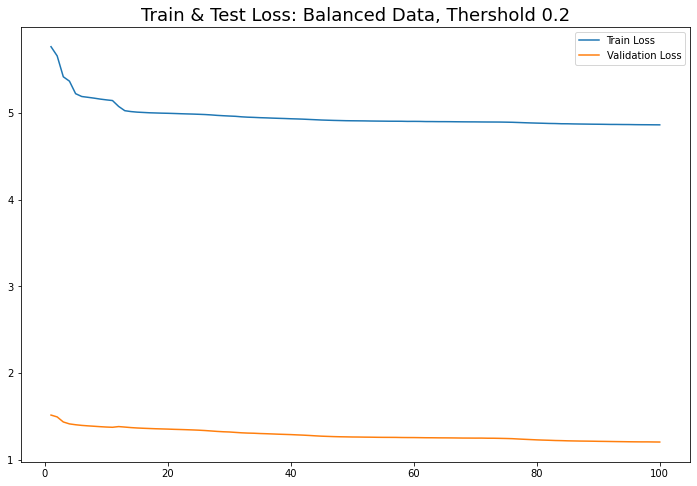

In [32]:
loss_plot(loss_train_list_T2, loss_validation_list_T2, 'Balanced Data', percent)

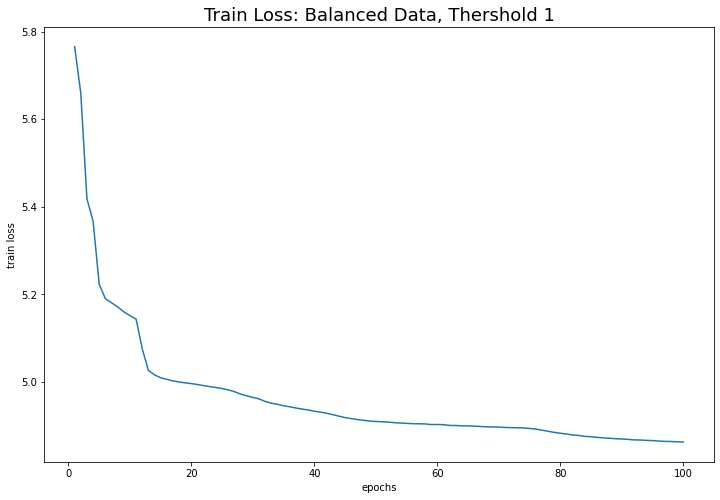

In [157]:
loss_plot_train(loss_train_list_T2, 'Balanced Data', percent)

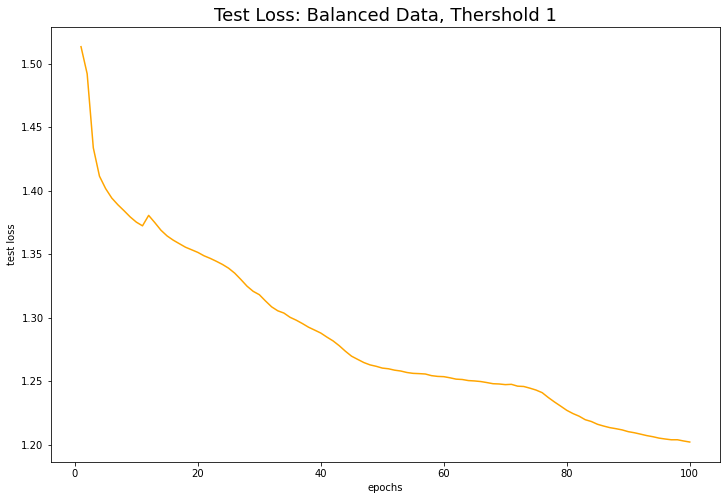

In [159]:
loss_plot_test(loss_validation_list_T2, 'Balanced Data', percent)

##### Accuracy Plot

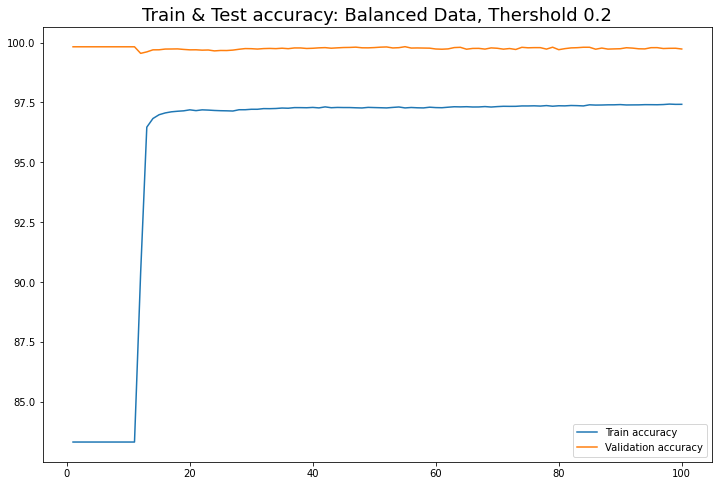

In [33]:
accuracy_plot(train_accuracy_list_T2, validation_accuracy_list_T2, 'Balanced Data', percent)

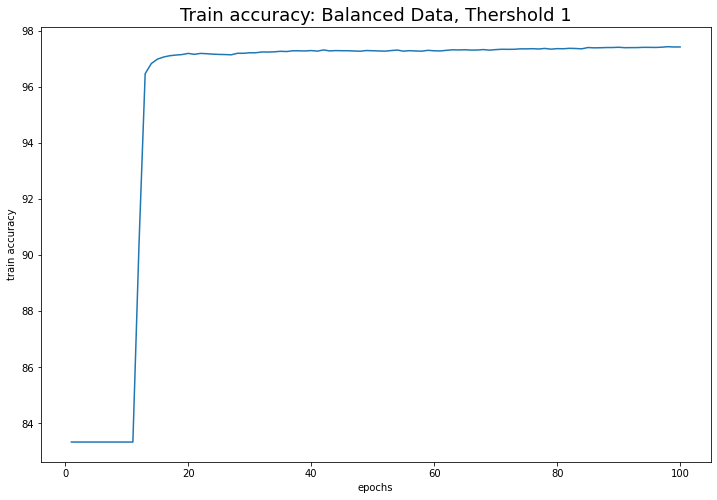

In [164]:
accuracy_plot_train(train_accuracy_list_T2, 'Balanced Data', percent)

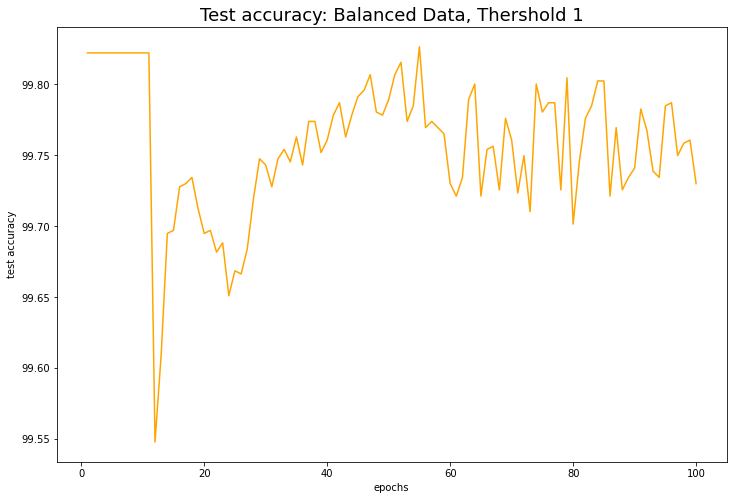

In [165]:
accuracy_plot_test(validation_accuracy_list_T2, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [34]:
def predict_list(data, autoencoder, classifier):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            decoded = autoencoder(inputs)
            outputs = classifier(decoded)
            _, predicted = torch.max(outputs.data, 1)
            for a, b in zip(labels, predicted):
                y_true.append(a.item())
                y_pred.append(b.item())
    return y_true, y_pred

In [35]:
y_true_T2, y_pred_T2 = predict_list(test_loader_T2, autoencoder, classifier)

In [36]:
def plot_cmx(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

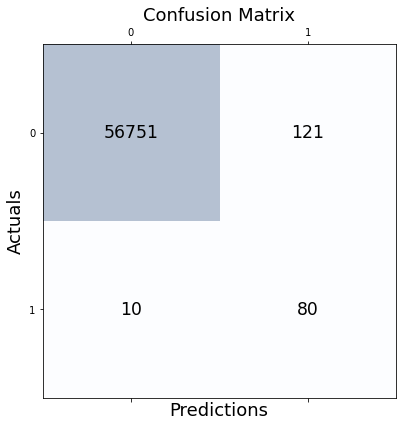

In [37]:
plot_cmx(y_true_T2, y_pred_T2)

In [41]:
def report(test_loader):
    y_actual = []
    y_pred = []
    loss_test= []
    with torch.no_grad():
        sum_of_loss= 0
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            #calculate outputs
            decoded = autoencoder(images)
            outputs = classifier(decoded)
            _, predicted = torch.max(outputs.data, 1)
            for a, b in zip(labels, predicted):
                y_actual.append(a.item())
                y_pred.append(b.item())
        
        
    accuracy = accuracy_score(y_actual, y_pred)
    recall_sc = recall_score(y_actual, y_pred, average="macro")
    f1_sc = f1_score(y_actual, y_pred, average="macro")
    presicion = precision_score(y_actual, y_pred, average="macro")

    # accuracy
    print("accuracy:", accuracy)
    # recall
    print("recall score:", recall_sc)
    # f1_score
    print("f1 score:", f1_sc)
    # precision
    print("presicion:", presicion)

    return accuracy, recall_sc, f1_sc, presicion

In [42]:
accuracy_T2, recall_T2, f1_score_T2, presicion_T2 = report(test_loader_T2)

accuracy: 0.9977002212000983
recall score: 0.9433806520685828
f1 score: 0.7743376722851341
presicion: 0.6989168864719584


<hr/>
<hr/>

# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 0.3 )------!!!!!!!!!!!!!!!!!!!!!!***

In [43]:
percent = 0.3
X_train_res_T3, y_train_res_T3 = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [44]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [45]:
#Datalodaer, Threshold 0.3
train_loader_T3, validation_loader_T3, test_loader_T3 = loader(X_train_res_T3, y_train_res_T3, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [46]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [47]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [48]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [49]:
loss_train_list_T3, loss_validation_list_T3,train_accuracy_list_T3, validation_accuracy_list_T3= training_balanced_data(train_loader_T3, validation_loader_T3, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 95.63it/s, curr_loss_validation={1.5185210689118034}]


At Epoch 1/100:  Train Loss= 7.358639001544136 , Train Accuracy= 76.923 %
At Epoch 1/100: validation Loss= 1.5185210689118034 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 96.11it/s, curr_loss_validation={1.47677570503009}]


At Epoch 2/100:  Train Loss= 7.321346049677434 , Train Accuracy= 76.923 %
At Epoch 2/100: validation Loss= 1.47677570503009 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 95.39it/s, curr_loss_validation={1.45750986745483}]


At Epoch 3/100:  Train Loss= 7.312234812060841 , Train Accuracy= 76.923 %
At Epoch 3/100: validation Loss= 1.45750986745483 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 94.91it/s, curr_loss_validation={1.446356893370026}]


At Epoch 4/100:  Train Loss= 7.310003400906561 , Train Accuracy= 76.923 %
At Epoch 4/100: validation Loss= 1.446356893370026 , validation Accuracy= 99.822 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 95.59it/s, curr_loss_validation={1.4391453336728246}]


At Epoch 5/100:  Train Loss= 7.305405113331417 , Train Accuracy= 76.923 %
At Epoch 5/100: validation Loss= 1.4391453336728246 , validation Accuracy= 99.822 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 92.58it/s, curr_loss_validation={1.4337419475379742}]


At Epoch 6/100:  Train Loss= 7.305980431565163 , Train Accuracy= 76.923 %
At Epoch 6/100: validation Loss= 1.4337419475379742 , validation Accuracy= 99.822 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 93.93it/s, curr_loss_validation={1.4296372540687259}]


At Epoch 7/100:  Train Loss= 7.304289795448874 , Train Accuracy= 76.923 %
At Epoch 7/100: validation Loss= 1.4296372540687259 , validation Accuracy= 99.822 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 95.53it/s, curr_loss_validation={1.4269817126424689}]


At Epoch 8/100:  Train Loss= 7.3010676269748815 , Train Accuracy= 76.923 %
At Epoch 8/100: validation Loss= 1.4269817126424689 , validation Accuracy= 99.822 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 93.87it/s, curr_loss_validation={1.4237041857681776}]


At Epoch 9/100:  Train Loss= 7.297741158984611 , Train Accuracy= 76.923 %
At Epoch 9/100: validation Loss= 1.4237041857681776 , validation Accuracy= 99.822 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 90.34it/s, curr_loss_validation={1.4235876743730747}]


At Epoch 10/100:  Train Loss= 7.293591754971349 , Train Accuracy= 76.923 %
At Epoch 10/100: validation Loss= 1.4235876743730747 , validation Accuracy= 99.822 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 94.40it/s, curr_loss_validation={1.4213856890013343}]


At Epoch 11/100:  Train Loss= 7.1553177380289865 , Train Accuracy= 76.923 %
At Epoch 11/100: validation Loss= 1.4213856890013343 , validation Accuracy= 99.822 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 94.48it/s, curr_loss_validation={1.4091994589880894}]


At Epoch 12/100:  Train Loss= 7.097564848959069 , Train Accuracy= 76.923 %
At Epoch 12/100: validation Loss= 1.4091994589880894 , validation Accuracy= 99.822 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 95.26it/s, curr_loss_validation={1.399233989025417}]


At Epoch 13/100:  Train Loss= 7.084462323569526 , Train Accuracy= 76.923 %
At Epoch 13/100: validation Loss= 1.399233989025417 , validation Accuracy= 99.822 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 91.33it/s, curr_loss_validation={1.3897492367970317}]


At Epoch 14/100:  Train Loss= 7.072634761626579 , Train Accuracy= 76.923 %
At Epoch 14/100: validation Loss= 1.3897492367970317 , validation Accuracy= 99.822 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 95.01it/s, curr_loss_validation={1.3864213612518812}]


At Epoch 15/100:  Train Loss= 6.962677344623174 , Train Accuracy= 76.923 %
At Epoch 15/100: validation Loss= 1.3864213612518812 , validation Accuracy= 99.822 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 93.36it/s, curr_loss_validation={1.3786140978336334}]


At Epoch 16/100:  Train Loss= 6.892712952066284 , Train Accuracy= 76.923 %
At Epoch 16/100: validation Loss= 1.3786140978336334 , validation Accuracy= 99.822 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 95.14it/s, curr_loss_validation={1.3702626079320908}]


At Epoch 17/100:  Train Loss= 6.879355532134894 , Train Accuracy= 76.923 %
At Epoch 17/100: validation Loss= 1.3702626079320908 , validation Accuracy= 99.822 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 112.66it/s, curr_loss_validation={1.3619291617682105}]


At Epoch 18/100:  Train Loss= 6.859783809599012 , Train Accuracy= 76.923 %
At Epoch 18/100: validation Loss= 1.3619291617682105 , validation Accuracy= 99.822 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 91.56it/s, curr_loss_validation={1.3557707659508054}]


At Epoch 19/100:  Train Loss= 6.845842709559451 , Train Accuracy= 76.923 %
At Epoch 19/100: validation Loss= 1.3557707659508054 , validation Accuracy= 99.822 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 113.05it/s, curr_loss_validation={1.351949985090055}]


At Epoch 20/100:  Train Loss= 6.834082174361583 , Train Accuracy= 76.923 %
At Epoch 20/100: validation Loss= 1.351949985090055 , validation Accuracy= 99.822 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 92.75it/s, curr_loss_validation={1.3499892001089298}]


At Epoch 21/100:  Train Loss= 6.821972457779376 , Train Accuracy= 76.923 %
At Epoch 21/100: validation Loss= 1.3499892001089298 , validation Accuracy= 99.822 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 94.91it/s, curr_loss_validation={1.3511171372313249}]


At Epoch 22/100:  Train Loss= 6.8097999277223655 , Train Accuracy= 76.923 %
At Epoch 22/100: validation Loss= 1.3511171372313249 , validation Accuracy= 99.822 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 102.89it/s, curr_loss_validation={1.3580729733956487}]


At Epoch 23/100:  Train Loss= 6.684897313402028 , Train Accuracy= 92.051 %
At Epoch 23/100: validation Loss= 1.3580729733956487 , validation Accuracy= 99.315 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 94.40it/s, curr_loss_validation={1.3505734401313882}]


At Epoch 24/100:  Train Loss= 6.6508608852502515 , Train Accuracy= 95.872 %
At Epoch 24/100: validation Loss= 1.3505734401313882 , validation Accuracy= 99.502 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 99.66it/s, curr_loss_validation={1.3463877274801856}]


At Epoch 25/100:  Train Loss= 6.641389748593851 , Train Accuracy= 96.043 %
At Epoch 25/100: validation Loss= 1.3463877274801856 , validation Accuracy= 99.544 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 90.47it/s, curr_loss_validation={1.3431457061516612}]


At Epoch 26/100:  Train Loss= 6.6378547900529865 , Train Accuracy= 96.182 %
At Epoch 26/100: validation Loss= 1.3431457061516612 , validation Accuracy= 99.537 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 105.02it/s, curr_loss_validation={1.340808629989624}]


At Epoch 27/100:  Train Loss= 6.634524943408555 , Train Accuracy= 96.234 %
At Epoch 27/100: validation Loss= 1.340808629989624 , validation Accuracy= 99.511 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 120.13it/s, curr_loss_validation={1.338585553984893}]


At Epoch 28/100:  Train Loss= 6.630783640084309 , Train Accuracy= 96.246 %
At Epoch 28/100: validation Loss= 1.338585553984893 , validation Accuracy= 99.570 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 118.23it/s, curr_loss_validation={1.3366116653931768}]


At Epoch 29/100:  Train Loss= 6.63068428964216 , Train Accuracy= 96.281 %
At Epoch 29/100: validation Loss= 1.3366116653931768 , validation Accuracy= 99.511 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 115.84it/s, curr_loss_validation={1.3347602267014353}]


At Epoch 30/100:  Train Loss= 6.627270628442027 , Train Accuracy= 96.279 %
At Epoch 30/100: validation Loss= 1.3347602267014353 , validation Accuracy= 99.533 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 93.13it/s, curr_loss_validation={1.3327142321749736}]


At Epoch 31/100:  Train Loss= 6.624335849844155 , Train Accuracy= 96.335 %
At Epoch 31/100: validation Loss= 1.3327142321749736 , validation Accuracy= 99.583 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 99.97it/s, curr_loss_validation={1.3307351289611113}] 


At Epoch 32/100:  Train Loss= 6.62353706087903 , Train Accuracy= 96.322 %
At Epoch 32/100: validation Loss= 1.3307351289611113 , validation Accuracy= 99.576 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 115.50it/s, curr_loss_validation={1.3289681539723748}]


At Epoch 33/100:  Train Loss= 6.620901188771836 , Train Accuracy= 96.316 %
At Epoch 33/100: validation Loss= 1.3289681539723748 , validation Accuracy= 99.631 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 90.95it/s, curr_loss_validation={1.3275107780569477}]


At Epoch 34/100:  Train Loss= 6.619670901159521 , Train Accuracy= 96.325 %
At Epoch 34/100: validation Loss= 1.3275107780569477 , validation Accuracy= 99.653 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 121.36it/s, curr_loss_validation={1.326257306494211}]


At Epoch 35/100:  Train Loss= 6.620595795422301 , Train Accuracy= 96.346 %
At Epoch 35/100: validation Loss= 1.326257306494211 , validation Accuracy= 99.594 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 127.07it/s, curr_loss_validation={1.325144643846311}]


At Epoch 36/100:  Train Loss= 6.616541320984505 , Train Accuracy= 96.348 %
At Epoch 36/100: validation Loss= 1.325144643846311 , validation Accuracy= 99.596 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 108.87it/s, curr_loss_validation={1.3240924077598673}]


At Epoch 37/100:  Train Loss= 6.616491593637696 , Train Accuracy= 96.356 %
At Epoch 37/100: validation Loss= 1.3240924077598673 , validation Accuracy= 99.623 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 94.42it/s, curr_loss_validation={1.3238233053370525}]


At Epoch 38/100:  Train Loss= 6.61539456841308 , Train Accuracy= 96.363 %
At Epoch 38/100: validation Loss= 1.3238233053370525 , validation Accuracy= 99.598 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 94.19it/s, curr_loss_validation={1.3223571330308914}]


At Epoch 39/100:  Train Loss= 6.615099444286603 , Train Accuracy= 96.353 %
At Epoch 39/100: validation Loss= 1.3223571330308914 , validation Accuracy= 99.702 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 122.83it/s, curr_loss_validation={1.3218708548106646}]


At Epoch 40/100:  Train Loss= 6.614006297518848 , Train Accuracy= 96.368 %
At Epoch 40/100: validation Loss= 1.3218708548106646 , validation Accuracy= 99.629 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 103.20it/s, curr_loss_validation={1.321469479485562}]


At Epoch 41/100:  Train Loss= 6.612694190331134 , Train Accuracy= 96.371 %
At Epoch 41/100: validation Loss= 1.321469479485562 , validation Accuracy= 99.653 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 95.40it/s, curr_loss_validation={1.3208548756022203}] 


At Epoch 42/100:  Train Loss= 6.612171568949111 , Train Accuracy= 96.393 %
At Epoch 42/100: validation Loss= 1.3208548756022203 , validation Accuracy= 99.666 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 122.06it/s, curr_loss_validation={1.3202961816599494}]


At Epoch 43/100:  Train Loss= 6.611594195601604 , Train Accuracy= 96.381 %
At Epoch 43/100: validation Loss= 1.3202961816599494 , validation Accuracy= 99.693 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 129.83it/s, curr_loss_validation={1.3198095552231137}]


At Epoch 44/100:  Train Loss= 6.611118503396502 , Train Accuracy= 96.365 %
At Epoch 44/100: validation Loss= 1.3198095552231137 , validation Accuracy= 99.691 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 104.11it/s, curr_loss_validation={1.319620344983904}]


At Epoch 45/100:  Train Loss= 6.610780694487732 , Train Accuracy= 96.381 %
At Epoch 45/100: validation Loss= 1.319620344983904 , validation Accuracy= 99.666 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 122.16it/s, curr_loss_validation={1.3197665018470663}]


At Epoch 46/100:  Train Loss= 6.611285856317053 , Train Accuracy= 96.396 %
At Epoch 46/100: validation Loss= 1.3197665018470663 , validation Accuracy= 99.629 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 117.40it/s, curr_loss_validation={1.319194916047548}]


At Epoch 47/100:  Train Loss= 6.609603799643474 , Train Accuracy= 96.402 %
At Epoch 47/100: validation Loss= 1.319194916047548 , validation Accuracy= 99.623 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 103.36it/s, curr_loss_validation={1.3185064800475772}]


At Epoch 48/100:  Train Loss= 6.610406144339171 , Train Accuracy= 96.394 %
At Epoch 48/100: validation Loss= 1.3185064800475772 , validation Accuracy= 99.647 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 111.03it/s, curr_loss_validation={1.3178536699790704}]


At Epoch 49/100:  Train Loss= 6.608036454337329 , Train Accuracy= 96.439 %
At Epoch 49/100: validation Loss= 1.3178536699790704 , validation Accuracy= 99.625 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 97.64it/s, curr_loss_validation={1.316069685314831}]


At Epoch 50/100:  Train Loss= 6.606745906051423 , Train Accuracy= 96.402 %
At Epoch 50/100: validation Loss= 1.316069685314831 , validation Accuracy= 99.625 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 130.51it/s, curr_loss_validation={1.3144623096051968}]


At Epoch 51/100:  Train Loss= 6.6057844902323835 , Train Accuracy= 96.414 %
At Epoch 51/100: validation Loss= 1.3144623096051968 , validation Accuracy= 99.653 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 122.69it/s, curr_loss_validation={1.3136872829575288}]


At Epoch 52/100:  Train Loss= 6.604358332540901 , Train Accuracy= 96.438 %
At Epoch 52/100: validation Loss= 1.3136872829575288 , validation Accuracy= 99.677 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 124.10it/s, curr_loss_validation={1.3125305842412145}]


At Epoch 53/100:  Train Loss= 6.604515654052618 , Train Accuracy= 96.434 %
At Epoch 53/100: validation Loss= 1.3125305842412145 , validation Accuracy= 99.662 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 130.20it/s, curr_loss_validation={1.311125524734196}]


At Epoch 54/100:  Train Loss= 6.601903578778788 , Train Accuracy= 96.439 %
At Epoch 54/100: validation Loss= 1.311125524734196 , validation Accuracy= 99.647 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 125.57it/s, curr_loss_validation={1.3096470032867633}]


At Epoch 55/100:  Train Loss= 6.599446833360331 , Train Accuracy= 96.440 %
At Epoch 55/100: validation Loss= 1.3096470032867633 , validation Accuracy= 99.623 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 132.28it/s, curr_loss_validation={1.3076525087419308}]


At Epoch 56/100:  Train Loss= 6.599057233832181 , Train Accuracy= 96.449 %
At Epoch 56/100: validation Loss= 1.3076525087419308 , validation Accuracy= 99.717 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 107.68it/s, curr_loss_validation={1.306115251622702}]


At Epoch 57/100:  Train Loss= 6.598164161650702 , Train Accuracy= 96.413 %
At Epoch 57/100: validation Loss= 1.306115251622702 , validation Accuracy= 99.669 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 95.59it/s, curr_loss_validation={1.304354453557416}]


At Epoch 58/100:  Train Loss= 6.5982244866882445 , Train Accuracy= 96.444 %
At Epoch 58/100: validation Loss= 1.304354453557416 , validation Accuracy= 99.671 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 124.21it/s, curr_loss_validation={1.3017271082652242}]


At Epoch 59/100:  Train Loss= 6.595608820933353 , Train Accuracy= 96.472 %
At Epoch 59/100: validation Loss= 1.3017271082652242 , validation Accuracy= 99.682 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 115.77it/s, curr_loss_validation={1.2996009462758114}]


At Epoch 60/100:  Train Loss= 6.596067060233674 , Train Accuracy= 96.459 %
At Epoch 60/100: validation Loss= 1.2996009462758114 , validation Accuracy= 99.699 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 111.20it/s, curr_loss_validation={1.2972539647629386}]


At Epoch 61/100:  Train Loss= 6.592958062320608 , Train Accuracy= 96.458 %
At Epoch 61/100: validation Loss= 1.2972539647629386 , validation Accuracy= 99.715 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 109.79it/s, curr_loss_validation={1.2949147193055404}]


At Epoch 62/100:  Train Loss= 6.591188878614187 , Train Accuracy= 96.448 %
At Epoch 62/100: validation Loss= 1.2949147193055404 , validation Accuracy= 99.695 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 111.37it/s, curr_loss_validation={1.2927740443693965}]


At Epoch 63/100:  Train Loss= 6.589465518112569 , Train Accuracy= 96.455 %
At Epoch 63/100: validation Loss= 1.2927740443693965 , validation Accuracy= 99.653 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 118.21it/s, curr_loss_validation={1.290194516119204}]


At Epoch 64/100:  Train Loss= 6.5887056104130615 , Train Accuracy= 96.431 %
At Epoch 64/100: validation Loss= 1.290194516119204 , validation Accuracy= 99.691 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 107.79it/s, curr_loss_validation={1.288065909162948}]


At Epoch 65/100:  Train Loss= 6.586451855600258 , Train Accuracy= 96.455 %
At Epoch 65/100: validation Loss= 1.288065909162948 , validation Accuracy= 99.688 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 96.88it/s, curr_loss_validation={1.2867517502684342}] 


At Epoch 66/100:  Train Loss= 6.586356700902051 , Train Accuracy= 96.460 %
At Epoch 66/100: validation Loss= 1.2867517502684342 , validation Accuracy= 99.704 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 94.85it/s, curr_loss_validation={1.2849932689415782}] 


At Epoch 67/100:  Train Loss= 6.5841566863622045 , Train Accuracy= 96.454 %
At Epoch 67/100: validation Loss= 1.2849932689415782 , validation Accuracy= 99.695 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 129.66it/s, curr_loss_validation={1.2841409319325496}]


At Epoch 68/100:  Train Loss= 6.582063034309029 , Train Accuracy= 96.475 %
At Epoch 68/100: validation Loss= 1.2841409319325496 , validation Accuracy= 99.704 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 125.23it/s, curr_loss_validation={1.2822634452267696}]


At Epoch 69/100:  Train Loss= 6.58212608136756 , Train Accuracy= 96.473 %
At Epoch 69/100: validation Loss= 1.2822634452267696 , validation Accuracy= 99.695 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 123.95it/s, curr_loss_validation={1.2812269969206107}]


At Epoch 70/100:  Train Loss= 6.580577157145067 , Train Accuracy= 96.455 %
At Epoch 70/100: validation Loss= 1.2812269969206107 , validation Accuracy= 99.675 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 95.98it/s, curr_loss_validation={1.2800087520950718}]


At Epoch 71/100:  Train Loss= 6.58203930818536 , Train Accuracy= 96.495 %
At Epoch 71/100: validation Loss= 1.2800087520950718 , validation Accuracy= 99.754 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 132.26it/s, curr_loss_validation={1.27557336264535}]


At Epoch 72/100:  Train Loss= 6.5788185285222545 , Train Accuracy= 96.451 %
At Epoch 72/100: validation Loss= 1.27557336264535 , validation Accuracy= 99.756 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 128.09it/s, curr_loss_validation={1.2731003855404102}]


At Epoch 73/100:  Train Loss= 6.577641632469284 , Train Accuracy= 96.463 %
At Epoch 73/100: validation Loss= 1.2731003855404102 , validation Accuracy= 99.748 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 98.91it/s, curr_loss_validation={1.2714891284704208}]


At Epoch 74/100:  Train Loss= 6.572006467630655 , Train Accuracy= 96.456 %
At Epoch 74/100: validation Loss= 1.2714891284704208 , validation Accuracy= 99.706 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 97.44it/s, curr_loss_validation={1.2702873662898415}]


At Epoch 75/100:  Train Loss= 6.573006561349402 , Train Accuracy= 96.471 %
At Epoch 75/100: validation Loss= 1.2702873662898415 , validation Accuracy= 99.728 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 125.54it/s, curr_loss_validation={1.2693878239706944}]


At Epoch 76/100:  Train Loss= 6.569385663940275 , Train Accuracy= 96.472 %
At Epoch 76/100: validation Loss= 1.2693878239706944 , validation Accuracy= 99.741 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 99.57it/s, curr_loss_validation={1.268303002573942}]


At Epoch 77/100:  Train Loss= 6.569663010018256 , Train Accuracy= 96.466 %
At Epoch 77/100: validation Loss= 1.268303002573942 , validation Accuracy= 99.686 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 101.83it/s, curr_loss_validation={1.2677397727966309}]


At Epoch 78/100:  Train Loss= 6.572252886679085 , Train Accuracy= 96.493 %
At Epoch 78/100: validation Loss= 1.2677397727966309 , validation Accuracy= 99.737 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 120.47it/s, curr_loss_validation={1.267376549934086}]


At Epoch 79/100:  Train Loss= 6.568247014880936 , Train Accuracy= 96.486 %
At Epoch 79/100: validation Loss= 1.267376549934086 , validation Accuracy= 99.695 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 112.22it/s, curr_loss_validation={1.2661448042643697}]


At Epoch 80/100:  Train Loss= 6.566598513280484 , Train Accuracy= 96.481 %
At Epoch 80/100: validation Loss= 1.2661448042643697 , validation Accuracy= 99.680 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 120.45it/s, curr_loss_validation={1.2651466907639253}]


At Epoch 81/100:  Train Loss= 6.567813490733448 , Train Accuracy= 96.495 %
At Epoch 81/100: validation Loss= 1.2651466907639253 , validation Accuracy= 99.745 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 131.34it/s, curr_loss_validation={1.2645471174465983}]


At Epoch 82/100:  Train Loss= 6.566779538856864 , Train Accuracy= 96.500 %
At Epoch 82/100: validation Loss= 1.2645471174465983 , validation Accuracy= 99.693 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 131.15it/s, curr_loss_validation={1.2638861478159302}]


At Epoch 83/100:  Train Loss= 6.564596889892307 , Train Accuracy= 96.514 %
At Epoch 83/100: validation Loss= 1.2638861478159302 , validation Accuracy= 99.673 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 123.44it/s, curr_loss_validation={1.263256505915993}]


At Epoch 84/100:  Train Loss= 6.564933864789317 , Train Accuracy= 96.505 %
At Epoch 84/100: validation Loss= 1.263256505915993 , validation Accuracy= 99.675 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 97.55it/s, curr_loss_validation={1.2631606004740064}]


At Epoch 85/100:  Train Loss= 6.563079878404567 , Train Accuracy= 96.505 %
At Epoch 85/100: validation Loss= 1.2631606004740064 , validation Accuracy= 99.730 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 93.03it/s, curr_loss_validation={1.2615665526766526}]


At Epoch 86/100:  Train Loss= 6.56335631885456 , Train Accuracy= 96.501 %
At Epoch 86/100: validation Loss= 1.2615665526766526 , validation Accuracy= 99.743 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 90.58it/s, curr_loss_validation={1.2612309377444417}]


At Epoch 87/100:  Train Loss= 6.563038027029678 , Train Accuracy= 96.482 %
At Epoch 87/100: validation Loss= 1.2612309377444417 , validation Accuracy= 99.750 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 93.63it/s, curr_loss_validation={1.2610857314185093}]


At Epoch 88/100:  Train Loss= 6.563363972725524 , Train Accuracy= 96.474 %
At Epoch 88/100: validation Loss= 1.2610857314185093 , validation Accuracy= 99.710 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 98.77it/s, curr_loss_validation={1.2601771672305309}]


At Epoch 89/100:  Train Loss= 6.5625320178927575 , Train Accuracy= 96.496 %
At Epoch 89/100: validation Loss= 1.2601771672305309 , validation Accuracy= 99.717 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 93.03it/s, curr_loss_validation={1.2601254111842106}]


At Epoch 90/100:  Train Loss= 6.562734062982905 , Train Accuracy= 96.518 %
At Epoch 90/100: validation Loss= 1.2601254111842106 , validation Accuracy= 99.728 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 96.96it/s, curr_loss_validation={1.259653253774894}]


At Epoch 91/100:  Train Loss= 6.559633359558531 , Train Accuracy= 96.527 %
At Epoch 91/100: validation Loss= 1.259653253774894 , validation Accuracy= 99.666 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 129.31it/s, curr_loss_validation={1.2592501499150928}]


At Epoch 92/100:  Train Loss= 6.560295650109894 , Train Accuracy= 96.493 %
At Epoch 92/100: validation Loss= 1.2592501499150928 , validation Accuracy= 99.686 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 132.45it/s, curr_loss_validation={1.2588283051001399}]


At Epoch 93/100:  Train Loss= 6.560702719766982 , Train Accuracy= 96.514 %
At Epoch 93/100: validation Loss= 1.2588283051001399 , validation Accuracy= 99.713 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 122.63it/s, curr_loss_validation={1.2584206971683}]


At Epoch 94/100:  Train Loss= 6.560514292336236 , Train Accuracy= 96.498 %
At Epoch 94/100: validation Loss= 1.2584206971683 , validation Accuracy= 99.695 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 95.55it/s, curr_loss_validation={1.2582155026887591}]


At Epoch 95/100:  Train Loss= 6.559749847733627 , Train Accuracy= 96.555 %
At Epoch 95/100: validation Loss= 1.2582155026887591 , validation Accuracy= 99.688 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 132.88it/s, curr_loss_validation={1.2581243373845752}]


At Epoch 96/100:  Train Loss= 6.560182651488349 , Train Accuracy= 96.517 %
At Epoch 96/100: validation Loss= 1.2581243373845752 , validation Accuracy= 99.658 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 93.51it/s, curr_loss_validation={1.2581588429839987}]


At Epoch 97/100:  Train Loss= 6.56057811327307 , Train Accuracy= 96.502 %
At Epoch 97/100: validation Loss= 1.2581588429839987 , validation Accuracy= 99.682 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 120.39it/s, curr_loss_validation={1.2575305700302124}]


At Epoch 98/100:  Train Loss= 6.557958201914837 , Train Accuracy= 96.535 %
At Epoch 98/100: validation Loss= 1.2575305700302124 , validation Accuracy= 99.697 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 133.73it/s, curr_loss_validation={1.2572651152548038}]


At Epoch 99/100:  Train Loss= 6.556369330644305 , Train Accuracy= 96.527 %
At Epoch 99/100: validation Loss= 1.2572651152548038 , validation Accuracy= 99.649 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 100.78it/s, curr_loss_validation={1.2568495830422954}]


At Epoch 100/100:  Train Loss= 6.557361484933716 , Train Accuracy= 96.538 %
At Epoch 100/100: validation Loss= 1.2568495830422954 , validation Accuracy= 99.684 %



#### Visualization:

##### Loss Plot

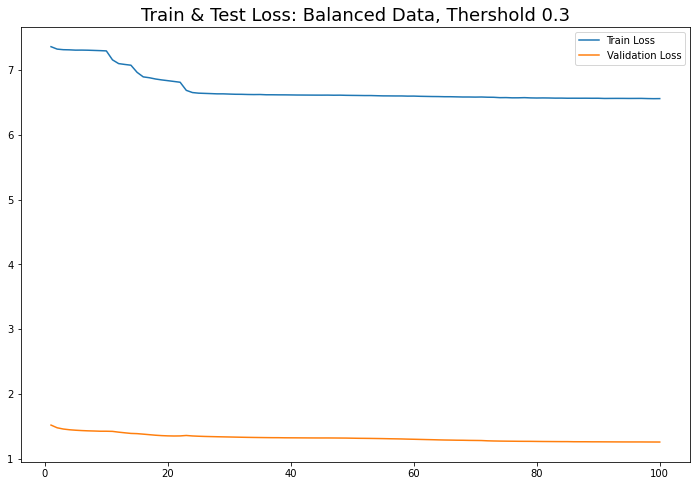

In [50]:
loss_plot(loss_train_list_T3, loss_validation_list_T3, 'Balanced Data', percent)

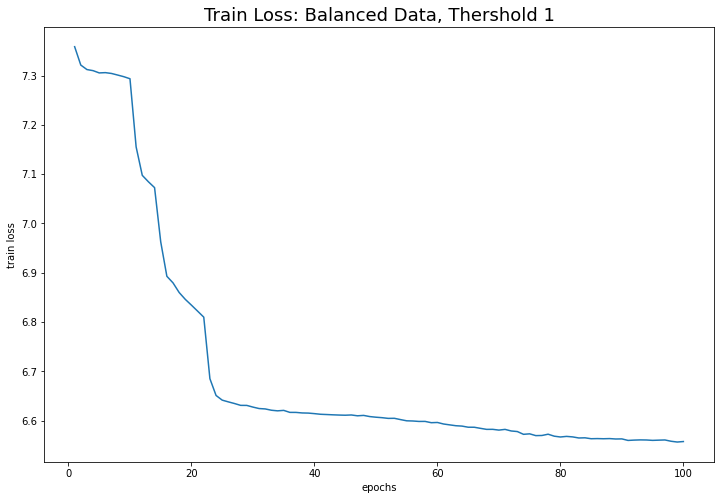

In [166]:
loss_plot_train(loss_train_list_T3, 'Balanced Data', percent)

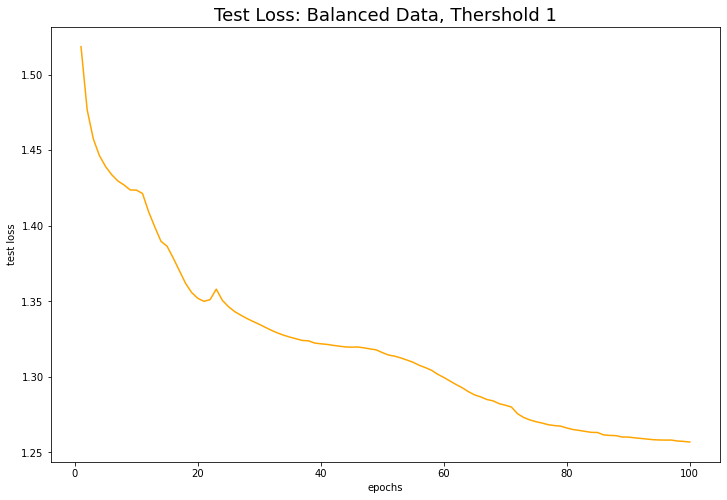

In [167]:
loss_plot_test(loss_validation_list_T3, 'Balanced Data', percent)

##### Accuracy Plot

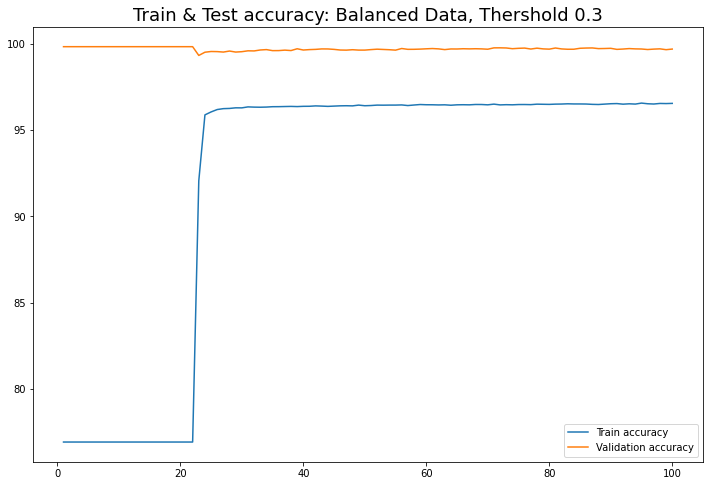

In [51]:
accuracy_plot(train_accuracy_list_T3, validation_accuracy_list_T3, 'Balanced Data', percent)

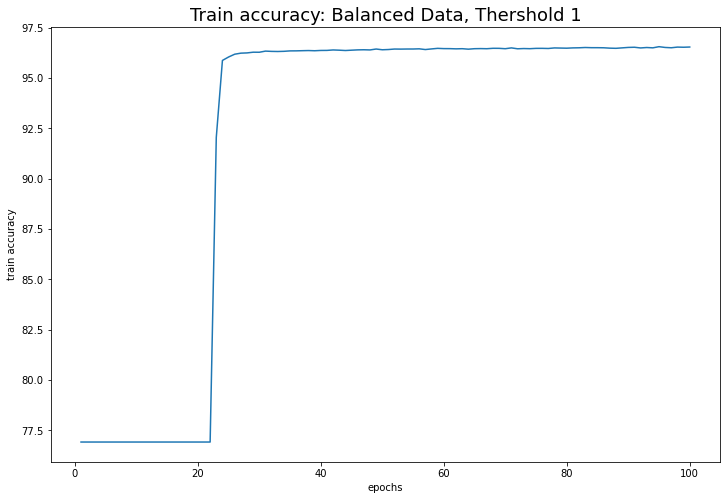

In [168]:
accuracy_plot_train(train_accuracy_list_T3, 'Balanced Data', percent)

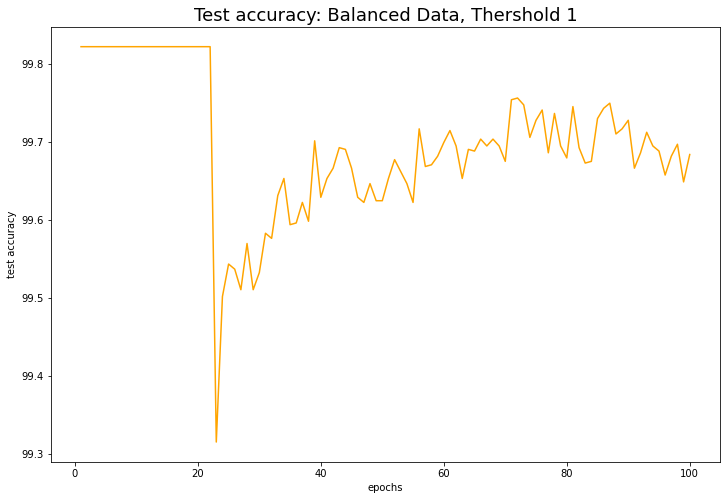

In [169]:
accuracy_plot_test(validation_accuracy_list_T3, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [52]:
y_true_T3, y_pred_T3 = predict_list(test_loader_T3, autoencoder, classifier)

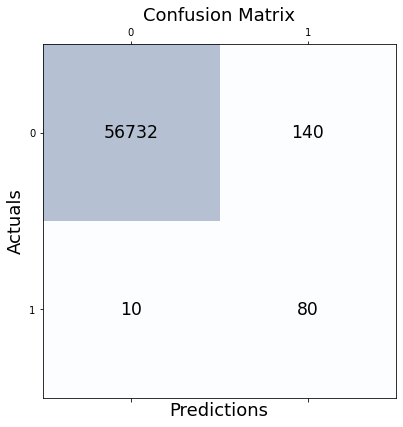

In [53]:
plot_cmx(y_true_T3, y_pred_T3)

In [54]:
accuracy_T3, recall_T3, f1_score_T3, presicion_T3 = report(test_loader_T3)

accuracy: 0.9973666654962958
recall score: 0.9432136102905551
f1 score: 0.7574043862154651
presicion: 0.681730063669368


<hr/>
<hr/>

# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 0.4 )------!!!!!!!!!!!!!!!!!!!!!!***

In [55]:
percent = 0.4
X_train_res_T4, y_train_res_T4 = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [56]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [57]:
#Datalodaer, Threshold 0.4
train_loader_T4, validation_loader_T4, test_loader_T4 = loader(X_train_res_T4, y_train_res_T4, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [58]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [59]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [60]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [61]:
loss_train_list_T4, loss_validation_list_T4,train_accuracy_list_T4, validation_accuracy_list_T4= training_balanced_data(train_loader_T4, validation_loader_T4, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 95.79it/s, curr_loss_validation={1.5315801516959542}]


At Epoch 1/100:  Train Loss= 8.688775254417868 , Train Accuracy= 71.429 %
At Epoch 1/100: validation Loss= 1.5315801516959542 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 93.42it/s, curr_loss_validation={1.479170054981583}]


At Epoch 2/100:  Train Loss= 8.497266794092514 , Train Accuracy= 71.429 %
At Epoch 2/100: validation Loss= 1.479170054981583 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 96.19it/s, curr_loss_validation={1.448717209853624}]


At Epoch 3/100:  Train Loss= 8.37475051206701 , Train Accuracy= 71.429 %
At Epoch 3/100: validation Loss= 1.448717209853624 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 95.82it/s, curr_loss_validation={1.4190656809430373}]


At Epoch 4/100:  Train Loss= 8.264106202967026 , Train Accuracy= 81.247 %
At Epoch 4/100: validation Loss= 1.4190656809430373 , validation Accuracy= 99.493 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 96.93it/s, curr_loss_validation={1.4031712961824316}]


At Epoch 5/100:  Train Loss= 8.162727898990406 , Train Accuracy= 94.090 %
At Epoch 5/100: validation Loss= 1.4031712961824316 , validation Accuracy= 99.423 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 95.67it/s, curr_loss_validation={1.3933982057006735}]


At Epoch 6/100:  Train Loss= 8.066782928635092 , Train Accuracy= 94.751 %
At Epoch 6/100: validation Loss= 1.3933982057006735 , validation Accuracy= 99.175 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 95.39it/s, curr_loss_validation={1.3871905552713495}]


At Epoch 7/100:  Train Loss= 7.813833042593563 , Train Accuracy= 95.343 %
At Epoch 7/100: validation Loss= 1.3871905552713495 , validation Accuracy= 99.019 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 98.48it/s, curr_loss_validation={1.3846849987381382}]


At Epoch 8/100:  Train Loss= 7.792504607929903 , Train Accuracy= 95.193 %
At Epoch 8/100: validation Loss= 1.3846849987381382 , validation Accuracy= 98.933 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 94.03it/s, curr_loss_validation={1.3818942896629636}]


At Epoch 9/100:  Train Loss= 7.7828936812456915 , Train Accuracy= 95.192 %
At Epoch 9/100: validation Loss= 1.3818942896629636 , validation Accuracy= 98.997 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 92.91it/s, curr_loss_validation={1.3767019745550657}]


At Epoch 10/100:  Train Loss= 7.765277974745807 , Train Accuracy= 95.245 %
At Epoch 10/100: validation Loss= 1.3767019745550657 , validation Accuracy= 99.192 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 97.04it/s, curr_loss_validation={1.3722290059453564}] 


At Epoch 11/100:  Train Loss= 7.760527879490572 , Train Accuracy= 95.334 %
At Epoch 11/100: validation Loss= 1.3722290059453564 , validation Accuracy= 99.271 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 108.94it/s, curr_loss_validation={1.3682956821040104}]


At Epoch 12/100:  Train Loss= 7.747115213730756 , Train Accuracy= 95.432 %
At Epoch 12/100: validation Loss= 1.3682956821040104 , validation Accuracy= 99.331 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 96.60it/s, curr_loss_validation={1.3652854373580532}]


At Epoch 13/100:  Train Loss= 7.744837743534761 , Train Accuracy= 95.523 %
At Epoch 13/100: validation Loss= 1.3652854373580532 , validation Accuracy= 99.460 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 94.38it/s, curr_loss_validation={1.3624862832458395}]


At Epoch 14/100:  Train Loss= 7.7415659046173095 , Train Accuracy= 95.562 %
At Epoch 14/100: validation Loss= 1.3624862832458395 , validation Accuracy= 99.473 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 94.98it/s, curr_loss_validation={1.3601368916662115}]


At Epoch 15/100:  Train Loss= 7.742908211315379 , Train Accuracy= 95.603 %
At Epoch 15/100: validation Loss= 1.3601368916662115 , validation Accuracy= 99.506 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 94.25it/s, curr_loss_validation={1.3581592024941194}]


At Epoch 16/100:  Train Loss= 7.739760861677282 , Train Accuracy= 95.630 %
At Epoch 16/100: validation Loss= 1.3581592024941194 , validation Accuracy= 99.480 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 121.74it/s, curr_loss_validation={1.3562446934612173}]


At Epoch 17/100:  Train Loss= 7.732406240912045 , Train Accuracy= 95.634 %
At Epoch 17/100: validation Loss= 1.3562446934612173 , validation Accuracy= 99.478 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 94.38it/s, curr_loss_validation={1.354748632562788}]


At Epoch 18/100:  Train Loss= 7.731503572463989 , Train Accuracy= 95.632 %
At Epoch 18/100: validation Loss= 1.354748632562788 , validation Accuracy= 99.508 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 93.53it/s, curr_loss_validation={1.354026568563361}]


At Epoch 19/100:  Train Loss= 7.732540380814497 , Train Accuracy= 95.641 %
At Epoch 19/100: validation Loss= 1.354026568563361 , validation Accuracy= 99.519 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 93.51it/s, curr_loss_validation={1.3527310161214126}]


At Epoch 20/100:  Train Loss= 7.733344324336333 , Train Accuracy= 95.636 %
At Epoch 20/100: validation Loss= 1.3527310161214126 , validation Accuracy= 99.502 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 96.82it/s, curr_loss_validation={1.351746021916992}]


At Epoch 21/100:  Train Loss= 7.726335905299467 , Train Accuracy= 95.635 %
At Epoch 21/100: validation Loss= 1.351746021916992 , validation Accuracy= 99.489 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 93.39it/s, curr_loss_validation={1.3505587319010182}]


At Epoch 22/100:  Train Loss= 7.724869999044082 , Train Accuracy= 95.651 %
At Epoch 22/100: validation Loss= 1.3505587319010182 , validation Accuracy= 99.530 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 110.54it/s, curr_loss_validation={1.3493643787346388}]


At Epoch 23/100:  Train Loss= 7.725727103177239 , Train Accuracy= 95.621 %
At Epoch 23/100: validation Loss= 1.3493643787346388 , validation Accuracy= 99.465 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 96.97it/s, curr_loss_validation={1.3480933881119679}]


At Epoch 24/100:  Train Loss= 7.722477548823637 , Train Accuracy= 95.604 %
At Epoch 24/100: validation Loss= 1.3480933881119679 , validation Accuracy= 99.497 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 97.76it/s, curr_loss_validation={1.3456868944983733}]


At Epoch 25/100:  Train Loss= 7.719140916151159 , Train Accuracy= 95.622 %
At Epoch 25/100: validation Loss= 1.3456868944983733 , validation Accuracy= 99.493 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 117.57it/s, curr_loss_validation={1.34311270164816}]


At Epoch 26/100:  Train Loss= 7.71721067091998 , Train Accuracy= 95.617 %
At Epoch 26/100: validation Loss= 1.34311270164816 , validation Accuracy= 99.370 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 110.32it/s, curr_loss_validation={1.3386197364644001}]


At Epoch 27/100:  Train Loss= 7.71005029482 , Train Accuracy= 95.609 %
At Epoch 27/100: validation Loss= 1.3386197364644001 , validation Accuracy= 99.407 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 124.09it/s, curr_loss_validation={1.3332353634269614}]


At Epoch 28/100:  Train Loss= 7.715500880970675 , Train Accuracy= 95.655 %
At Epoch 28/100: validation Loss= 1.3332353634269614 , validation Accuracy= 99.460 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 125.24it/s, curr_loss_validation={1.3294416164097034}]


At Epoch 29/100:  Train Loss= 7.710053134245031 , Train Accuracy= 95.624 %
At Epoch 29/100: validation Loss= 1.3294416164097034 , validation Accuracy= 99.438 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 103.79it/s, curr_loss_validation={1.32660695047755}]


At Epoch 30/100:  Train Loss= 7.701631825951969 , Train Accuracy= 95.617 %
At Epoch 30/100: validation Loss= 1.32660695047755 , validation Accuracy= 99.465 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 104.58it/s, curr_loss_validation={1.3254014959460811}]


At Epoch 31/100:  Train Loss= 7.70313468428219 , Train Accuracy= 95.672 %
At Epoch 31/100: validation Loss= 1.3254014959460811 , validation Accuracy= 99.467 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 102.66it/s, curr_loss_validation={1.324107685371449}]


At Epoch 32/100:  Train Loss= 7.700516760209028 , Train Accuracy= 95.661 %
At Epoch 32/100: validation Loss= 1.324107685371449 , validation Accuracy= 99.502 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 116.80it/s, curr_loss_validation={1.3230106893338656}]


At Epoch 33/100:  Train Loss= 7.702182405696195 , Train Accuracy= 95.650 %
At Epoch 33/100: validation Loss= 1.3230106893338656 , validation Accuracy= 99.504 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 126.06it/s, curr_loss_validation={1.3223116491970264}]


At Epoch 34/100:  Train Loss= 7.694086897793938 , Train Accuracy= 95.671 %
At Epoch 34/100: validation Loss= 1.3223116491970264 , validation Accuracy= 99.489 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 113.46it/s, curr_loss_validation={1.3214827799483349}]


At Epoch 35/100:  Train Loss= 7.693166627883911 , Train Accuracy= 95.697 %
At Epoch 35/100: validation Loss= 1.3214827799483349 , validation Accuracy= 99.541 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 115.69it/s, curr_loss_validation={1.3212283183085292}]


At Epoch 36/100:  Train Loss= 7.699302875855389 , Train Accuracy= 95.659 %
At Epoch 36/100: validation Loss= 1.3212283183085292 , validation Accuracy= 99.491 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 123.88it/s, curr_loss_validation={1.3203015939185494}]


At Epoch 37/100:  Train Loss= 7.700818554934333 , Train Accuracy= 95.690 %
At Epoch 37/100: validation Loss= 1.3203015939185494 , validation Accuracy= 99.579 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 121.69it/s, curr_loss_validation={1.3199458341849477}]


At Epoch 38/100:  Train Loss= 7.698423012004179 , Train Accuracy= 95.740 %
At Epoch 38/100: validation Loss= 1.3199458341849477 , validation Accuracy= 99.533 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 106.24it/s, curr_loss_validation={1.319152345782832}]


At Epoch 39/100:  Train Loss= 7.692608414818259 , Train Accuracy= 95.682 %
At Epoch 39/100: validation Loss= 1.319152345782832 , validation Accuracy= 99.486 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 109.53it/s, curr_loss_validation={1.3186475650260323}]


At Epoch 40/100:  Train Loss= 7.699387590744916 , Train Accuracy= 95.724 %
At Epoch 40/100: validation Loss= 1.3186475650260323 , validation Accuracy= 99.550 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 95.74it/s, curr_loss_validation={1.318059504032135}]


At Epoch 41/100:  Train Loss= 7.6884234175962565 , Train Accuracy= 95.751 %
At Epoch 41/100: validation Loss= 1.318059504032135 , validation Accuracy= 99.537 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 119.01it/s, curr_loss_validation={1.3181043063339435}]


At Epoch 42/100:  Train Loss= 7.685555829581093 , Train Accuracy= 95.706 %
At Epoch 42/100: validation Loss= 1.3181043063339435 , validation Accuracy= 99.559 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 98.75it/s, curr_loss_validation={1.3173286805027409}]


At Epoch 43/100:  Train Loss= 7.686791501606212 , Train Accuracy= 95.758 %
At Epoch 43/100: validation Loss= 1.3173286805027409 , validation Accuracy= 99.528 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 107.86it/s, curr_loss_validation={1.3162285395358737}]


At Epoch 44/100:  Train Loss= 7.68691099503461 , Train Accuracy= 95.732 %
At Epoch 44/100: validation Loss= 1.3162285395358737 , validation Accuracy= 99.546 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 125.77it/s, curr_loss_validation={1.3159396468024505}]


At Epoch 45/100:  Train Loss= 7.687204879872939 , Train Accuracy= 95.739 %
At Epoch 45/100: validation Loss= 1.3159396468024505 , validation Accuracy= 99.565 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 101.38it/s, curr_loss_validation={1.3159225112513493}]


At Epoch 46/100:  Train Loss= 7.684672254955068 , Train Accuracy= 95.741 %
At Epoch 46/100: validation Loss= 1.3159225112513493 , validation Accuracy= 99.555 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 114.34it/s, curr_loss_validation={1.3153837182019885}]


At Epoch 47/100:  Train Loss= 7.693470326030956 , Train Accuracy= 95.748 %
At Epoch 47/100: validation Loss= 1.3153837182019885 , validation Accuracy= 99.508 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 102.47it/s, curr_loss_validation={1.3142913776008707}]


At Epoch 48/100:  Train Loss= 7.689955732121187 , Train Accuracy= 95.741 %
At Epoch 48/100: validation Loss= 1.3142913776008707 , validation Accuracy= 99.572 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 120.74it/s, curr_loss_validation={1.3141511098334664}]


At Epoch 49/100:  Train Loss= 7.687260825213264 , Train Accuracy= 95.771 %
At Epoch 49/100: validation Loss= 1.3141511098334664 , validation Accuracy= 99.530 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 122.07it/s, curr_loss_validation={1.3139061002354873}]


At Epoch 50/100:  Train Loss= 7.688770763733808 , Train Accuracy= 95.787 %
At Epoch 50/100: validation Loss= 1.3139061002354873 , validation Accuracy= 99.513 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 118.85it/s, curr_loss_validation={1.3130625070709931}]


At Epoch 51/100:  Train Loss= 7.688110301634844 , Train Accuracy= 95.782 %
At Epoch 51/100: validation Loss= 1.3130625070709931 , validation Accuracy= 99.565 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 112.54it/s, curr_loss_validation={1.3123016216252978}]


At Epoch 52/100:  Train Loss= 7.683087431963752 , Train Accuracy= 95.764 %
At Epoch 52/100: validation Loss= 1.3123016216252978 , validation Accuracy= 99.565 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 126.53it/s, curr_loss_validation={1.3122592058620954}]


At Epoch 53/100:  Train Loss= 7.687150321287267 , Train Accuracy= 95.799 %
At Epoch 53/100: validation Loss= 1.3122592058620954 , validation Accuracy= 99.592 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 121.48it/s, curr_loss_validation={1.3116544304709685}]


At Epoch 54/100:  Train Loss= 7.685379036735086 , Train Accuracy= 95.776 %
At Epoch 54/100: validation Loss= 1.3116544304709685 , validation Accuracy= 99.574 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 120.52it/s, curr_loss_validation={1.3120527557636563}]


At Epoch 55/100:  Train Loss= 7.681964097303503 , Train Accuracy= 95.816 %
At Epoch 55/100: validation Loss= 1.3120527557636563 , validation Accuracy= 99.539 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 109.79it/s, curr_loss_validation={1.3113123601988743}]


At Epoch 56/100:  Train Loss= 7.682250553579891 , Train Accuracy= 95.780 %
At Epoch 56/100: validation Loss= 1.3113123601988743 , validation Accuracy= 99.555 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 105.05it/s, curr_loss_validation={1.3114497143971293}]


At Epoch 57/100:  Train Loss= 7.679841596939984 , Train Accuracy= 95.786 %
At Epoch 57/100: validation Loss= 1.3114497143971293 , validation Accuracy= 99.541 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 98.31it/s, curr_loss_validation={1.3106402237164347}] 


At Epoch 58/100:  Train Loss= 7.685367647058824 , Train Accuracy= 95.814 %
At Epoch 58/100: validation Loss= 1.3106402237164347 , validation Accuracy= 99.559 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 115.44it/s, curr_loss_validation={1.3101749090771926}]


At Epoch 59/100:  Train Loss= 7.683650075688082 , Train Accuracy= 95.827 %
At Epoch 59/100: validation Loss= 1.3101749090771926 , validation Accuracy= 99.568 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 118.03it/s, curr_loss_validation={1.3099954057680934}]


At Epoch 60/100:  Train Loss= 7.679665902081658 , Train Accuracy= 95.816 %
At Epoch 60/100: validation Loss= 1.3099954057680934 , validation Accuracy= 99.535 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 96.08it/s, curr_loss_validation={1.3094863515151174}]


At Epoch 61/100:  Train Loss= 7.684858673320097 , Train Accuracy= 95.823 %
At Epoch 61/100: validation Loss= 1.3094863515151174 , validation Accuracy= 99.528 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 114.30it/s, curr_loss_validation={1.3089769506140758}]


At Epoch 62/100:  Train Loss= 7.680147306217867 , Train Accuracy= 95.845 %
At Epoch 62/100: validation Loss= 1.3089769506140758 , validation Accuracy= 99.583 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 116.84it/s, curr_loss_validation={1.3091174622899608}]


At Epoch 63/100:  Train Loss= 7.67859752739177 , Train Accuracy= 95.858 %
At Epoch 63/100: validation Loss= 1.3091174622899608 , validation Accuracy= 99.563 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 130.85it/s, curr_loss_validation={1.3085418288644992}]


At Epoch 64/100:  Train Loss= 7.687403686186847 , Train Accuracy= 95.848 %
At Epoch 64/100: validation Loss= 1.3085418288644992 , validation Accuracy= 99.552 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 95.59it/s, curr_loss_validation={1.3081578243719905}]


At Epoch 65/100:  Train Loss= 7.6814580092710605 , Train Accuracy= 95.851 %
At Epoch 65/100: validation Loss= 1.3081578243719905 , validation Accuracy= 99.524 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 115.92it/s, curr_loss_validation={1.3072991151558726}]


At Epoch 66/100:  Train Loss= 7.685075302685008 , Train Accuracy= 95.867 %
At Epoch 66/100: validation Loss= 1.3072991151558726 , validation Accuracy= 99.515 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 103.30it/s, curr_loss_validation={1.30691811834511}]


At Epoch 67/100:  Train Loss= 7.678641591352575 , Train Accuracy= 95.887 %
At Epoch 67/100: validation Loss= 1.30691811834511 , validation Accuracy= 99.539 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 127.09it/s, curr_loss_validation={1.3068813885513104}]


At Epoch 68/100:  Train Loss= 7.681189448412727 , Train Accuracy= 95.880 %
At Epoch 68/100: validation Loss= 1.3068813885513104 , validation Accuracy= 99.462 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 105.97it/s, curr_loss_validation={1.3064445461097516}]


At Epoch 69/100:  Train Loss= 7.677902637930478 , Train Accuracy= 95.897 %
At Epoch 69/100: validation Loss= 1.3064445461097516 , validation Accuracy= 99.440 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 101.19it/s, curr_loss_validation={1.3061532252713253}]


At Epoch 70/100:  Train Loss= 7.6817269089642695 , Train Accuracy= 95.894 %
At Epoch 70/100: validation Loss= 1.3061532252713253 , validation Accuracy= 99.480 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 103.14it/s, curr_loss_validation={1.3055607786304073}]


At Epoch 71/100:  Train Loss= 7.671214634109946 , Train Accuracy= 95.892 %
At Epoch 71/100: validation Loss= 1.3055607786304073 , validation Accuracy= 99.467 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 108.18it/s, curr_loss_validation={1.3047919916479211}]


At Epoch 72/100:  Train Loss= 7.676411918191349 , Train Accuracy= 95.899 %
At Epoch 72/100: validation Loss= 1.3047919916479211 , validation Accuracy= 99.465 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 107.88it/s, curr_loss_validation={1.3044097517666065}]


At Epoch 73/100:  Train Loss= 7.678840592889225 , Train Accuracy= 95.934 %
At Epoch 73/100: validation Loss= 1.3044097517666065 , validation Accuracy= 99.458 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 90.50it/s, curr_loss_validation={1.304086958891467}]


At Epoch 74/100:  Train Loss= 7.678817063499899 , Train Accuracy= 95.969 %
At Epoch 74/100: validation Loss= 1.304086958891467 , validation Accuracy= 99.447 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 109.19it/s, curr_loss_validation={1.3033753790353473}]


At Epoch 75/100:  Train Loss= 7.680172807469088 , Train Accuracy= 95.925 %
At Epoch 75/100: validation Loss= 1.3033753790353473 , validation Accuracy= 99.462 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 130.23it/s, curr_loss_validation={1.3029955837287401}]


At Epoch 76/100:  Train Loss= 7.675589050966151 , Train Accuracy= 95.946 %
At Epoch 76/100: validation Loss= 1.3029955837287401 , validation Accuracy= 99.414 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 103.41it/s, curr_loss_validation={1.301288683947764}]


At Epoch 77/100:  Train Loss= 7.668118553722606 , Train Accuracy= 95.917 %
At Epoch 77/100: validation Loss= 1.301288683947764 , validation Accuracy= 99.462 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 119.65it/s, curr_loss_validation={1.2987664083116932}]


At Epoch 78/100:  Train Loss= 7.647435380711275 , Train Accuracy= 95.854 %
At Epoch 78/100: validation Loss= 1.2987664083116932 , validation Accuracy= 99.359 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 121.19it/s, curr_loss_validation={1.296914345339725}]


At Epoch 79/100:  Train Loss= 7.635439311756807 , Train Accuracy= 95.870 %
At Epoch 79/100: validation Loss= 1.296914345339725 , validation Accuracy= 99.344 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 93.05it/s, curr_loss_validation={1.295653966696639}]


At Epoch 80/100:  Train Loss= 7.64150138798882 , Train Accuracy= 95.846 %
At Epoch 80/100: validation Loss= 1.295653966696639 , validation Accuracy= 99.348 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 127.73it/s, curr_loss_validation={1.2947693224015988}]


At Epoch 81/100:  Train Loss= 7.631598651549395 , Train Accuracy= 95.908 %
At Epoch 81/100: validation Loss= 1.2947693224015988 , validation Accuracy= 99.293 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 127.27it/s, curr_loss_validation={1.294173770829251}]


At Epoch 82/100:  Train Loss= 7.630113350924324 , Train Accuracy= 95.920 %
At Epoch 82/100: validation Loss= 1.294173770829251 , validation Accuracy= 99.333 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 125.44it/s, curr_loss_validation={1.293502035893892}]


At Epoch 83/100:  Train Loss= 7.6245390008477605 , Train Accuracy= 95.892 %
At Epoch 83/100: validation Loss= 1.293502035893892 , validation Accuracy= 99.309 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 134.80it/s, curr_loss_validation={1.2926576780645471}]


At Epoch 84/100:  Train Loss= 7.625392764596378 , Train Accuracy= 95.897 %
At Epoch 84/100: validation Loss= 1.2926576780645471 , validation Accuracy= 99.322 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 119.58it/s, curr_loss_validation={1.2924336524386155}]


At Epoch 85/100:  Train Loss= 7.6278768623576445 , Train Accuracy= 95.918 %
At Epoch 85/100: validation Loss= 1.2924336524386155 , validation Accuracy= 99.307 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 123.03it/s, curr_loss_validation={1.2917733019904087}]


At Epoch 86/100:  Train Loss= 7.627141538507798 , Train Accuracy= 95.904 %
At Epoch 86/100: validation Loss= 1.2917733019904087 , validation Accuracy= 99.366 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 113.24it/s, curr_loss_validation={1.290995073161627}]


At Epoch 87/100:  Train Loss= 7.627641583891476 , Train Accuracy= 95.954 %
At Epoch 87/100: validation Loss= 1.290995073161627 , validation Accuracy= 99.381 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 98.58it/s, curr_loss_validation={1.2910875803545903}]


At Epoch 88/100:  Train Loss= 7.629757478377399 , Train Accuracy= 95.964 %
At Epoch 88/100: validation Loss= 1.2910875803545903 , validation Accuracy= 99.342 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 121.13it/s, curr_loss_validation={1.2904439458721562}]


At Epoch 89/100:  Train Loss= 7.624119642482085 , Train Accuracy= 95.940 %
At Epoch 89/100: validation Loss= 1.2904439458721562 , validation Accuracy= 99.331 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 128.80it/s, curr_loss_validation={1.2906062908862765}]


At Epoch 90/100:  Train Loss= 7.622935396082261 , Train Accuracy= 95.950 %
At Epoch 90/100: validation Loss= 1.2906062908862765 , validation Accuracy= 99.293 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 135.10it/s, curr_loss_validation={1.2893136026043641}]


At Epoch 91/100:  Train Loss= 7.620513236662921 , Train Accuracy= 95.943 %
At Epoch 91/100: validation Loss= 1.2893136026043641 , validation Accuracy= 99.318 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 106.35it/s, curr_loss_validation={1.289733825545562}]


At Epoch 92/100:  Train Loss= 7.626493890425738 , Train Accuracy= 95.939 %
At Epoch 92/100: validation Loss= 1.289733825545562 , validation Accuracy= 99.313 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 129.57it/s, curr_loss_validation={1.2886908383745896}]


At Epoch 93/100:  Train Loss= 7.622508825414321 , Train Accuracy= 95.984 %
At Epoch 93/100: validation Loss= 1.2886908383745896 , validation Accuracy= 99.344 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 102.52it/s, curr_loss_validation={1.2881549039953633}]


At Epoch 94/100:  Train Loss= 7.626566635019639 , Train Accuracy= 95.962 %
At Epoch 94/100: validation Loss= 1.2881549039953633 , validation Accuracy= 99.344 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 98.35it/s, curr_loss_validation={1.2879716895128552}]


At Epoch 95/100:  Train Loss= 7.619728551471934 , Train Accuracy= 95.959 %
At Epoch 95/100: validation Loss= 1.2879716895128552 , validation Accuracy= 99.337 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 94.56it/s, curr_loss_validation={1.2880883240386058}]


At Epoch 96/100:  Train Loss= 7.620235236111809 , Train Accuracy= 95.964 %
At Epoch 96/100: validation Loss= 1.2880883240386058 , validation Accuracy= 99.342 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 133.44it/s, curr_loss_validation={1.2878460601756447}]


At Epoch 97/100:  Train Loss= 7.621811216017779 , Train Accuracy= 95.983 %
At Epoch 97/100: validation Loss= 1.2878460601756447 , validation Accuracy= 99.278 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 120.92it/s, curr_loss_validation={1.2871471494436264}]


At Epoch 98/100:  Train Loss= 7.625228870616239 , Train Accuracy= 95.997 %
At Epoch 98/100: validation Loss= 1.2871471494436264 , validation Accuracy= 99.344 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 136.92it/s, curr_loss_validation={1.2871256949085939}]


At Epoch 99/100:  Train Loss= 7.622947376475615 , Train Accuracy= 95.992 %
At Epoch 99/100: validation Loss= 1.2871256949085939 , validation Accuracy= 99.274 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 106.98it/s, curr_loss_validation={1.2873136605087079}]


At Epoch 100/100:  Train Loss= 7.621530900843003 , Train Accuracy= 95.970 %
At Epoch 100/100: validation Loss= 1.2873136605087079 , validation Accuracy= 99.309 %



#### Visualization:

##### Loss Plot

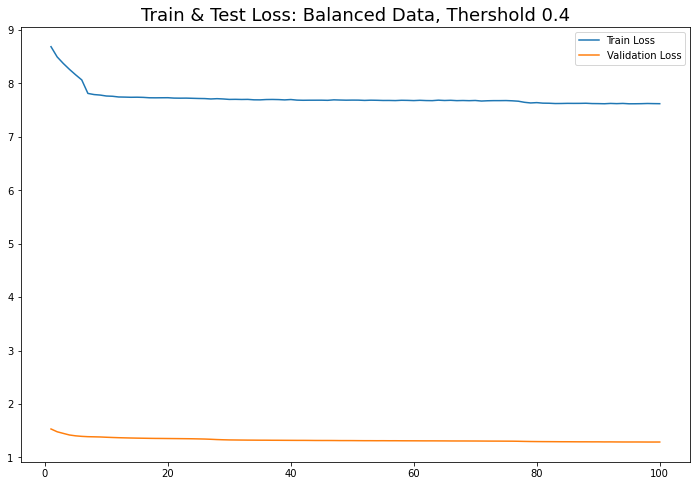

In [62]:
loss_plot(loss_train_list_T4, loss_validation_list_T4, 'Balanced Data', percent)

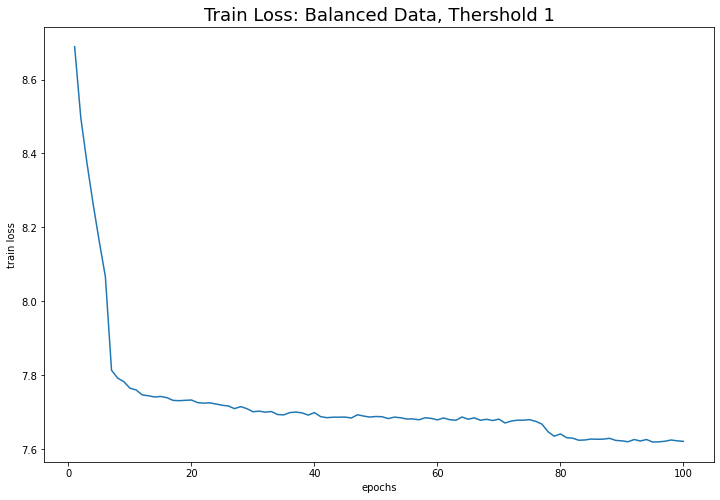

In [170]:
loss_plot_train(loss_train_list_T4, 'Balanced Data', percent)

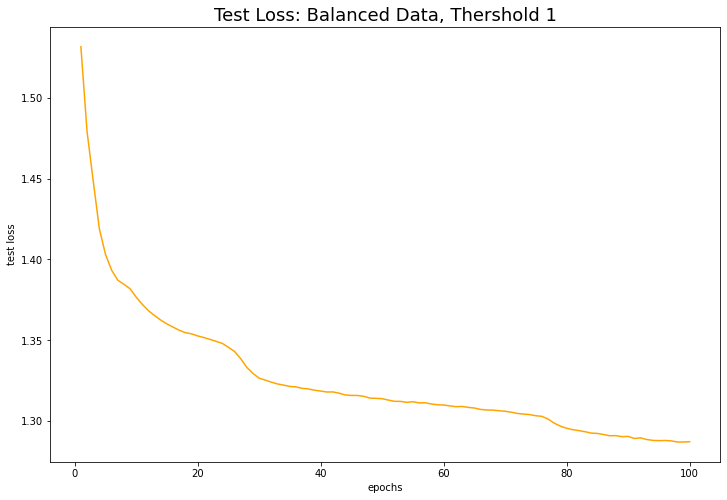

In [171]:
loss_plot_test(loss_validation_list_T4, 'Balanced Data', percent)

##### Accuracy Plot

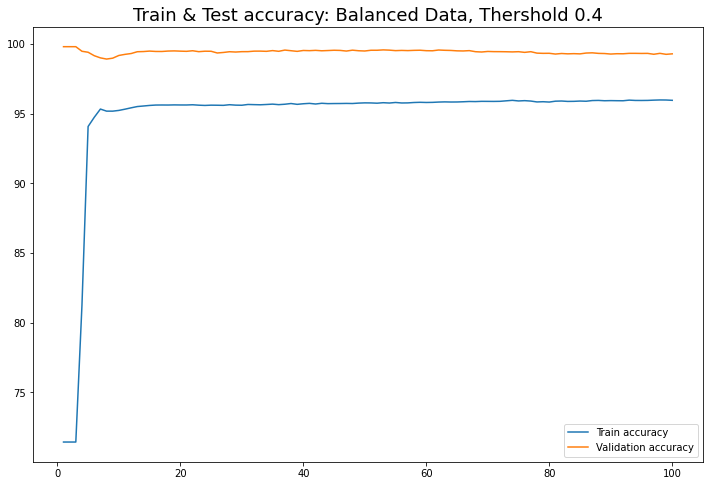

In [63]:
accuracy_plot(train_accuracy_list_T4, validation_accuracy_list_T4, 'Balanced Data', percent)

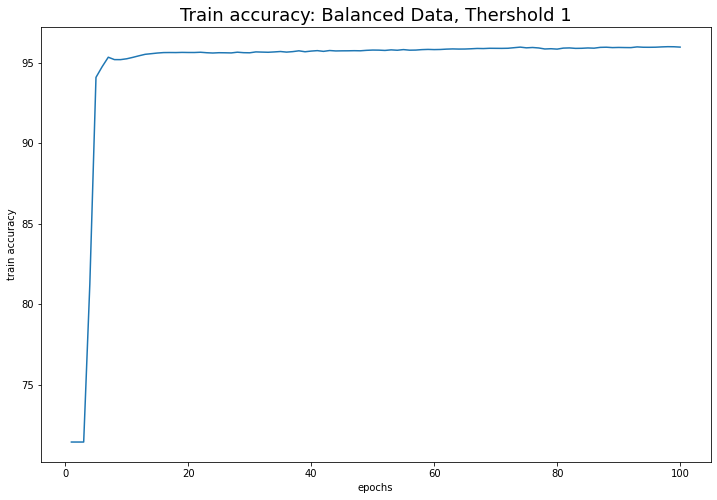

In [172]:
accuracy_plot_train(train_accuracy_list_T4, 'Balanced Data', percent)

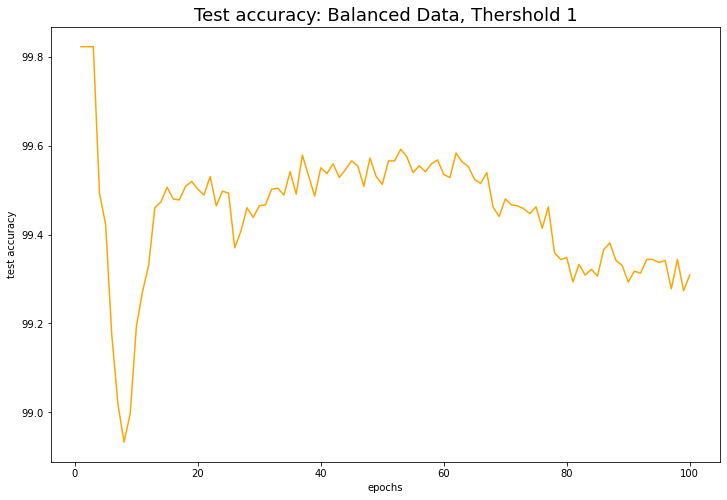

In [173]:
accuracy_plot_test(validation_accuracy_list_T4, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [64]:
y_true_T4, y_pred_T4 = predict_list(test_loader_T4, autoencoder, classifier)

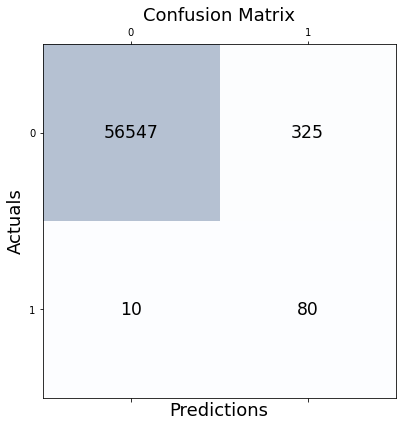

In [65]:
plot_cmx(y_true_T4, y_pred_T4)

In [66]:
accuracy_T4, recall_T4, f1_score_T4, presicion_T4 = report(test_loader_T4)

accuracy: 0.9941188862750606
recall score: 0.9415871508729154
f1 score: 0.6601394669437234
presicion: 0.5986770257122881


<hr/>
<hr/>

# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 0.5 )------!!!!!!!!!!!!!!!!!!!!!!***

In [67]:
percent = 0.5
X_train_res_T5, y_train_res_T5 = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [68]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [69]:
#Datalodaer, Threshold 0.5
train_loader_T5, validation_loader_T5, test_loader_T5 = loader(X_train_res_T5, y_train_res_T5, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [70]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [71]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [72]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [73]:
loss_train_list_T5, loss_validation_list_T5,train_accuracy_list_T5, validation_accuracy_list_T5= training_balanced_data(train_loader_T5, validation_loader_T5, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 97.35it/s, curr_loss_validation={1.6634922090329622}]


At Epoch 1/100:  Train Loss= 9.901646928472834 , Train Accuracy= 55.724 %
At Epoch 1/100: validation Loss= 1.6634922090329622 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 100.00it/s, curr_loss_validation={1.5575617112611468}]


At Epoch 2/100:  Train Loss= 9.60698252091041 , Train Accuracy= 66.667 %
At Epoch 2/100: validation Loss= 1.5575617112611468 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 115.70it/s, curr_loss_validation={1.5145426000419415}]


At Epoch 3/100:  Train Loss= 9.339605597611312 , Train Accuracy= 66.667 %
At Epoch 3/100: validation Loss= 1.5145426000419415 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 97.37it/s, curr_loss_validation={1.4913221942751032}]


At Epoch 4/100:  Train Loss= 8.938951438337892 , Train Accuracy= 66.667 %
At Epoch 4/100: validation Loss= 1.4913221942751032 , validation Accuracy= 99.822 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 97.98it/s, curr_loss_validation={1.4783121896417517}]


At Epoch 5/100:  Train Loss= 8.918383280785529 , Train Accuracy= 66.667 %
At Epoch 5/100: validation Loss= 1.4783121896417517 , validation Accuracy= 99.822 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 97.07it/s, curr_loss_validation={1.4683979600667953}]


At Epoch 6/100:  Train Loss= 8.884276826041086 , Train Accuracy= 66.667 %
At Epoch 6/100: validation Loss= 1.4683979600667953 , validation Accuracy= 99.822 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 95.23it/s, curr_loss_validation={1.4686748863835084}]


At Epoch 7/100:  Train Loss= 8.854834597451346 , Train Accuracy= 66.667 %
At Epoch 7/100: validation Loss= 1.4686748863835084 , validation Accuracy= 99.822 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 96.51it/s, curr_loss_validation={1.4367313863415467}]


At Epoch 8/100:  Train Loss= 8.684478701601972 , Train Accuracy= 88.502 %
At Epoch 8/100: validation Loss= 1.4367313863415467 , validation Accuracy= 99.028 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 95.94it/s, curr_loss_validation={1.403970545844028}]


At Epoch 9/100:  Train Loss= 8.5927679842645 , Train Accuracy= 94.623 %
At Epoch 9/100: validation Loss= 1.403970545844028 , validation Accuracy= 98.980 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 109.73it/s, curr_loss_validation={1.3850718219029277}]


At Epoch 10/100:  Train Loss= 8.554420360628065 , Train Accuracy= 94.751 %
At Epoch 10/100: validation Loss= 1.3850718219029277 , validation Accuracy= 98.975 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 97.34it/s, curr_loss_validation={1.3720892714826685}]


At Epoch 11/100:  Train Loss= 8.537284444976638 , Train Accuracy= 94.858 %
At Epoch 11/100: validation Loss= 1.3720892714826685 , validation Accuracy= 99.012 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 95.30it/s, curr_loss_validation={1.3629354120869386}]


At Epoch 12/100:  Train Loss= 8.529057589730064 , Train Accuracy= 94.901 %
At Epoch 12/100: validation Loss= 1.3629354120869386 , validation Accuracy= 99.102 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 95.38it/s, curr_loss_validation={1.3562513417319249}]


At Epoch 13/100:  Train Loss= 8.52320927630414 , Train Accuracy= 94.941 %
At Epoch 13/100: validation Loss= 1.3562513417319249 , validation Accuracy= 99.087 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 96.10it/s, curr_loss_validation={1.3495915202718032}]


At Epoch 14/100:  Train Loss= 8.518129517481878 , Train Accuracy= 94.994 %
At Epoch 14/100: validation Loss= 1.3495915202718032 , validation Accuracy= 99.155 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 95.21it/s, curr_loss_validation={1.3438093968127902}]


At Epoch 15/100:  Train Loss= 8.514579276200179 , Train Accuracy= 94.980 %
At Epoch 15/100: validation Loss= 1.3438093968127902 , validation Accuracy= 99.170 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 91.55it/s, curr_loss_validation={1.339029397619398}]


At Epoch 16/100:  Train Loss= 8.510921476175497 , Train Accuracy= 95.005 %
At Epoch 16/100: validation Loss= 1.339029397619398 , validation Accuracy= 99.195 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 99.13it/s, curr_loss_validation={1.3342608252638264}]


At Epoch 17/100:  Train Loss= 8.507751934344952 , Train Accuracy= 95.033 %
At Epoch 17/100: validation Loss= 1.3342608252638264 , validation Accuracy= 99.239 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 99.26it/s, curr_loss_validation={1.3292091402568316}]


At Epoch 18/100:  Train Loss= 8.50399592106159 , Train Accuracy= 95.034 %
At Epoch 18/100: validation Loss= 1.3292091402568316 , validation Accuracy= 99.247 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 94.58it/s, curr_loss_validation={1.324578802052297}]


At Epoch 19/100:  Train Loss= 8.501606811795916 , Train Accuracy= 95.086 %
At Epoch 19/100: validation Loss= 1.324578802052297 , validation Accuracy= 99.271 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 113.17it/s, curr_loss_validation={1.3200482796681554}]


At Epoch 20/100:  Train Loss= 8.498282906773326 , Train Accuracy= 95.097 %
At Epoch 20/100: validation Loss= 1.3200482796681554 , validation Accuracy= 99.315 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 95.93it/s, curr_loss_validation={1.3156550510933525}]


At Epoch 21/100:  Train Loss= 8.495623311891661 , Train Accuracy= 95.108 %
At Epoch 21/100: validation Loss= 1.3156550510933525 , validation Accuracy= 99.320 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 121.92it/s, curr_loss_validation={1.311639588130148}]


At Epoch 22/100:  Train Loss= 8.492698018105475 , Train Accuracy= 95.126 %
At Epoch 22/100: validation Loss= 1.311639588130148 , validation Accuracy= 99.274 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 95.42it/s, curr_loss_validation={1.3078651373323642}]


At Epoch 23/100:  Train Loss= 8.489329757795229 , Train Accuracy= 95.151 %
At Epoch 23/100: validation Loss= 1.3078651373323642 , validation Accuracy= 99.324 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 97.84it/s, curr_loss_validation={1.3037359887047817}]


At Epoch 24/100:  Train Loss= 8.48701828443087 , Train Accuracy= 95.139 %
At Epoch 24/100: validation Loss= 1.3037359887047817 , validation Accuracy= 99.335 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 91.99it/s, curr_loss_validation={1.3005273616627644}]


At Epoch 25/100:  Train Loss= 8.484455803462437 , Train Accuracy= 95.139 %
At Epoch 25/100: validation Loss= 1.3005273616627644 , validation Accuracy= 99.315 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 96.09it/s, curr_loss_validation={1.2966869653839814}]


At Epoch 26/100:  Train Loss= 8.481383620775663 , Train Accuracy= 95.195 %
At Epoch 26/100: validation Loss= 1.2966869653839814 , validation Accuracy= 99.335 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 92.44it/s, curr_loss_validation={1.2944865422813516}]


At Epoch 27/100:  Train Loss= 8.478480135215507 , Train Accuracy= 95.205 %
At Epoch 27/100: validation Loss= 1.2944865422813516 , validation Accuracy= 99.333 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 121.99it/s, curr_loss_validation={1.2914547630046542}]


At Epoch 28/100:  Train Loss= 8.475369765732314 , Train Accuracy= 95.238 %
At Epoch 28/100: validation Loss= 1.2914547630046542 , validation Accuracy= 99.353 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 123.25it/s, curr_loss_validation={1.2885720588658984}]


At Epoch 29/100:  Train Loss= 8.473079407870115 , Train Accuracy= 95.248 %
At Epoch 29/100: validation Loss= 1.2885720588658984 , validation Accuracy= 99.405 %



validation - epoch : 30: 100%|██████████| 152/152 [00:02<00:00, 55.18it/s, curr_loss_validation={1.2864795629131167}]


At Epoch 30/100:  Train Loss= 8.470754230415428 , Train Accuracy= 95.227 %
At Epoch 30/100: validation Loss= 1.2864795629131167 , validation Accuracy= 99.386 %



validation - epoch : 31: 100%|██████████| 152/152 [00:02<00:00, 63.52it/s, curr_loss_validation={1.284969245132647}]


At Epoch 31/100:  Train Loss= 8.467216799809382 , Train Accuracy= 95.263 %
At Epoch 31/100: validation Loss= 1.284969245132647 , validation Accuracy= 99.366 %



validation - epoch : 32: 100%|██████████| 152/152 [00:02<00:00, 53.09it/s, curr_loss_validation={1.2824922007949728}]


At Epoch 32/100:  Train Loss= 8.46532668543386 , Train Accuracy= 95.263 %
At Epoch 32/100: validation Loss= 1.2824922007949728 , validation Accuracy= 99.361 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 91.66it/s, curr_loss_validation={1.280904270316425}]


At Epoch 33/100:  Train Loss= 8.461911128641486 , Train Accuracy= 95.283 %
At Epoch 33/100: validation Loss= 1.280904270316425 , validation Accuracy= 99.342 %



validation - epoch : 34: 100%|██████████| 152/152 [00:02<00:00, 73.93it/s, curr_loss_validation={1.2791717758304195}]


At Epoch 34/100:  Train Loss= 8.459224637524112 , Train Accuracy= 95.310 %
At Epoch 34/100: validation Loss= 1.2791717758304195 , validation Accuracy= 99.342 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 120.72it/s, curr_loss_validation={1.2782375263540369}]


At Epoch 35/100:  Train Loss= 8.457309234011305 , Train Accuracy= 95.318 %
At Epoch 35/100: validation Loss= 1.2782375263540369 , validation Accuracy= 99.361 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 83.32it/s, curr_loss_validation={1.2779901466871564}]


At Epoch 36/100:  Train Loss= 8.455628452196226 , Train Accuracy= 95.309 %
At Epoch 36/100: validation Loss= 1.2779901466871564 , validation Accuracy= 99.337 %



validation - epoch : 37: 100%|██████████| 152/152 [00:02<00:00, 58.64it/s, curr_loss_validation={1.2759985570844852}]


At Epoch 37/100:  Train Loss= 8.454422735381913 , Train Accuracy= 95.292 %
At Epoch 37/100: validation Loss= 1.2759985570844852 , validation Accuracy= 99.333 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 125.84it/s, curr_loss_validation={1.275125534126633}]


At Epoch 38/100:  Train Loss= 8.453192315258823 , Train Accuracy= 95.305 %
At Epoch 38/100: validation Loss= 1.275125534126633 , validation Accuracy= 99.318 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 91.64it/s, curr_loss_validation={1.2741630085204776}]


At Epoch 39/100:  Train Loss= 8.451906981834998 , Train Accuracy= 95.333 %
At Epoch 39/100: validation Loss= 1.2741630085204776 , validation Accuracy= 99.315 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 128.15it/s, curr_loss_validation={1.2732234001159668}]


At Epoch 40/100:  Train Loss= 8.450508671016484 , Train Accuracy= 95.306 %
At Epoch 40/100: validation Loss= 1.2732234001159668 , validation Accuracy= 99.320 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 126.32it/s, curr_loss_validation={1.2719879244503223}]


At Epoch 41/100:  Train Loss= 8.449466165605482 , Train Accuracy= 95.308 %
At Epoch 41/100: validation Loss= 1.2719879244503223 , validation Accuracy= 99.337 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 96.98it/s, curr_loss_validation={1.271346381620357}]


At Epoch 42/100:  Train Loss= 8.448306588812189 , Train Accuracy= 95.309 %
At Epoch 42/100: validation Loss= 1.271346381620357 , validation Accuracy= 99.333 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 101.80it/s, curr_loss_validation={1.2709386089914723}]


At Epoch 43/100:  Train Loss= 8.447550696069067 , Train Accuracy= 95.348 %
At Epoch 43/100: validation Loss= 1.2709386089914723 , validation Accuracy= 99.307 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 129.88it/s, curr_loss_validation={1.2699445501754159}]


At Epoch 44/100:  Train Loss= 8.446482382763874 , Train Accuracy= 95.339 %
At Epoch 44/100: validation Loss= 1.2699445501754159 , validation Accuracy= 99.333 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 91.10it/s, curr_loss_validation={1.2694122791290283}]


At Epoch 45/100:  Train Loss= 8.445534387001624 , Train Accuracy= 95.333 %
At Epoch 45/100: validation Loss= 1.2694122791290283 , validation Accuracy= 99.302 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 114.55it/s, curr_loss_validation={1.268281680188681}]


At Epoch 46/100:  Train Loss= 8.444341993331909 , Train Accuracy= 95.322 %
At Epoch 46/100: validation Loss= 1.268281680188681 , validation Accuracy= 99.320 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 91.43it/s, curr_loss_validation={1.2674661945355565}]


At Epoch 47/100:  Train Loss= 8.443416271104917 , Train Accuracy= 95.326 %
At Epoch 47/100: validation Loss= 1.2674661945355565 , validation Accuracy= 99.291 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 116.82it/s, curr_loss_validation={1.2665997916146328}]


At Epoch 48/100:  Train Loss= 8.4431451352088 , Train Accuracy= 95.320 %
At Epoch 48/100: validation Loss= 1.2665997916146328 , validation Accuracy= 99.311 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 122.57it/s, curr_loss_validation={1.2653514829121137}]


At Epoch 49/100:  Train Loss= 8.441907087787166 , Train Accuracy= 95.354 %
At Epoch 49/100: validation Loss= 1.2653514829121137 , validation Accuracy= 99.348 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 127.61it/s, curr_loss_validation={1.2647317220505916}]


At Epoch 50/100:  Train Loss= 8.441174488801222 , Train Accuracy= 95.363 %
At Epoch 50/100: validation Loss= 1.2647317220505916 , validation Accuracy= 99.320 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 105.85it/s, curr_loss_validation={1.2635778337717056}]


At Epoch 51/100:  Train Loss= 8.440626164321062 , Train Accuracy= 95.346 %
At Epoch 51/100: validation Loss= 1.2635778337717056 , validation Accuracy= 99.322 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 117.06it/s, curr_loss_validation={1.2626797094156867}]


At Epoch 52/100:  Train Loss= 8.439168946821612 , Train Accuracy= 95.333 %
At Epoch 52/100: validation Loss= 1.2626797094156867 , validation Accuracy= 99.309 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 102.16it/s, curr_loss_validation={1.2614256284738843}]


At Epoch 53/100:  Train Loss= 8.437957302554624 , Train Accuracy= 95.361 %
At Epoch 53/100: validation Loss= 1.2614256284738843 , validation Accuracy= 99.333 %



validation - epoch : 54: 100%|██████████| 152/152 [00:02<00:00, 75.85it/s, curr_loss_validation={1.2610822723884332}]


At Epoch 54/100:  Train Loss= 8.437214681604406 , Train Accuracy= 95.359 %
At Epoch 54/100: validation Loss= 1.2610822723884332 , validation Accuracy= 99.333 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 98.14it/s, curr_loss_validation={1.2594316421370757}]


At Epoch 55/100:  Train Loss= 8.436416166431302 , Train Accuracy= 95.364 %
At Epoch 55/100: validation Loss= 1.2594316421370757 , validation Accuracy= 99.342 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 94.71it/s, curr_loss_validation={1.258599080145359}]


At Epoch 56/100:  Train Loss= 8.43490250294025 , Train Accuracy= 95.374 %
At Epoch 56/100: validation Loss= 1.258599080145359 , validation Accuracy= 99.348 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 95.70it/s, curr_loss_validation={1.257381891341586}] 


At Epoch 57/100:  Train Loss= 8.433826074495421 , Train Accuracy= 95.394 %
At Epoch 57/100: validation Loss= 1.257381891341586 , validation Accuracy= 99.403 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 116.78it/s, curr_loss_validation={1.2568484187910431}]


At Epoch 58/100:  Train Loss= 8.433361357384985 , Train Accuracy= 95.389 %
At Epoch 58/100: validation Loss= 1.2568484187910431 , validation Accuracy= 99.331 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 103.15it/s, curr_loss_validation={1.2563209980726242}]


At Epoch 59/100:  Train Loss= 8.432254806979673 , Train Accuracy= 95.390 %
At Epoch 59/100: validation Loss= 1.2563209980726242 , validation Accuracy= 99.357 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 105.89it/s, curr_loss_validation={1.2553922122246342}]


At Epoch 60/100:  Train Loss= 8.432543033033937 , Train Accuracy= 95.399 %
At Epoch 60/100: validation Loss= 1.2553922122246342 , validation Accuracy= 99.368 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 95.33it/s, curr_loss_validation={1.255283681185622}]


At Epoch 61/100:  Train Loss= 8.430879572459629 , Train Accuracy= 95.366 %
At Epoch 61/100: validation Loss= 1.255283681185622 , validation Accuracy= 99.381 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 119.44it/s, curr_loss_validation={1.2540268047075522}]


At Epoch 62/100:  Train Loss= 8.430881239293695 , Train Accuracy= 95.396 %
At Epoch 62/100: validation Loss= 1.2540268047075522 , validation Accuracy= 99.390 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 125.37it/s, curr_loss_validation={1.253805596185358}]


At Epoch 63/100:  Train Loss= 8.430009175394918 , Train Accuracy= 95.405 %
At Epoch 63/100: validation Loss= 1.253805596185358 , validation Accuracy= 99.359 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 119.34it/s, curr_loss_validation={1.252742510092886}]


At Epoch 64/100:  Train Loss= 8.429332534035483 , Train Accuracy= 95.416 %
At Epoch 64/100: validation Loss= 1.252742510092886 , validation Accuracy= 99.372 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 124.09it/s, curr_loss_validation={1.2522555174011933}]


At Epoch 65/100:  Train Loss= 8.428563324435727 , Train Accuracy= 95.412 %
At Epoch 65/100: validation Loss= 1.2522555174011933 , validation Accuracy= 99.375 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 100.11it/s, curr_loss_validation={1.251684844493866}]


At Epoch 66/100:  Train Loss= 8.42860397873344 , Train Accuracy= 95.439 %
At Epoch 66/100: validation Loss= 1.251684844493866 , validation Accuracy= 99.355 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 113.49it/s, curr_loss_validation={1.2508821605067504}]


At Epoch 67/100:  Train Loss= 8.4276310978355 , Train Accuracy= 95.416 %
At Epoch 67/100: validation Loss= 1.2508821605067504 , validation Accuracy= 99.335 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 92.88it/s, curr_loss_validation={1.2507169391763837}]


At Epoch 68/100:  Train Loss= 8.42690445983803 , Train Accuracy= 95.403 %
At Epoch 68/100: validation Loss= 1.2507169391763837 , validation Accuracy= 99.331 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 128.97it/s, curr_loss_validation={1.2499696196694123}]


At Epoch 69/100:  Train Loss= 8.426700616144872 , Train Accuracy= 95.462 %
At Epoch 69/100: validation Loss= 1.2499696196694123 , validation Accuracy= 99.355 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 96.50it/s, curr_loss_validation={1.2495085816634328}] 


At Epoch 70/100:  Train Loss= 8.425659554345268 , Train Accuracy= 95.436 %
At Epoch 70/100: validation Loss= 1.2495085816634328 , validation Accuracy= 99.315 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 114.34it/s, curr_loss_validation={1.2481383853837063}]


At Epoch 71/100:  Train Loss= 8.425479395834953 , Train Accuracy= 95.449 %
At Epoch 71/100: validation Loss= 1.2481383853837063 , validation Accuracy= 99.368 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 126.91it/s, curr_loss_validation={1.2472821191737526}]


At Epoch 72/100:  Train Loss= 8.425127772970514 , Train Accuracy= 95.466 %
At Epoch 72/100: validation Loss= 1.2472821191737526 , validation Accuracy= 99.377 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 114.96it/s, curr_loss_validation={1.2461888939142227}]


At Epoch 73/100:  Train Loss= 8.424420457357888 , Train Accuracy= 95.460 %
At Epoch 73/100: validation Loss= 1.2461888939142227 , validation Accuracy= 99.318 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 106.71it/s, curr_loss_validation={1.2449592453868765}]


At Epoch 74/100:  Train Loss= 8.42323089641529 , Train Accuracy= 95.468 %
At Epoch 74/100: validation Loss= 1.2449592453868765 , validation Accuracy= 99.331 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 94.24it/s, curr_loss_validation={1.2431284683315378}]


At Epoch 75/100:  Train Loss= 8.422739713794583 , Train Accuracy= 95.473 %
At Epoch 75/100: validation Loss= 1.2431284683315378 , validation Accuracy= 99.326 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 112.97it/s, curr_loss_validation={1.2419370997108912}]


At Epoch 76/100:  Train Loss= 8.421534604292649 , Train Accuracy= 95.477 %
At Epoch 76/100: validation Loss= 1.2419370997108912 , validation Accuracy= 99.353 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 106.15it/s, curr_loss_validation={1.2407282814383507}]


At Epoch 77/100:  Train Loss= 8.422096597231352 , Train Accuracy= 95.454 %
At Epoch 77/100: validation Loss= 1.2407282814383507 , validation Accuracy= 99.375 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 123.60it/s, curr_loss_validation={1.2400564578802962}]


At Epoch 78/100:  Train Loss= 8.420991577944912 , Train Accuracy= 95.476 %
At Epoch 78/100: validation Loss= 1.2400564578802962 , validation Accuracy= 99.339 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 118.07it/s, curr_loss_validation={1.2388817675803836}]


At Epoch 79/100:  Train Loss= 8.420294524811126 , Train Accuracy= 95.457 %
At Epoch 79/100: validation Loss= 1.2388817675803836 , validation Accuracy= 99.350 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 127.40it/s, curr_loss_validation={1.237997652276566}]


At Epoch 80/100:  Train Loss= 8.41962444808457 , Train Accuracy= 95.469 %
At Epoch 80/100: validation Loss= 1.237997652276566 , validation Accuracy= 99.368 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 128.19it/s, curr_loss_validation={1.237490676343441}]


At Epoch 81/100:  Train Loss= 8.418355212892806 , Train Accuracy= 95.508 %
At Epoch 81/100: validation Loss= 1.237490676343441 , validation Accuracy= 99.331 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 98.28it/s, curr_loss_validation={1.2363686643932994}]


At Epoch 82/100:  Train Loss= 8.41769997890179 , Train Accuracy= 95.523 %
At Epoch 82/100: validation Loss= 1.2363686643932994 , validation Accuracy= 99.359 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 130.68it/s, curr_loss_validation={1.236230503179525}]


At Epoch 83/100:  Train Loss= 8.417612594038575 , Train Accuracy= 95.504 %
At Epoch 83/100: validation Loss= 1.236230503179525 , validation Accuracy= 99.328 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 93.02it/s, curr_loss_validation={1.235915878101399}]


At Epoch 84/100:  Train Loss= 8.417511776515417 , Train Accuracy= 95.516 %
At Epoch 84/100: validation Loss= 1.235915878101399 , validation Accuracy= 99.311 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 115.56it/s, curr_loss_validation={1.2351115542022806}]


At Epoch 85/100:  Train Loss= 8.417107065431365 , Train Accuracy= 95.496 %
At Epoch 85/100: validation Loss= 1.2351115542022806 , validation Accuracy= 99.309 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 131.78it/s, curr_loss_validation={1.234711559979539}]


At Epoch 86/100:  Train Loss= 8.41695628270998 , Train Accuracy= 95.503 %
At Epoch 86/100: validation Loss= 1.234711559979539 , validation Accuracy= 99.328 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 113.55it/s, curr_loss_validation={1.2344138296811205}]


At Epoch 87/100:  Train Loss= 8.415784700624235 , Train Accuracy= 95.536 %
At Epoch 87/100: validation Loss= 1.2344138296811205 , validation Accuracy= 99.322 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 99.31it/s, curr_loss_validation={1.2339271373654668}] 


At Epoch 88/100:  Train Loss= 8.415435563076983 , Train Accuracy= 95.526 %
At Epoch 88/100: validation Loss= 1.2339271373654668 , validation Accuracy= 99.342 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 125.72it/s, curr_loss_validation={1.2335169264360477}]


At Epoch 89/100:  Train Loss= 8.415051444546206 , Train Accuracy= 95.528 %
At Epoch 89/100: validation Loss= 1.2335169264360477 , validation Accuracy= 99.339 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 126.70it/s, curr_loss_validation={1.2327120166860128}]


At Epoch 90/100:  Train Loss= 8.414623514112536 , Train Accuracy= 95.497 %
At Epoch 90/100: validation Loss= 1.2327120166860128 , validation Accuracy= 99.366 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 126.33it/s, curr_loss_validation={1.2326723772444224}]


At Epoch 91/100:  Train Loss= 8.41445733845889 , Train Accuracy= 95.543 %
At Epoch 91/100: validation Loss= 1.2326723772444224 , validation Accuracy= 99.350 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 123.49it/s, curr_loss_validation={1.2321213664192903}]


At Epoch 92/100:  Train Loss= 8.413903007402524 , Train Accuracy= 95.555 %
At Epoch 92/100: validation Loss= 1.2321213664192903 , validation Accuracy= 99.331 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 126.31it/s, curr_loss_validation={1.2315118485375454}]


At Epoch 93/100:  Train Loss= 8.413086627603887 , Train Accuracy= 95.533 %
At Epoch 93/100: validation Loss= 1.2315118485375454 , validation Accuracy= 99.355 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 99.41it/s, curr_loss_validation={1.2319731767240323}]


At Epoch 94/100:  Train Loss= 8.412627638303317 , Train Accuracy= 95.573 %
At Epoch 94/100: validation Loss= 1.2319731767240323 , validation Accuracy= 99.335 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 99.57it/s, curr_loss_validation={1.231042372552972}]


At Epoch 95/100:  Train Loss= 8.412452063193689 , Train Accuracy= 95.557 %
At Epoch 95/100: validation Loss= 1.231042372552972 , validation Accuracy= 99.364 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 133.23it/s, curr_loss_validation={1.2315912685896222}]


At Epoch 96/100:  Train Loss= 8.413393092941451 , Train Accuracy= 95.570 %
At Epoch 96/100: validation Loss= 1.2315912685896222 , validation Accuracy= 99.339 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 96.31it/s, curr_loss_validation={1.230830881940691}] 


At Epoch 97/100:  Train Loss= 8.412234084160774 , Train Accuracy= 95.549 %
At Epoch 97/100: validation Loss= 1.230830881940691 , validation Accuracy= 99.331 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 124.14it/s, curr_loss_validation={1.2302658291239488}]


At Epoch 98/100:  Train Loss= 8.412090930309924 , Train Accuracy= 95.588 %
At Epoch 98/100: validation Loss= 1.2302658291239488 , validation Accuracy= 99.328 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 119.69it/s, curr_loss_validation={1.230024855779974}]


At Epoch 99/100:  Train Loss= 8.4109238750332 , Train Accuracy= 95.556 %
At Epoch 99/100: validation Loss= 1.230024855779974 , validation Accuracy= 99.350 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 129.58it/s, curr_loss_validation={1.2296447412748086}]


At Epoch 100/100:  Train Loss= 8.411022148027525 , Train Accuracy= 95.579 %
At Epoch 100/100: validation Loss= 1.2296447412748086 , validation Accuracy= 99.390 %



#### Visualization:

##### Loss Plot

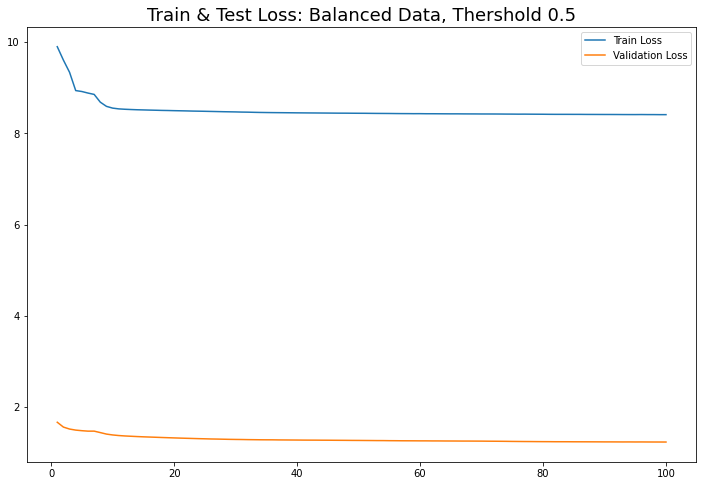

In [74]:
loss_plot(loss_train_list_T5, loss_validation_list_T5, 'Balanced Data', percent)

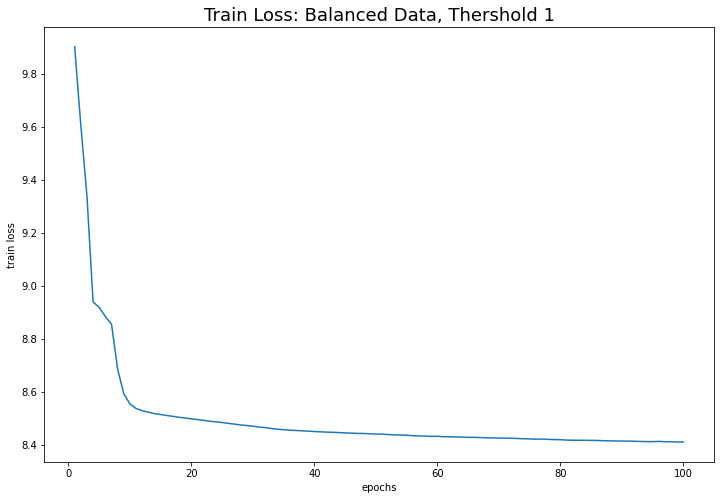

In [174]:
loss_plot_train(loss_train_list_T5, 'Balanced Data', percent)

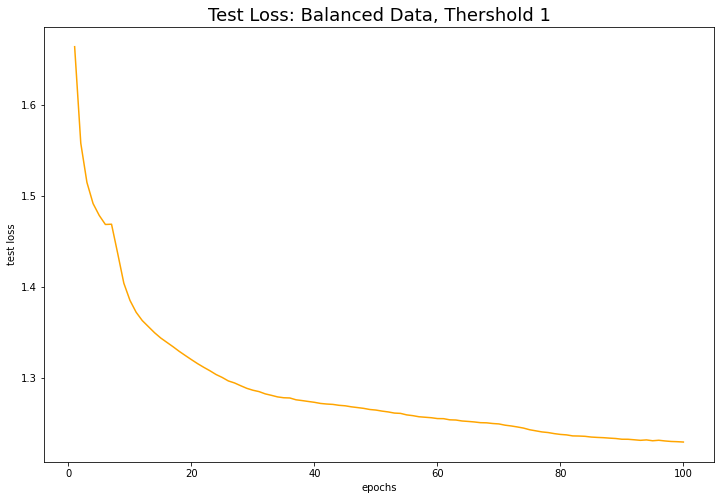

In [175]:
loss_plot_test(loss_validation_list_T5, 'Balanced Data', percent)

##### Accuracy Plot

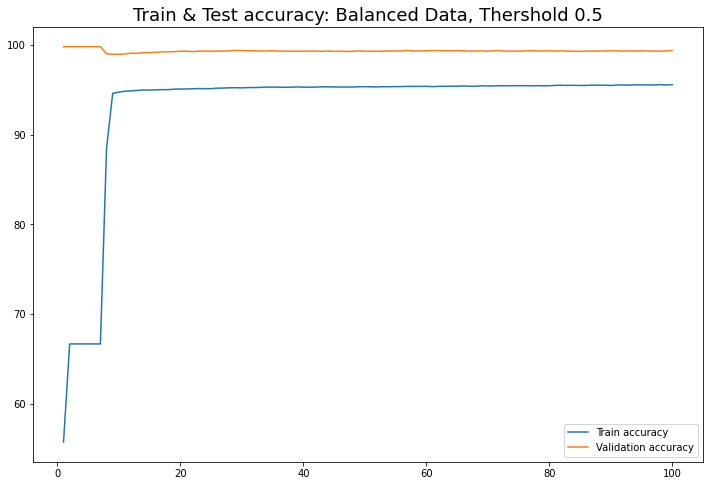

In [75]:
accuracy_plot(train_accuracy_list_T5, validation_accuracy_list_T5, 'Balanced Data', percent)

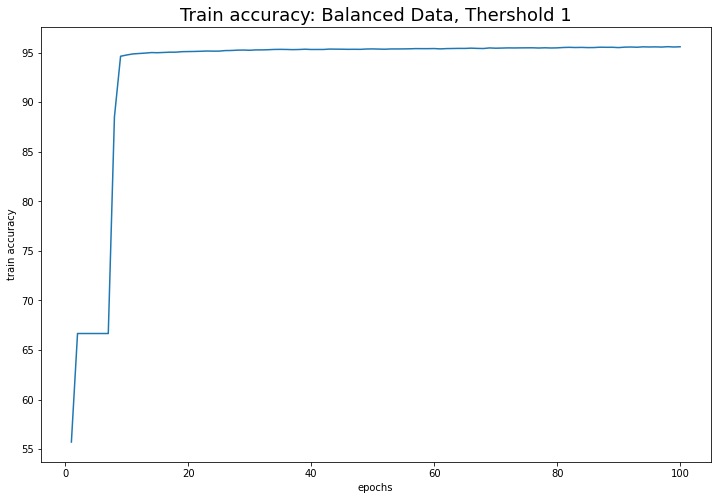

In [176]:
accuracy_plot_train(train_accuracy_list_T5, 'Balanced Data', percent)

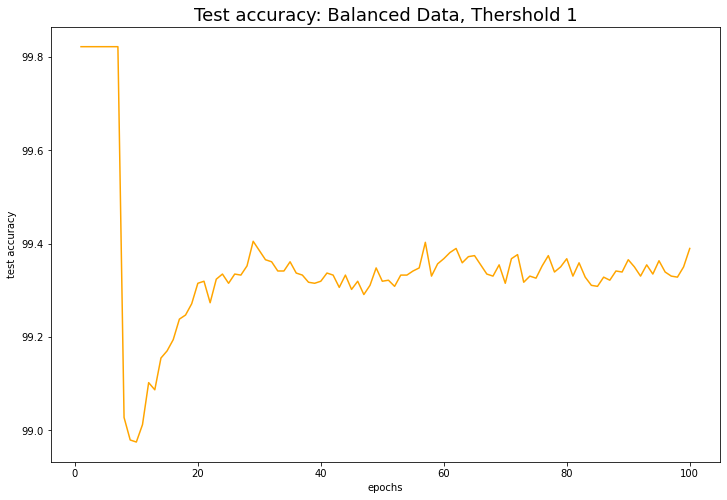

In [177]:
accuracy_plot_test(validation_accuracy_list_T5, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [76]:
y_true_T5, y_pred_T5 = predict_list(test_loader_T5, autoencoder, classifier)

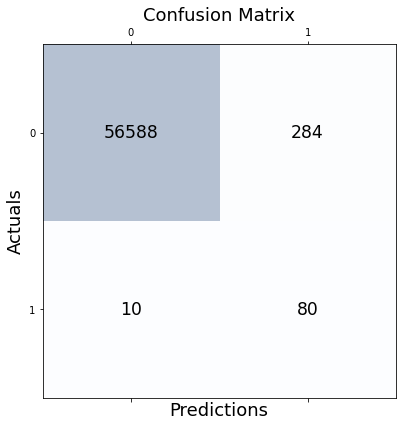

In [77]:
plot_cmx(y_true_T5, y_pred_T5)

In [78]:
accuracy_T5, recall_T5, f1_score_T5, presicion_T5 = report(test_loader_T5)

accuracy: 0.9948386643727397
recall score: 0.9419476094465544
f1 score: 0.6749159571374607
presicion: 0.6098017675458575


<hr/>
<hr/>

# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 0.6 )------!!!!!!!!!!!!!!!!!!!!!!***

In [79]:
percent = 0.6
X_train_res_T6, y_train_res_T6 = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [80]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [81]:
#Datalodaer, Threshold 0.6
train_loader_T6, validation_loader_T6, test_loader_T6 = loader(X_train_res_T6, y_train_res_T6, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [82]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [83]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [84]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [85]:
loss_train_list_T6, loss_validation_list_T6,train_accuracy_list_T6, validation_accuracy_list_T6= training_balanced_data(train_loader_T6, validation_loader_T6, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 97.72it/s, curr_loss_validation={1.651930822353614}]


At Epoch 1/100:  Train Loss= 10.383716589635974 , Train Accuracy= 53.775 %
At Epoch 1/100: validation Loss= 1.651930822353614 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 92.21it/s, curr_loss_validation={1.5697803340460126}]


At Epoch 2/100:  Train Loss= 10.088599574799149 , Train Accuracy= 62.500 %
At Epoch 2/100: validation Loss= 1.5697803340460126 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 93.89it/s, curr_loss_validation={1.5063130494795347}]


At Epoch 3/100:  Train Loss= 10.003054115480056 , Train Accuracy= 62.500 %
At Epoch 3/100: validation Loss= 1.5063130494795347 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 94.45it/s, curr_loss_validation={1.4340123463618129}]


At Epoch 4/100:  Train Loss= 9.925415030223089 , Train Accuracy= 62.500 %
At Epoch 4/100: validation Loss= 1.4340123463618129 , validation Accuracy= 99.822 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 103.03it/s, curr_loss_validation={1.3922934814503318}]


At Epoch 5/100:  Train Loss= 9.820852433370636 , Train Accuracy= 91.325 %
At Epoch 5/100: validation Loss= 1.3922934814503318 , validation Accuracy= 99.522 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 94.93it/s, curr_loss_validation={1.376960702632603}] 


At Epoch 6/100:  Train Loss= 9.761667254042306 , Train Accuracy= 94.156 %
At Epoch 6/100: validation Loss= 1.376960702632603 , validation Accuracy= 99.296 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 93.43it/s, curr_loss_validation={1.3688532561063766}]


At Epoch 7/100:  Train Loss= 9.730476436850708 , Train Accuracy= 94.393 %
At Epoch 7/100: validation Loss= 1.3688532561063766 , validation Accuracy= 99.263 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 93.19it/s, curr_loss_validation={1.364482816112669}]


At Epoch 8/100:  Train Loss= 9.716737306695029 , Train Accuracy= 94.480 %
At Epoch 8/100: validation Loss= 1.364482816112669 , validation Accuracy= 99.267 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 95.53it/s, curr_loss_validation={1.3624346562122043}]


At Epoch 9/100:  Train Loss= 9.709328585132635 , Train Accuracy= 94.533 %
At Epoch 9/100: validation Loss= 1.3624346562122043 , validation Accuracy= 99.177 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 95.55it/s, curr_loss_validation={1.359645537639919}]


At Epoch 10/100:  Train Loss= 9.702179333208518 , Train Accuracy= 94.539 %
At Epoch 10/100: validation Loss= 1.359645537639919 , validation Accuracy= 99.236 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 95.25it/s, curr_loss_validation={1.3577391764051037}]


At Epoch 11/100:  Train Loss= 9.695684671647516 , Train Accuracy= 94.577 %
At Epoch 11/100: validation Loss= 1.3577391764051037 , validation Accuracy= 99.192 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 92.69it/s, curr_loss_validation={1.353046058824188}]


At Epoch 12/100:  Train Loss= 9.678431093017547 , Train Accuracy= 94.619 %
At Epoch 12/100: validation Loss= 1.353046058824188 , validation Accuracy= 99.168 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 93.08it/s, curr_loss_validation={1.347097618015189}]


At Epoch 13/100:  Train Loss= 9.642247300192206 , Train Accuracy= 94.624 %
At Epoch 13/100: validation Loss= 1.347097618015189 , validation Accuracy= 99.160 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 89.05it/s, curr_loss_validation={1.344245331067788}]


At Epoch 14/100:  Train Loss= 9.628445328202725 , Train Accuracy= 94.611 %
At Epoch 14/100: validation Loss= 1.344245331067788 , validation Accuracy= 99.151 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 93.97it/s, curr_loss_validation={1.341542705109245}]


At Epoch 15/100:  Train Loss= 9.619850990578271 , Train Accuracy= 94.630 %
At Epoch 15/100: validation Loss= 1.341542705109245 , validation Accuracy= 99.160 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 103.17it/s, curr_loss_validation={1.339274195464034}]


At Epoch 16/100:  Train Loss= 9.612897675020196 , Train Accuracy= 94.650 %
At Epoch 16/100: validation Loss= 1.339274195464034 , validation Accuracy= 99.177 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 93.45it/s, curr_loss_validation={1.3376851685737308}]


At Epoch 17/100:  Train Loss= 9.613386001449411 , Train Accuracy= 94.662 %
At Epoch 17/100: validation Loss= 1.3376851685737308 , validation Accuracy= 99.212 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 93.30it/s, curr_loss_validation={1.3368304928666668}]


At Epoch 18/100:  Train Loss= 9.610362386359736 , Train Accuracy= 94.673 %
At Epoch 18/100: validation Loss= 1.3368304928666668 , validation Accuracy= 99.199 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 93.56it/s, curr_loss_validation={1.3345958645406522}]


At Epoch 19/100:  Train Loss= 9.608975339255053 , Train Accuracy= 94.692 %
At Epoch 19/100: validation Loss= 1.3345958645406522 , validation Accuracy= 99.278 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 105.61it/s, curr_loss_validation={1.3335630634897633}]


At Epoch 20/100:  Train Loss= 9.603683172612921 , Train Accuracy= 94.696 %
At Epoch 20/100: validation Loss= 1.3335630634897633 , validation Accuracy= 99.243 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 123.57it/s, curr_loss_validation={1.3318664839393215}]


At Epoch 21/100:  Train Loss= 9.603785294337326 , Train Accuracy= 94.715 %
At Epoch 21/100: validation Loss= 1.3318664839393215 , validation Accuracy= 99.271 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 96.41it/s, curr_loss_validation={1.329769781545589}] 


At Epoch 22/100:  Train Loss= 9.600137219001779 , Train Accuracy= 94.742 %
At Epoch 22/100: validation Loss= 1.329769781545589 , validation Accuracy= 99.331 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 92.33it/s, curr_loss_validation={1.3287721982127743}]


At Epoch 23/100:  Train Loss= 9.59808860036298 , Train Accuracy= 94.782 %
At Epoch 23/100: validation Loss= 1.3287721982127743 , validation Accuracy= 99.263 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 92.00it/s, curr_loss_validation={1.3273005822771473}]


At Epoch 24/100:  Train Loss= 9.596492582197415 , Train Accuracy= 94.774 %
At Epoch 24/100: validation Loss= 1.3273005822771473 , validation Accuracy= 99.243 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 95.24it/s, curr_loss_validation={1.3250718618694104}]


At Epoch 25/100:  Train Loss= 9.595316276982443 , Train Accuracy= 94.777 %
At Epoch 25/100: validation Loss= 1.3250718618694104 , validation Accuracy= 99.282 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 109.18it/s, curr_loss_validation={1.3233170305427753}]


At Epoch 26/100:  Train Loss= 9.593887958664114 , Train Accuracy= 94.759 %
At Epoch 26/100: validation Loss= 1.3233170305427753 , validation Accuracy= 99.313 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 92.60it/s, curr_loss_validation={1.3215315726242567}]


At Epoch 27/100:  Train Loss= 9.590482866972778 , Train Accuracy= 94.773 %
At Epoch 27/100: validation Loss= 1.3215315726242567 , validation Accuracy= 99.335 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 95.38it/s, curr_loss_validation={1.319727166702873}] 


At Epoch 28/100:  Train Loss= 9.589044744273538 , Train Accuracy= 94.812 %
At Epoch 28/100: validation Loss= 1.319727166702873 , validation Accuracy= 99.364 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 119.57it/s, curr_loss_validation={1.317719446985345}]


At Epoch 29/100:  Train Loss= 9.584130715881882 , Train Accuracy= 94.809 %
At Epoch 29/100: validation Loss= 1.317719446985345 , validation Accuracy= 99.359 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 93.52it/s, curr_loss_validation={1.3156087484798933}]


At Epoch 30/100:  Train Loss= 9.58244521684185 , Train Accuracy= 94.826 %
At Epoch 30/100: validation Loss= 1.3156087484798933 , validation Accuracy= 99.364 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 89.24it/s, curr_loss_validation={1.3133591789948313}]


At Epoch 31/100:  Train Loss= 9.582002405526096 , Train Accuracy= 94.801 %
At Epoch 31/100: validation Loss= 1.3133591789948313 , validation Accuracy= 99.276 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 99.64it/s, curr_loss_validation={1.310702727029198}]


At Epoch 32/100:  Train Loss= 9.575815189019782 , Train Accuracy= 94.793 %
At Epoch 32/100: validation Loss= 1.310702727029198 , validation Accuracy= 99.280 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 96.08it/s, curr_loss_validation={1.3079400988001573}]


At Epoch 33/100:  Train Loss= 9.574933461131323 , Train Accuracy= 94.786 %
At Epoch 33/100: validation Loss= 1.3079400988001573 , validation Accuracy= 99.287 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 120.21it/s, curr_loss_validation={1.305670208052585}]


At Epoch 34/100:  Train Loss= 9.573735334355112 , Train Accuracy= 94.775 %
At Epoch 34/100: validation Loss= 1.305670208052585 , validation Accuracy= 99.177 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 102.33it/s, curr_loss_validation={1.300453926387586}]


At Epoch 35/100:  Train Loss= 9.571255439832944 , Train Accuracy= 94.744 %
At Epoch 35/100: validation Loss= 1.300453926387586 , validation Accuracy= 99.287 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 106.13it/s, curr_loss_validation={1.2969033420085907}]


At Epoch 36/100:  Train Loss= 9.567488611419709 , Train Accuracy= 94.790 %
At Epoch 36/100: validation Loss= 1.2969033420085907 , validation Accuracy= 99.219 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 120.76it/s, curr_loss_validation={1.2916987985372543}]


At Epoch 37/100:  Train Loss= 9.562495834181655 , Train Accuracy= 94.760 %
At Epoch 37/100: validation Loss= 1.2916987985372543 , validation Accuracy= 99.291 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 92.54it/s, curr_loss_validation={1.2872634177145206}]


At Epoch 38/100:  Train Loss= 9.559377192959849 , Train Accuracy= 94.786 %
At Epoch 38/100: validation Loss= 1.2872634177145206 , validation Accuracy= 99.320 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 120.62it/s, curr_loss_validation={1.283689096570015}]


At Epoch 39/100:  Train Loss= 9.555550447575955 , Train Accuracy= 94.804 %
At Epoch 39/100: validation Loss= 1.283689096570015 , validation Accuracy= 99.331 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 105.43it/s, curr_loss_validation={1.281106000668124}]


At Epoch 40/100:  Train Loss= 9.552813306036496 , Train Accuracy= 94.828 %
At Epoch 40/100: validation Loss= 1.281106000668124 , validation Accuracy= 99.318 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 92.11it/s, curr_loss_validation={1.278436394898515}]


At Epoch 41/100:  Train Loss= 9.55160504733006 , Train Accuracy= 94.831 %
At Epoch 41/100: validation Loss= 1.278436394898515 , validation Accuracy= 99.355 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 128.04it/s, curr_loss_validation={1.2767194403629554}]


At Epoch 42/100:  Train Loss= 9.551099224267364 , Train Accuracy= 94.869 %
At Epoch 42/100: validation Loss= 1.2767194403629554 , validation Accuracy= 99.331 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 113.29it/s, curr_loss_validation={1.2749001909243434}]


At Epoch 43/100:  Train Loss= 9.549887960651999 , Train Accuracy= 94.844 %
At Epoch 43/100: validation Loss= 1.2749001909243434 , validation Accuracy= 99.357 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 100.34it/s, curr_loss_validation={1.2735667636519985}]


At Epoch 44/100:  Train Loss= 9.549784739402984 , Train Accuracy= 94.859 %
At Epoch 44/100: validation Loss= 1.2735667636519985 , validation Accuracy= 99.304 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 125.77it/s, curr_loss_validation={1.2713604083186703}]


At Epoch 45/100:  Train Loss= 9.544810563233805 , Train Accuracy= 94.830 %
At Epoch 45/100: validation Loss= 1.2713604083186703 , validation Accuracy= 99.258 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 114.34it/s, curr_loss_validation={1.268715553377804}]


At Epoch 46/100:  Train Loss= 9.54343322671405 , Train Accuracy= 94.852 %
At Epoch 46/100: validation Loss= 1.268715553377804 , validation Accuracy= 99.247 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 121.75it/s, curr_loss_validation={1.2658219086496454}]


At Epoch 47/100:  Train Loss= 9.543493627396966 , Train Accuracy= 94.850 %
At Epoch 47/100: validation Loss= 1.2658219086496454 , validation Accuracy= 99.276 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 102.00it/s, curr_loss_validation={1.2641691847851402}]


At Epoch 48/100:  Train Loss= 9.54062083477095 , Train Accuracy= 94.853 %
At Epoch 48/100: validation Loss= 1.2641691847851402 , validation Accuracy= 99.241 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 106.19it/s, curr_loss_validation={1.2606374111614729}]


At Epoch 49/100:  Train Loss= 9.539147782644946 , Train Accuracy= 94.878 %
At Epoch 49/100: validation Loss= 1.2606374111614729 , validation Accuracy= 99.282 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 95.14it/s, curr_loss_validation={1.258301181620673}]


At Epoch 50/100:  Train Loss= 9.539693782798539 , Train Accuracy= 94.871 %
At Epoch 50/100: validation Loss= 1.258301181620673 , validation Accuracy= 99.287 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 126.16it/s, curr_loss_validation={1.2564770187202252}]


At Epoch 51/100:  Train Loss= 9.540160559723969 , Train Accuracy= 94.890 %
At Epoch 51/100: validation Loss= 1.2564770187202252 , validation Accuracy= 99.280 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 112.44it/s, curr_loss_validation={1.255485593488342}]


At Epoch 52/100:  Train Loss= 9.536467773170353 , Train Accuracy= 94.874 %
At Epoch 52/100: validation Loss= 1.255485593488342 , validation Accuracy= 99.225 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 112.53it/s, curr_loss_validation={1.2539676592538231}]


At Epoch 53/100:  Train Loss= 9.53541966103378 , Train Accuracy= 94.886 %
At Epoch 53/100: validation Loss= 1.2539676592538231 , validation Accuracy= 99.214 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 108.13it/s, curr_loss_validation={1.252150065020511}]


At Epoch 54/100:  Train Loss= 9.532413085383563 , Train Accuracy= 94.907 %
At Epoch 54/100: validation Loss= 1.252150065020511 , validation Accuracy= 99.252 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 121.37it/s, curr_loss_validation={1.2505044756751311}]


At Epoch 55/100:  Train Loss= 9.531888368569245 , Train Accuracy= 94.922 %
At Epoch 55/100: validation Loss= 1.2505044756751311 , validation Accuracy= 99.269 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 116.53it/s, curr_loss_validation={1.2489242428227474}]


At Epoch 56/100:  Train Loss= 9.53206112014032 , Train Accuracy= 94.954 %
At Epoch 56/100: validation Loss= 1.2489242428227474 , validation Accuracy= 99.271 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 121.53it/s, curr_loss_validation={1.248061593818037}]


At Epoch 57/100:  Train Loss= 9.532149283451352 , Train Accuracy= 94.927 %
At Epoch 57/100: validation Loss= 1.248061593818037 , validation Accuracy= 99.254 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 112.83it/s, curr_loss_validation={1.2471458755041425}]


At Epoch 58/100:  Train Loss= 9.53044584875372 , Train Accuracy= 94.924 %
At Epoch 58/100: validation Loss= 1.2471458755041425 , validation Accuracy= 99.267 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 107.75it/s, curr_loss_validation={1.2467734688206722}]


At Epoch 59/100:  Train Loss= 9.531707301075992 , Train Accuracy= 94.973 %
At Epoch 59/100: validation Loss= 1.2467734688206722 , validation Accuracy= 99.267 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 90.27it/s, curr_loss_validation={1.246028763291083}]


At Epoch 60/100:  Train Loss= 9.529059273084332 , Train Accuracy= 94.942 %
At Epoch 60/100: validation Loss= 1.246028763291083 , validation Accuracy= 99.228 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 127.75it/s, curr_loss_validation={1.2448072582483292}]


At Epoch 61/100:  Train Loss= 9.527196309593506 , Train Accuracy= 94.955 %
At Epoch 61/100: validation Loss= 1.2448072582483292 , validation Accuracy= 99.285 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 107.84it/s, curr_loss_validation={1.2448127042306096}]


At Epoch 62/100:  Train Loss= 9.528996133165919 , Train Accuracy= 94.968 %
At Epoch 62/100: validation Loss= 1.2448127042306096 , validation Accuracy= 99.249 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 129.91it/s, curr_loss_validation={1.2442181926024587}]


At Epoch 63/100:  Train Loss= 9.52521564442392 , Train Accuracy= 94.973 %
At Epoch 63/100: validation Loss= 1.2442181926024587 , validation Accuracy= 99.230 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 99.81it/s, curr_loss_validation={1.243751314125563}]


At Epoch 64/100:  Train Loss= 9.524665888993551 , Train Accuracy= 94.982 %
At Epoch 64/100: validation Loss= 1.243751314125563 , validation Accuracy= 99.243 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 123.10it/s, curr_loss_validation={1.2428424546593113}]


At Epoch 65/100:  Train Loss= 9.525853675131204 , Train Accuracy= 95.001 %
At Epoch 65/100: validation Loss= 1.2428424546593113 , validation Accuracy= 99.252 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 115.69it/s, curr_loss_validation={1.242275856043163}]


At Epoch 66/100:  Train Loss= 9.52372544531228 , Train Accuracy= 95.004 %
At Epoch 66/100: validation Loss= 1.242275856043163 , validation Accuracy= 99.243 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 114.51it/s, curr_loss_validation={1.242289710593851}]


At Epoch 67/100:  Train Loss= 9.525193054324935 , Train Accuracy= 95.008 %
At Epoch 67/100: validation Loss= 1.242289710593851 , validation Accuracy= 99.212 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 120.14it/s, curr_loss_validation={1.2418173869189464}]


At Epoch 68/100:  Train Loss= 9.522877581701465 , Train Accuracy= 95.015 %
At Epoch 68/100: validation Loss= 1.2418173869189464 , validation Accuracy= 99.203 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 125.58it/s, curr_loss_validation={1.2404660355103643}]


At Epoch 69/100:  Train Loss= 9.52247156247297 , Train Accuracy= 95.040 %
At Epoch 69/100: validation Loss= 1.2404660355103643 , validation Accuracy= 99.256 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 105.71it/s, curr_loss_validation={1.2407005762583332}]


At Epoch 70/100:  Train Loss= 9.522798489591242 , Train Accuracy= 95.055 %
At Epoch 70/100: validation Loss= 1.2407005762583332 , validation Accuracy= 99.223 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 123.76it/s, curr_loss_validation={1.2396943977004604}]


At Epoch 71/100:  Train Loss= 9.524432713167798 , Train Accuracy= 95.023 %
At Epoch 71/100: validation Loss= 1.2396943977004604 , validation Accuracy= 99.245 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 130.09it/s, curr_loss_validation={1.2394471862598468}]


At Epoch 72/100:  Train Loss= 9.523541961713137 , Train Accuracy= 95.026 %
At Epoch 72/100: validation Loss= 1.2394471862598468 , validation Accuracy= 99.239 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 130.28it/s, curr_loss_validation={1.239026057092767}]


At Epoch 73/100:  Train Loss= 9.521021013033991 , Train Accuracy= 95.017 %
At Epoch 73/100: validation Loss= 1.239026057092767 , validation Accuracy= 99.258 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 122.86it/s, curr_loss_validation={1.2382884284383373}]


At Epoch 74/100:  Train Loss= 9.521436525790747 , Train Accuracy= 95.041 %
At Epoch 74/100: validation Loss= 1.2382884284383373 , validation Accuracy= 99.260 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 103.40it/s, curr_loss_validation={1.2380719067234742}]


At Epoch 75/100:  Train Loss= 9.519499606379028 , Train Accuracy= 95.048 %
At Epoch 75/100: validation Loss= 1.2380719067234742 , validation Accuracy= 99.243 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 133.17it/s, curr_loss_validation={1.2374218502327015}]


At Epoch 76/100:  Train Loss= 9.521807854256595 , Train Accuracy= 95.072 %
At Epoch 76/100: validation Loss= 1.2374218502327015 , validation Accuracy= 99.241 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 121.81it/s, curr_loss_validation={1.237190897527494}]


At Epoch 77/100:  Train Loss= 9.52041847944014 , Train Accuracy= 95.070 %
At Epoch 77/100: validation Loss= 1.237190897527494 , validation Accuracy= 99.256 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 119.26it/s, curr_loss_validation={1.2367828488349915}]


At Epoch 78/100:  Train Loss= 9.518358341083468 , Train Accuracy= 95.074 %
At Epoch 78/100: validation Loss= 1.2367828488349915 , validation Accuracy= 99.285 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 125.65it/s, curr_loss_validation={1.2367014202632403}]


At Epoch 79/100:  Train Loss= 9.51603990676597 , Train Accuracy= 95.085 %
At Epoch 79/100: validation Loss= 1.2367014202632403 , validation Accuracy= 99.241 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 117.79it/s, curr_loss_validation={1.2361566981202678}]


At Epoch 80/100:  Train Loss= 9.516145712069699 , Train Accuracy= 95.084 %
At Epoch 80/100: validation Loss= 1.2361566981202678 , validation Accuracy= 99.260 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 131.54it/s, curr_loss_validation={1.236114190989419}]


At Epoch 81/100:  Train Loss= 9.518612474663495 , Train Accuracy= 95.066 %
At Epoch 81/100: validation Loss= 1.236114190989419 , validation Accuracy= 99.252 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 100.72it/s, curr_loss_validation={1.2356785539733737}]


At Epoch 82/100:  Train Loss= 9.515685201796149 , Train Accuracy= 95.084 %
At Epoch 82/100: validation Loss= 1.2356785539733737 , validation Accuracy= 99.254 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 101.54it/s, curr_loss_validation={1.234986930301315}]


At Epoch 83/100:  Train Loss= 9.51496233336098 , Train Accuracy= 95.063 %
At Epoch 83/100: validation Loss= 1.234986930301315 , validation Accuracy= 99.252 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 124.13it/s, curr_loss_validation={1.2347350140151225}]


At Epoch 84/100:  Train Loss= 9.51509492551998 , Train Accuracy= 95.043 %
At Epoch 84/100: validation Loss= 1.2347350140151225 , validation Accuracy= 99.269 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 113.78it/s, curr_loss_validation={1.2333837700517554}]


At Epoch 85/100:  Train Loss= 9.514324585023795 , Train Accuracy= 95.097 %
At Epoch 85/100: validation Loss= 1.2333837700517554 , validation Accuracy= 99.320 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 126.83it/s, curr_loss_validation={1.233239848362772}]


At Epoch 86/100:  Train Loss= 9.514430111886053 , Train Accuracy= 95.093 %
At Epoch 86/100: validation Loss= 1.233239848362772 , validation Accuracy= 99.256 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 131.70it/s, curr_loss_validation={1.232954273882665}]


At Epoch 87/100:  Train Loss= 9.513760396798288 , Train Accuracy= 95.117 %
At Epoch 87/100: validation Loss= 1.232954273882665 , validation Accuracy= 99.239 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 97.84it/s, curr_loss_validation={1.2324506326725608}]


At Epoch 88/100:  Train Loss= 9.513710116259716 , Train Accuracy= 95.112 %
At Epoch 88/100: validation Loss= 1.2324506326725608 , validation Accuracy= 99.245 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 131.09it/s, curr_loss_validation={1.2319670550917323}]


At Epoch 89/100:  Train Loss= 9.512624608500488 , Train Accuracy= 95.153 %
At Epoch 89/100: validation Loss= 1.2319670550917323 , validation Accuracy= 99.263 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 108.03it/s, curr_loss_validation={1.231673987288224}]


At Epoch 90/100:  Train Loss= 9.512892796254183 , Train Accuracy= 95.121 %
At Epoch 90/100: validation Loss= 1.231673987288224 , validation Accuracy= 99.258 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 122.03it/s, curr_loss_validation={1.2307306386922534}]


At Epoch 91/100:  Train Loss= 9.513768953839978 , Train Accuracy= 95.105 %
At Epoch 91/100: validation Loss= 1.2307306386922534 , validation Accuracy= 99.232 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 121.11it/s, curr_loss_validation={1.2299882424505133}]


At Epoch 92/100:  Train Loss= 9.511873398455728 , Train Accuracy= 95.131 %
At Epoch 92/100: validation Loss= 1.2299882424505133 , validation Accuracy= 99.219 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 92.64it/s, curr_loss_validation={1.2283131860588725}]


At Epoch 93/100:  Train Loss= 9.510033731234675 , Train Accuracy= 95.132 %
At Epoch 93/100: validation Loss= 1.2283131860588725 , validation Accuracy= 99.265 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 126.60it/s, curr_loss_validation={1.2274425453261326}]


At Epoch 94/100:  Train Loss= 9.511000360691217 , Train Accuracy= 95.129 %
At Epoch 94/100: validation Loss= 1.2274425453261326 , validation Accuracy= 99.249 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 92.54it/s, curr_loss_validation={1.226346085338216}]


At Epoch 95/100:  Train Loss= 9.510825217077096 , Train Accuracy= 95.156 %
At Epoch 95/100: validation Loss= 1.226346085338216 , validation Accuracy= 99.217 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 93.67it/s, curr_loss_validation={1.224492880858873}]


At Epoch 96/100:  Train Loss= 9.507395798833436 , Train Accuracy= 95.137 %
At Epoch 96/100: validation Loss= 1.224492880858873 , validation Accuracy= 99.232 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 90.92it/s, curr_loss_validation={1.2228232382943756}]


At Epoch 97/100:  Train Loss= 9.509718773662124 , Train Accuracy= 95.149 %
At Epoch 97/100: validation Loss= 1.2228232382943756 , validation Accuracy= 99.234 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 91.98it/s, curr_loss_validation={1.2220860468713861}]


At Epoch 98/100:  Train Loss= 9.505211960274945 , Train Accuracy= 95.173 %
At Epoch 98/100: validation Loss= 1.2220860468713861 , validation Accuracy= 99.195 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 111.55it/s, curr_loss_validation={1.2199234978148812}]


At Epoch 99/100:  Train Loss= 9.504753954010324 , Train Accuracy= 95.179 %
At Epoch 99/100: validation Loss= 1.2199234978148812 , validation Accuracy= 99.195 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 93.41it/s, curr_loss_validation={1.2178415369830633}]


At Epoch 100/100:  Train Loss= 9.50414282359743 , Train Accuracy= 95.175 %
At Epoch 100/100: validation Loss= 1.2178415369830633 , validation Accuracy= 99.223 %



#### Visualization:

##### Loss Plot

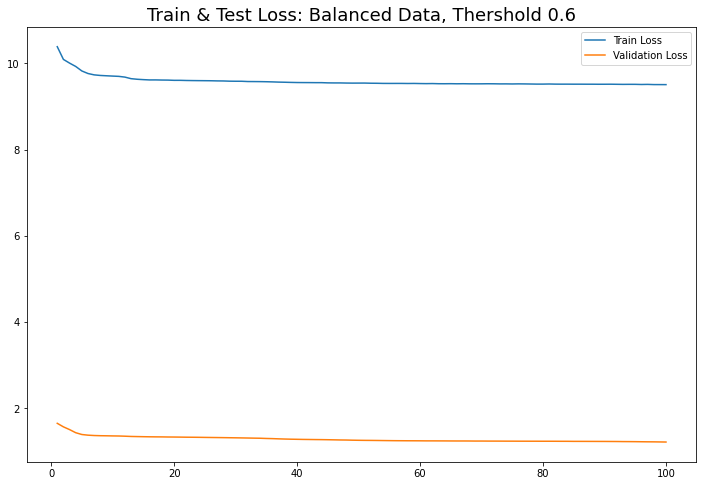

In [86]:
loss_plot(loss_train_list_T6, loss_validation_list_T6, 'Balanced Data', percent)

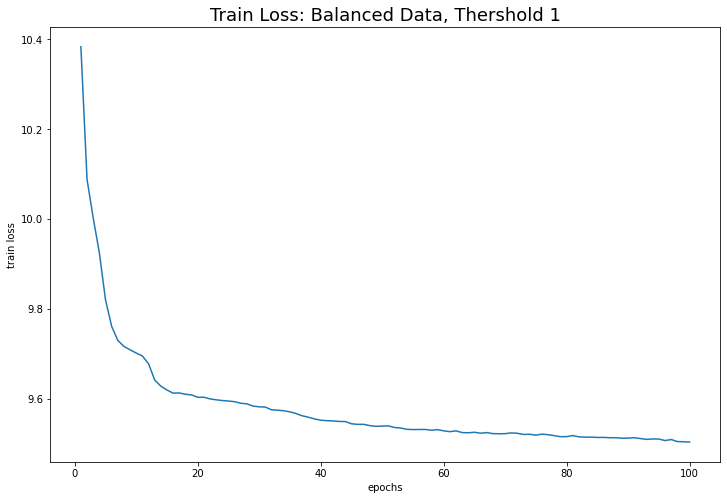

In [178]:
loss_plot_train(loss_train_list_T6, 'Balanced Data', percent)

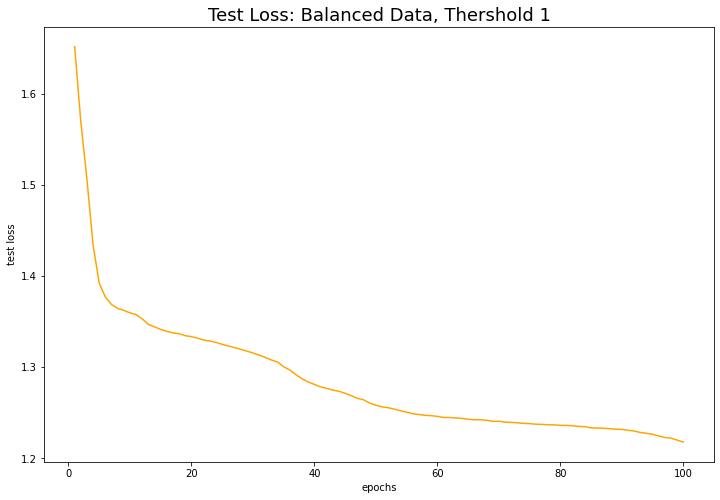

In [179]:
loss_plot_test(loss_validation_list_T6, 'Balanced Data', percent)

##### Accuracy Plot

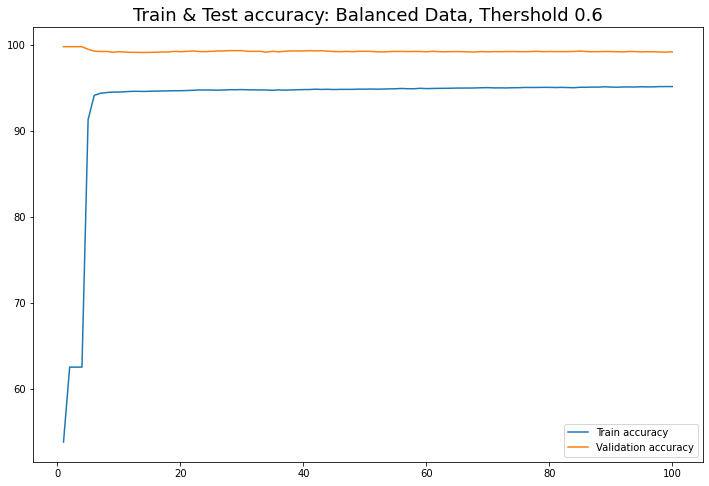

In [87]:
accuracy_plot(train_accuracy_list_T6, validation_accuracy_list_T6, 'Balanced Data', percent)

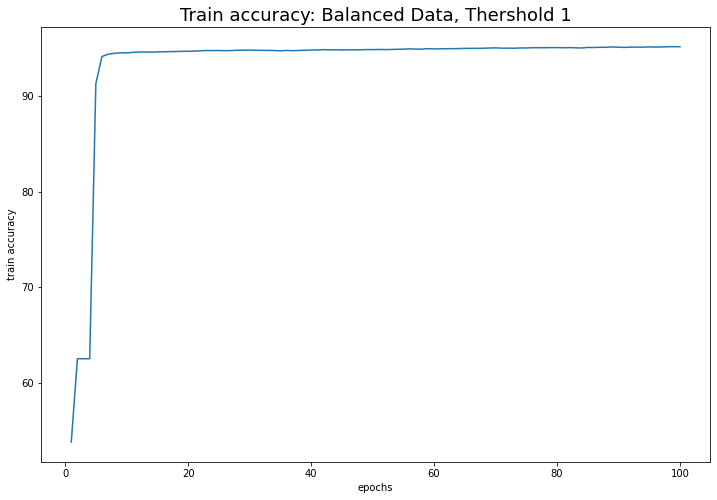

In [180]:
accuracy_plot_train(train_accuracy_list_T6, 'Balanced Data', percent)

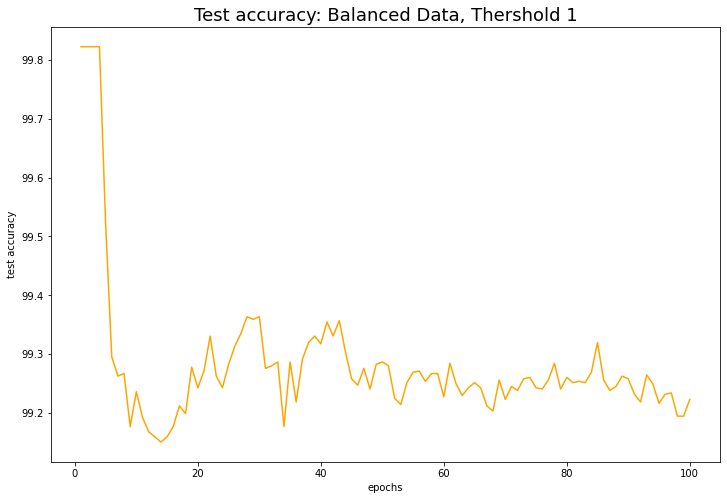

In [181]:
accuracy_plot_test(validation_accuracy_list_T6, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [88]:
y_true_T6, y_pred_T6 = predict_list(test_loader_T6, autoencoder, classifier)

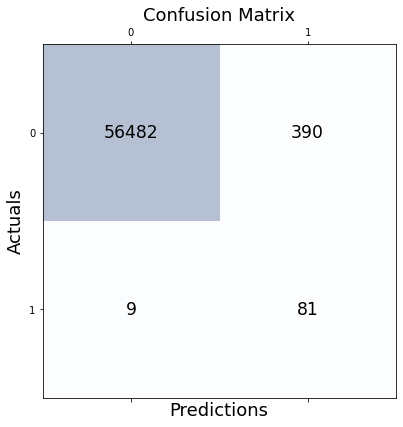

In [89]:
plot_cmx(y_true_T6, y_pred_T6)

In [90]:
accuracy_T6, recall_T6, f1_score_T6, presicion_T6 = report(test_loader_T6)

accuracy: 0.9929953302201467
recall score: 0.9465712477141652
f1 score: 0.6426251932826077
presicion: 0.5859076024398002


# ***!!!!!!!!!!!!!!!!!!!!!!------( Threshold = 1 )------!!!!!!!!!!!!!!!!!!!!!!***

In [98]:
percent = 1
X_train_res_T1, y_train_res_T1 = percentage_of_adding_fraud_data(X_train_r, y_train_r, percent)

In [99]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 321
Before OverSampling, counts of label '0': 181955

After OverSampling, the shape of train_X: (218346, 29)
After OverSampling, the shape of train_y: (218346,) 

After OverSampling, counts of label '1': 36391
After OverSampling, counts of label '0': 181955


In [100]:
#Datalodaer, Threshold 1
train_loader_T1, validation_loader_T1, test_loader_T1 = loader(X_train_res_T1, y_train_res_T1, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [101]:
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)

#### Loss Function

In [102]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [103]:
autoencoder_optimizer = optim.SGD(autoencoder.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training: Using Balanced Data

In [104]:
loss_train_list_T1, loss_validation_list_T1,train_accuracy_list_T1, validation_accuracy_list_T1= training_balanced_data(train_loader_T1, validation_loader_T1, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 93.71it/s, curr_loss_validation={1.7834050224015587}]


At Epoch 1/100:  Train Loss= 13.104374264963768 , Train Accuracy= 53.909 %
At Epoch 1/100: validation Loss= 1.7834050224015587 , validation Accuracy= 97.143 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 95.05it/s, curr_loss_validation={1.4777896576806118}]


At Epoch 2/100:  Train Loss= 12.634559155688844 , Train Accuracy= 92.296 %
At Epoch 2/100: validation Loss= 1.4777896576806118 , validation Accuracy= 98.786 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 102.54it/s, curr_loss_validation={1.4020585684399856}]


At Epoch 3/100:  Train Loss= 12.279086090194728 , Train Accuracy= 92.948 %
At Epoch 3/100: validation Loss= 1.4020585684399856 , validation Accuracy= 98.773 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 96.21it/s, curr_loss_validation={1.386309894291978}]


At Epoch 4/100:  Train Loss= 12.256383124450483 , Train Accuracy= 93.031 %
At Epoch 4/100: validation Loss= 1.386309894291978 , validation Accuracy= 98.769 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 95.52it/s, curr_loss_validation={1.3792312302087482}]


At Epoch 5/100:  Train Loss= 12.245247492876635 , Train Accuracy= 93.084 %
At Epoch 5/100: validation Loss= 1.3792312302087482 , validation Accuracy= 98.710 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 91.17it/s, curr_loss_validation={1.3749330271231501}]


At Epoch 6/100:  Train Loss= 12.246768922742941 , Train Accuracy= 93.100 %
At Epoch 6/100: validation Loss= 1.3749330271231501 , validation Accuracy= 98.644 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 93.35it/s, curr_loss_validation={1.3699364387675335}]


At Epoch 7/100:  Train Loss= 12.247192184850451 , Train Accuracy= 93.181 %
At Epoch 7/100: validation Loss= 1.3699364387675335 , validation Accuracy= 98.567 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 93.00it/s, curr_loss_validation={1.3664782619790028}]


At Epoch 8/100:  Train Loss= 12.223973090801836 , Train Accuracy= 93.152 %
At Epoch 8/100: validation Loss= 1.3664782619790028 , validation Accuracy= 98.514 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 90.52it/s, curr_loss_validation={1.3640209287405014}]


At Epoch 9/100:  Train Loss= 12.22338061670495 , Train Accuracy= 93.226 %
At Epoch 9/100: validation Loss= 1.3640209287405014 , validation Accuracy= 98.429 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 104.50it/s, curr_loss_validation={1.3612136072234104}]


At Epoch 10/100:  Train Loss= 12.223708084034174 , Train Accuracy= 93.173 %
At Epoch 10/100: validation Loss= 1.3612136072234104 , validation Accuracy= 98.407 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 92.44it/s, curr_loss_validation={1.3589328456866114}]


At Epoch 11/100:  Train Loss= 12.212654480234992 , Train Accuracy= 93.182 %
At Epoch 11/100: validation Loss= 1.3589328456866114 , validation Accuracy= 98.354 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 95.07it/s, curr_loss_validation={1.3560929329771745}] 


At Epoch 12/100:  Train Loss= 12.210098980286173 , Train Accuracy= 93.232 %
At Epoch 12/100: validation Loss= 1.3560929329771745 , validation Accuracy= 98.363 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 96.21it/s, curr_loss_validation={1.352555469462746}]


At Epoch 13/100:  Train Loss= 12.209347900095253 , Train Accuracy= 93.174 %
At Epoch 13/100: validation Loss= 1.352555469462746 , validation Accuracy= 98.429 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 89.74it/s, curr_loss_validation={1.3483424469044334}]


At Epoch 14/100:  Train Loss= 12.197895675946697 , Train Accuracy= 93.219 %
At Epoch 14/100: validation Loss= 1.3483424469044334 , validation Accuracy= 98.455 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 98.14it/s, curr_loss_validation={1.3456503576353978}] 


At Epoch 15/100:  Train Loss= 12.212013665691043 , Train Accuracy= 93.250 %
At Epoch 15/100: validation Loss= 1.3456503576353978 , validation Accuracy= 98.350 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 90.94it/s, curr_loss_validation={1.3404336101130436}]


At Epoch 16/100:  Train Loss= 12.201197901510525 , Train Accuracy= 93.265 %
At Epoch 16/100: validation Loss= 1.3404336101130436 , validation Accuracy= 98.571 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 94.86it/s, curr_loss_validation={1.3377426988200138}]


At Epoch 17/100:  Train Loss= 12.19174880447262 , Train Accuracy= 93.287 %
At Epoch 17/100: validation Loss= 1.3377426988200138 , validation Accuracy= 98.598 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 82.54it/s, curr_loss_validation={1.3353375031759864}]


At Epoch 18/100:  Train Loss= 12.186308050469865 , Train Accuracy= 93.326 %
At Epoch 18/100: validation Loss= 1.3353375031759864 , validation Accuracy= 98.596 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 113.61it/s, curr_loss_validation={1.3333843687647267}]


At Epoch 19/100:  Train Loss= 12.186493475708184 , Train Accuracy= 93.299 %
At Epoch 19/100: validation Loss= 1.3333843687647267 , validation Accuracy= 98.600 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 94.26it/s, curr_loss_validation={1.330833077430725}]


At Epoch 20/100:  Train Loss= 12.18932534285393 , Train Accuracy= 93.326 %
At Epoch 20/100: validation Loss= 1.330833077430725 , validation Accuracy= 98.659 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 92.80it/s, curr_loss_validation={1.328827396819466}]


At Epoch 21/100:  Train Loss= 12.188765076868224 , Train Accuracy= 93.357 %
At Epoch 21/100: validation Loss= 1.328827396819466 , validation Accuracy= 98.659 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 92.35it/s, curr_loss_validation={1.3262178835115934}]


At Epoch 22/100:  Train Loss= 12.179036172257224 , Train Accuracy= 93.362 %
At Epoch 22/100: validation Loss= 1.3262178835115934 , validation Accuracy= 98.729 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 94.95it/s, curr_loss_validation={1.324433816106696}]


At Epoch 23/100:  Train Loss= 12.187122725969092 , Train Accuracy= 93.390 %
At Epoch 23/100: validation Loss= 1.324433816106696 , validation Accuracy= 98.664 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 91.07it/s, curr_loss_validation={1.3208669690709365}]


At Epoch 24/100:  Train Loss= 12.186313941019174 , Train Accuracy= 93.406 %
At Epoch 24/100: validation Loss= 1.3208669690709365 , validation Accuracy= 98.765 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 92.41it/s, curr_loss_validation={1.3180887855981525}]


At Epoch 25/100:  Train Loss= 12.18460518799268 , Train Accuracy= 93.394 %
At Epoch 25/100: validation Loss= 1.3180887855981525 , validation Accuracy= 98.767 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 127.93it/s, curr_loss_validation={1.3145850708610134}]


At Epoch 26/100:  Train Loss= 12.179487334444653 , Train Accuracy= 93.398 %
At Epoch 26/100: validation Loss= 1.3145850708610134 , validation Accuracy= 98.756 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 110.90it/s, curr_loss_validation={1.3097858342685198}]


At Epoch 27/100:  Train Loss= 12.181114985483285 , Train Accuracy= 93.464 %
At Epoch 27/100: validation Loss= 1.3097858342685198 , validation Accuracy= 98.760 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 99.40it/s, curr_loss_validation={1.3024535477161407}] 


At Epoch 28/100:  Train Loss= 12.163505505690662 , Train Accuracy= 93.442 %
At Epoch 28/100: validation Loss= 1.3024535477161407 , validation Accuracy= 98.791 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 113.58it/s, curr_loss_validation={1.2967647510139566}]


At Epoch 29/100:  Train Loss= 12.158670177569697 , Train Accuracy= 93.498 %
At Epoch 29/100: validation Loss= 1.2967647510139566 , validation Accuracy= 98.738 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 105.40it/s, curr_loss_validation={1.2925984090880345}]


At Epoch 30/100:  Train Loss= 12.156019491654448 , Train Accuracy= 93.468 %
At Epoch 30/100: validation Loss= 1.2925984090880345 , validation Accuracy= 98.718 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 122.26it/s, curr_loss_validation={1.2892132542635266}]


At Epoch 31/100:  Train Loss= 12.16240120562533 , Train Accuracy= 93.522 %
At Epoch 31/100: validation Loss= 1.2892132542635266 , validation Accuracy= 98.756 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 108.95it/s, curr_loss_validation={1.287186239110796}]


At Epoch 32/100:  Train Loss= 12.156601787202638 , Train Accuracy= 93.521 %
At Epoch 32/100: validation Loss= 1.287186239110796 , validation Accuracy= 98.800 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 92.36it/s, curr_loss_validation={1.2853173629233712}]


At Epoch 33/100:  Train Loss= 12.171073745856372 , Train Accuracy= 93.541 %
At Epoch 33/100: validation Loss= 1.2853173629233712 , validation Accuracy= 98.848 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 104.32it/s, curr_loss_validation={1.2833684918127561}]


At Epoch 34/100:  Train Loss= 12.147586346850954 , Train Accuracy= 93.545 %
At Epoch 34/100: validation Loss= 1.2833684918127561 , validation Accuracy= 98.848 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 108.09it/s, curr_loss_validation={1.2829902540696294}]


At Epoch 35/100:  Train Loss= 12.145834952641948 , Train Accuracy= 93.600 %
At Epoch 35/100: validation Loss= 1.2829902540696294 , validation Accuracy= 98.775 %



validation - epoch : 36: 100%|██████████| 152/152 [00:01<00:00, 85.42it/s, curr_loss_validation={1.2811418222753626}]


At Epoch 36/100:  Train Loss= 12.147020066196875 , Train Accuracy= 93.661 %
At Epoch 36/100: validation Loss= 1.2811418222753626 , validation Accuracy= 98.907 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 121.36it/s, curr_loss_validation={1.280213702666132}]


At Epoch 37/100:  Train Loss= 12.147388950014822 , Train Accuracy= 93.681 %
At Epoch 37/100: validation Loss= 1.280213702666132 , validation Accuracy= 98.811 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 109.27it/s, curr_loss_validation={1.2792159440486055}]


At Epoch 38/100:  Train Loss= 12.148065608258696 , Train Accuracy= 93.669 %
At Epoch 38/100: validation Loss= 1.2792159440486055 , validation Accuracy= 98.854 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 96.17it/s, curr_loss_validation={1.278442402419291}] 


At Epoch 39/100:  Train Loss= 12.161498472757355 , Train Accuracy= 93.734 %
At Epoch 39/100: validation Loss= 1.278442402419291 , validation Accuracy= 98.837 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 112.50it/s, curr_loss_validation={1.2775230697895352}]


At Epoch 40/100:  Train Loss= 12.150663262733321 , Train Accuracy= 93.765 %
At Epoch 40/100: validation Loss= 1.2775230697895352 , validation Accuracy= 98.830 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 120.93it/s, curr_loss_validation={1.2776011330516714}]


At Epoch 41/100:  Train Loss= 12.140636788561475 , Train Accuracy= 93.781 %
At Epoch 41/100: validation Loss= 1.2776011330516714 , validation Accuracy= 98.767 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 113.84it/s, curr_loss_validation={1.2761531801600206}]


At Epoch 42/100:  Train Loss= 12.13926933506961 , Train Accuracy= 93.845 %
At Epoch 42/100: validation Loss= 1.2761531801600206 , validation Accuracy= 98.839 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 123.32it/s, curr_loss_validation={1.275061633241804}]


At Epoch 43/100:  Train Loss= 12.138089513857244 , Train Accuracy= 93.879 %
At Epoch 43/100: validation Loss= 1.275061633241804 , validation Accuracy= 98.824 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 120.38it/s, curr_loss_validation={1.274642982765248}]


At Epoch 44/100:  Train Loss= 12.135953808145036 , Train Accuracy= 93.903 %
At Epoch 44/100: validation Loss= 1.274642982765248 , validation Accuracy= 98.835 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 94.77it/s, curr_loss_validation={1.2737575424344916}]


At Epoch 45/100:  Train Loss= 12.153267320730345 , Train Accuracy= 93.932 %
At Epoch 45/100: validation Loss= 1.2737575424344916 , validation Accuracy= 98.782 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 118.70it/s, curr_loss_validation={1.2720136524815309}]


At Epoch 46/100:  Train Loss= 12.1531459782426 , Train Accuracy= 93.921 %
At Epoch 46/100: validation Loss= 1.2720136524815309 , validation Accuracy= 98.887 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 123.54it/s, curr_loss_validation={1.2729745742521787}]


At Epoch 47/100:  Train Loss= 12.138071223185129 , Train Accuracy= 94.004 %
At Epoch 47/100: validation Loss= 1.2729745742521787 , validation Accuracy= 98.688 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 123.45it/s, curr_loss_validation={1.2721274087303562}]


At Epoch 48/100:  Train Loss= 12.13809163723589 , Train Accuracy= 94.000 %
At Epoch 48/100: validation Loss= 1.2721274087303562 , validation Accuracy= 98.723 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 122.21it/s, curr_loss_validation={1.2716143343009447}]


At Epoch 49/100:  Train Loss= 12.14552165805999 , Train Accuracy= 94.004 %
At Epoch 49/100: validation Loss= 1.2716143343009447 , validation Accuracy= 98.721 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 95.51it/s, curr_loss_validation={1.2697365511404841}] 


At Epoch 50/100:  Train Loss= 12.150612090329165 , Train Accuracy= 94.064 %
At Epoch 50/100: validation Loss= 1.2697365511404841 , validation Accuracy= 98.830 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 93.48it/s, curr_loss_validation={1.2696661635449058}]


At Epoch 51/100:  Train Loss= 12.13666099142989 , Train Accuracy= 94.086 %
At Epoch 51/100: validation Loss= 1.2696661635449058 , validation Accuracy= 98.729 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 119.21it/s, curr_loss_validation={1.269454782338519}]


At Epoch 52/100:  Train Loss= 12.14286708399727 , Train Accuracy= 94.094 %
At Epoch 52/100: validation Loss= 1.269454782338519 , validation Accuracy= 98.668 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 122.56it/s, curr_loss_validation={1.267411334734214}]


At Epoch 53/100:  Train Loss= 12.131253587355134 , Train Accuracy= 94.135 %
At Epoch 53/100: validation Loss= 1.267411334734214 , validation Accuracy= 98.883 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 103.12it/s, curr_loss_validation={1.2667214494002492}]


At Epoch 54/100:  Train Loss= 12.141638153663774 , Train Accuracy= 94.143 %
At Epoch 54/100: validation Loss= 1.2667214494002492 , validation Accuracy= 98.797 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 123.21it/s, curr_loss_validation={1.265800527836147}]


At Epoch 55/100:  Train Loss= 12.129935747316289 , Train Accuracy= 94.198 %
At Epoch 55/100: validation Loss= 1.265800527836147 , validation Accuracy= 98.734 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 103.97it/s, curr_loss_validation={1.2651794035183757}]


At Epoch 56/100:  Train Loss= 12.13213387431187 , Train Accuracy= 94.202 %
At Epoch 56/100: validation Loss= 1.2651794035183757 , validation Accuracy= 98.681 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 121.02it/s, curr_loss_validation={1.2608231596256558}]


At Epoch 57/100:  Train Loss= 12.127200707375906 , Train Accuracy= 94.191 %
At Epoch 57/100: validation Loss= 1.2608231596256558 , validation Accuracy= 99.002 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 95.04it/s, curr_loss_validation={1.2602020439348722}]


At Epoch 58/100:  Train Loss= 12.130957647446156 , Train Accuracy= 94.237 %
At Epoch 58/100: validation Loss= 1.2602020439348722 , validation Accuracy= 98.927 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 114.32it/s, curr_loss_validation={1.2604140176584846}]


At Epoch 59/100:  Train Loss= 12.13691091616032 , Train Accuracy= 94.281 %
At Epoch 59/100: validation Loss= 1.2604140176584846 , validation Accuracy= 98.569 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 116.88it/s, curr_loss_validation={1.2552296315368854}]


At Epoch 60/100:  Train Loss= 12.12405689190797 , Train Accuracy= 94.282 %
At Epoch 60/100: validation Loss= 1.2552296315368854 , validation Accuracy= 98.905 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 125.82it/s, curr_loss_validation={1.2536844752336804}]


At Epoch 61/100:  Train Loss= 12.121642908115167 , Train Accuracy= 94.238 %
At Epoch 61/100: validation Loss= 1.2536844752336804 , validation Accuracy= 98.758 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 125.36it/s, curr_loss_validation={1.2519105425790737}]


At Epoch 62/100:  Train Loss= 12.12637896357101 , Train Accuracy= 94.265 %
At Epoch 62/100: validation Loss= 1.2519105425790737 , validation Accuracy= 98.670 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 117.11it/s, curr_loss_validation={1.2489093506806774}]


At Epoch 63/100:  Train Loss= 12.123510639592883 , Train Accuracy= 94.339 %
At Epoch 63/100: validation Loss= 1.2489093506806774 , validation Accuracy= 98.738 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 109.41it/s, curr_loss_validation={1.2454498014167736}]


At Epoch 64/100:  Train Loss= 12.118681706156723 , Train Accuracy= 94.322 %
At Epoch 64/100: validation Loss= 1.2454498014167736 , validation Accuracy= 98.775 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 114.46it/s, curr_loss_validation={1.2431928338973146}]


At Epoch 65/100:  Train Loss= 12.121789731932235 , Train Accuracy= 94.307 %
At Epoch 65/100: validation Loss= 1.2431928338973146 , validation Accuracy= 98.775 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 114.46it/s, curr_loss_validation={1.2418835053318424}]


At Epoch 66/100:  Train Loss= 12.130042262289434 , Train Accuracy= 94.325 %
At Epoch 66/100: validation Loss= 1.2418835053318424 , validation Accuracy= 98.736 %



validation - epoch : 67: 100%|██████████| 152/152 [00:01<00:00, 120.08it/s, curr_loss_validation={1.2390495221081532}]


At Epoch 67/100:  Train Loss= 12.12266016713477 , Train Accuracy= 94.361 %
At Epoch 67/100: validation Loss= 1.2390495221081532 , validation Accuracy= 98.890 %



validation - epoch : 68: 100%|██████████| 152/152 [00:01<00:00, 109.23it/s, curr_loss_validation={1.2377114472420592}]


At Epoch 68/100:  Train Loss= 12.127275096132886 , Train Accuracy= 94.378 %
At Epoch 68/100: validation Loss= 1.2377114472420592 , validation Accuracy= 98.854 %



validation - epoch : 69: 100%|██████████| 152/152 [00:01<00:00, 91.86it/s, curr_loss_validation={1.2372724374658184}]


At Epoch 69/100:  Train Loss= 12.116197952917812 , Train Accuracy= 94.348 %
At Epoch 69/100: validation Loss= 1.2372724374658184 , validation Accuracy= 98.791 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 127.30it/s, curr_loss_validation={1.2358934730291367}]


At Epoch 70/100:  Train Loss= 12.111218954821592 , Train Accuracy= 94.416 %
At Epoch 70/100: validation Loss= 1.2358934730291367 , validation Accuracy= 98.861 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 126.43it/s, curr_loss_validation={1.2376647246511359}]


At Epoch 71/100:  Train Loss= 12.118320598633717 , Train Accuracy= 94.426 %
At Epoch 71/100: validation Loss= 1.2376647246511359 , validation Accuracy= 98.554 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 126.18it/s, curr_loss_validation={1.2349319920728081}]


At Epoch 72/100:  Train Loss= 12.122104482949272 , Train Accuracy= 94.384 %
At Epoch 72/100: validation Loss= 1.2349319920728081 , validation Accuracy= 98.852 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 121.22it/s, curr_loss_validation={1.2353801284181445}]


At Epoch 73/100:  Train Loss= 12.122392252995901 , Train Accuracy= 94.418 %
At Epoch 73/100: validation Loss= 1.2353801284181445 , validation Accuracy= 98.631 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 128.13it/s, curr_loss_validation={1.2326999212566174}]


At Epoch 74/100:  Train Loss= 12.114891119804572 , Train Accuracy= 94.431 %
At Epoch 74/100: validation Loss= 1.2326999212566174 , validation Accuracy= 98.859 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 125.87it/s, curr_loss_validation={1.2346018964522762}]


At Epoch 75/100:  Train Loss= 12.113317057171214 , Train Accuracy= 94.451 %
At Epoch 75/100: validation Loss= 1.2346018964522762 , validation Accuracy= 98.694 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 127.19it/s, curr_loss_validation={1.2341859513207485}]


At Epoch 76/100:  Train Loss= 12.115475752797511 , Train Accuracy= 94.439 %
At Epoch 76/100: validation Loss= 1.2341859513207485 , validation Accuracy= 98.565 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 91.91it/s, curr_loss_validation={1.2321854072966074}]


At Epoch 77/100:  Train Loss= 12.118508901391822 , Train Accuracy= 94.515 %
At Epoch 77/100: validation Loss= 1.2321854072966074 , validation Accuracy= 98.696 %



validation - epoch : 78: 100%|██████████| 152/152 [00:01<00:00, 108.44it/s, curr_loss_validation={1.2303495642385984}]


At Epoch 78/100:  Train Loss= 12.108013648766859 , Train Accuracy= 94.487 %
At Epoch 78/100: validation Loss= 1.2303495642385984 , validation Accuracy= 98.683 %



validation - epoch : 79: 100%|██████████| 152/152 [00:01<00:00, 124.37it/s, curr_loss_validation={1.226503726291029}]


At Epoch 79/100:  Train Loss= 12.111141103103487 , Train Accuracy= 94.495 %
At Epoch 79/100: validation Loss= 1.226503726291029 , validation Accuracy= 98.907 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 96.87it/s, curr_loss_validation={1.2261803738380734}] 


At Epoch 80/100:  Train Loss= 12.10287169225919 , Train Accuracy= 94.478 %
At Epoch 80/100: validation Loss= 1.2261803738380734 , validation Accuracy= 98.705 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 95.75it/s, curr_loss_validation={1.2218924858852436}]


At Epoch 81/100:  Train Loss= 12.123321808150415 , Train Accuracy= 94.557 %
At Epoch 81/100: validation Loss= 1.2218924858852436 , validation Accuracy= 99.017 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 93.77it/s, curr_loss_validation={1.2234232347262533}]


At Epoch 82/100:  Train Loss= 12.11185350135288 , Train Accuracy= 94.536 %
At Epoch 82/100: validation Loss= 1.2234232347262533 , validation Accuracy= 98.721 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 118.29it/s, curr_loss_validation={1.2220965357203233}]


At Epoch 83/100:  Train Loss= 12.105093797309788 , Train Accuracy= 94.506 %
At Epoch 83/100: validation Loss= 1.2220965357203233 , validation Accuracy= 98.815 %



validation - epoch : 84: 100%|██████████| 152/152 [00:01<00:00, 124.78it/s, curr_loss_validation={1.2257527254129712}]


At Epoch 84/100:  Train Loss= 12.114476267941898 , Train Accuracy= 94.510 %
At Epoch 84/100: validation Loss= 1.2257527254129712 , validation Accuracy= 98.299 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 128.95it/s, curr_loss_validation={1.2224669209436367}]


At Epoch 85/100:  Train Loss= 12.109945524269117 , Train Accuracy= 94.504 %
At Epoch 85/100: validation Loss= 1.2224669209436367 , validation Accuracy= 98.563 %



validation - epoch : 86: 100%|██████████| 152/152 [00:01<00:00, 95.61it/s, curr_loss_validation={1.2216505921984975}]


At Epoch 86/100:  Train Loss= 12.102118886086654 , Train Accuracy= 94.536 %
At Epoch 86/100: validation Loss= 1.2216505921984975 , validation Accuracy= 98.589 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 129.33it/s, curr_loss_validation={1.2175157791689823}]


At Epoch 87/100:  Train Loss= 12.097388767135595 , Train Accuracy= 94.565 %
At Epoch 87/100: validation Loss= 1.2175157791689823 , validation Accuracy= 99.021 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 124.14it/s, curr_loss_validation={1.220635534901368}]


At Epoch 88/100:  Train Loss= 12.109525681327556 , Train Accuracy= 94.548 %
At Epoch 88/100: validation Loss= 1.220635534901368 , validation Accuracy= 98.567 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 117.43it/s, curr_loss_validation={1.218475779420451}]


At Epoch 89/100:  Train Loss= 12.100513581585451 , Train Accuracy= 94.562 %
At Epoch 89/100: validation Loss= 1.218475779420451 , validation Accuracy= 98.786 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 123.32it/s, curr_loss_validation={1.2169954772842557}]


At Epoch 90/100:  Train Loss= 12.098716714629624 , Train Accuracy= 94.587 %
At Epoch 90/100: validation Loss= 1.2169954772842557 , validation Accuracy= 98.874 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 128.55it/s, curr_loss_validation={1.2185130197750895}]


At Epoch 91/100:  Train Loss= 12.096135316217161 , Train Accuracy= 94.529 %
At Epoch 91/100: validation Loss= 1.2185130197750895 , validation Accuracy= 98.683 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 134.31it/s, curr_loss_validation={1.219061597397453}]


At Epoch 92/100:  Train Loss= 12.104104006702856 , Train Accuracy= 94.585 %
At Epoch 92/100: validation Loss= 1.219061597397453 , validation Accuracy= 98.613 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 106.62it/s, curr_loss_validation={1.2198497311849343}]


At Epoch 93/100:  Train Loss= 12.10006390568452 , Train Accuracy= 94.565 %
At Epoch 93/100: validation Loss= 1.2198497311849343 , validation Accuracy= 98.451 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 127.91it/s, curr_loss_validation={1.2151946092122479}]


At Epoch 94/100:  Train Loss= 12.10129124721546 , Train Accuracy= 94.553 %
At Epoch 94/100: validation Loss= 1.2151946092122479 , validation Accuracy= 98.971 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 126.32it/s, curr_loss_validation={1.2180032408551167}]


At Epoch 95/100:  Train Loss= 12.095395176964498 , Train Accuracy= 94.571 %
At Epoch 95/100: validation Loss= 1.2180032408551167 , validation Accuracy= 98.609 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 134.68it/s, curr_loss_validation={1.2155624671201957}]


At Epoch 96/100:  Train Loss= 12.093464910689454 , Train Accuracy= 94.577 %
At Epoch 96/100: validation Loss= 1.2155624671201957 , validation Accuracy= 98.883 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 99.79it/s, curr_loss_validation={1.2155714435012717}] 


At Epoch 97/100:  Train Loss= 12.099225643635581 , Train Accuracy= 94.594 %
At Epoch 97/100: validation Loss= 1.2155714435012717 , validation Accuracy= 98.848 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 93.99it/s, curr_loss_validation={1.2165304626289166}]


At Epoch 98/100:  Train Loss= 12.092085304723737 , Train Accuracy= 94.574 %
At Epoch 98/100: validation Loss= 1.2165304626289166 , validation Accuracy= 98.639 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 97.46it/s, curr_loss_validation={1.220009249291922}]


At Epoch 99/100:  Train Loss= 12.090678001746314 , Train Accuracy= 94.632 %
At Epoch 99/100: validation Loss= 1.220009249291922 , validation Accuracy= 98.402 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 135.46it/s, curr_loss_validation={1.2149590842033688}]


At Epoch 100/100:  Train Loss= 12.118964873192928 , Train Accuracy= 94.621 %
At Epoch 100/100: validation Loss= 1.2149590842033688 , validation Accuracy= 98.826 %



##### Loss Plot

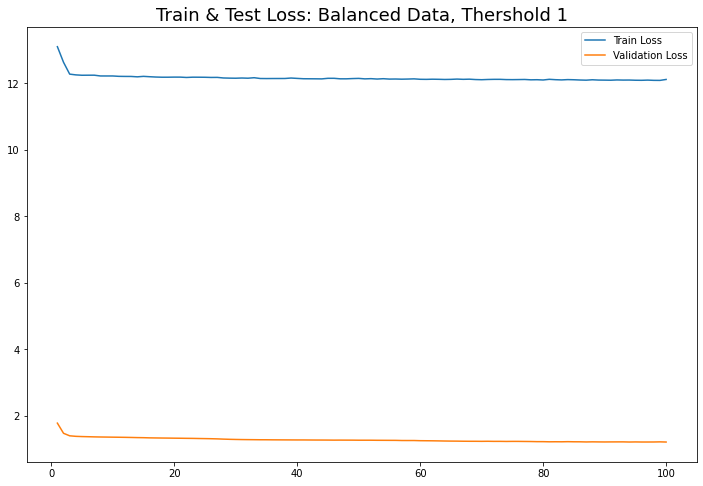

In [105]:
loss_plot(loss_train_list_T1, loss_validation_list_T1, 'Balanced Data', percent)

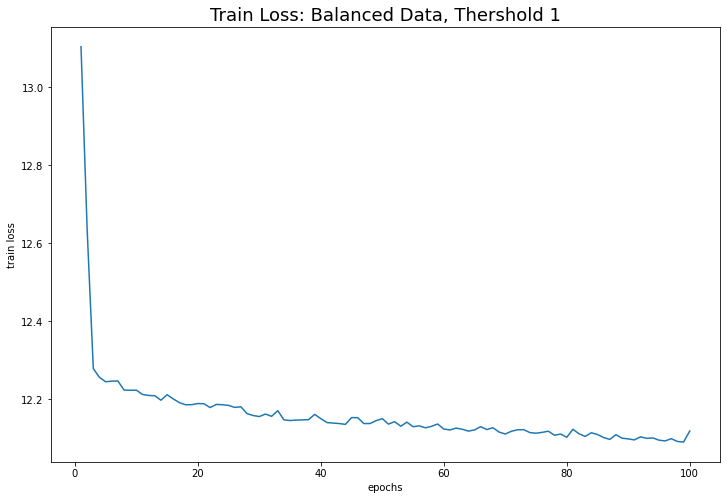

In [182]:
loss_plot_train(loss_train_list_T1, 'Balanced Data', percent)

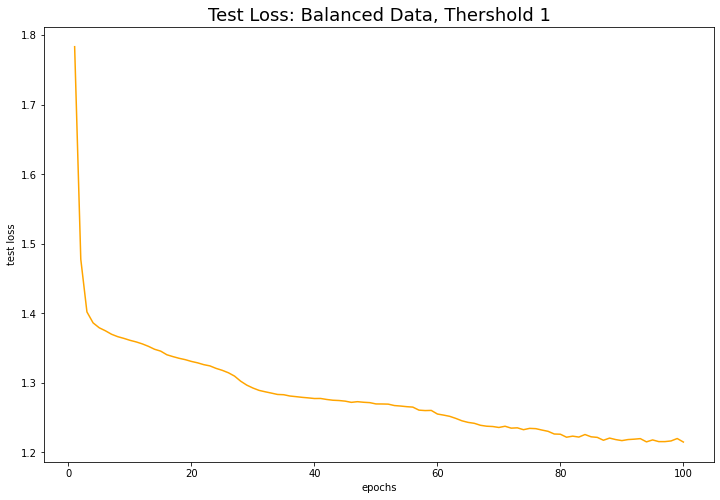

In [183]:
loss_plot_test(loss_validation_list_T1, 'Balanced Data', percent)

##### Accuracy Plot

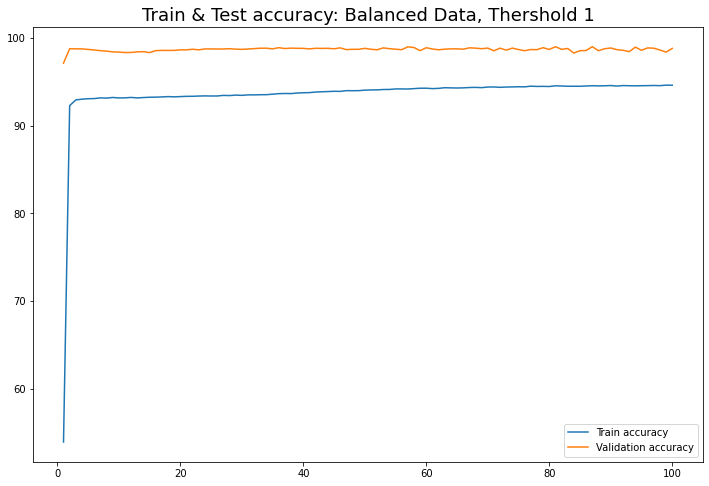

In [106]:
accuracy_plot(train_accuracy_list_T1, validation_accuracy_list_T1, 'Balanced Data', percent)

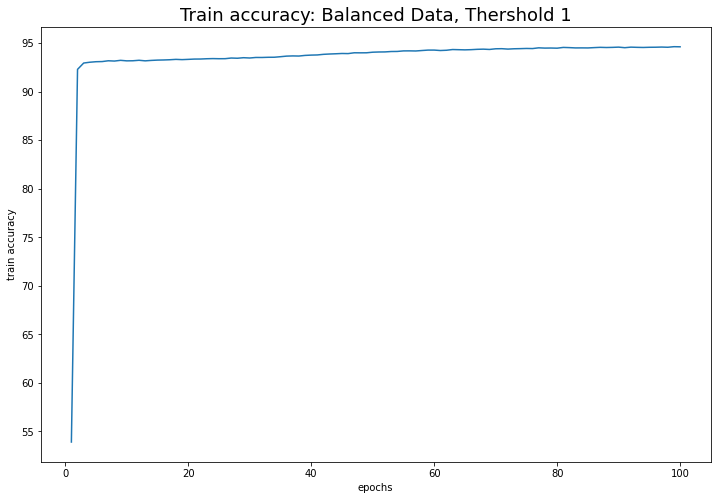

In [184]:
accuracy_plot_train(train_accuracy_list_T1, 'Balanced Data', percent)

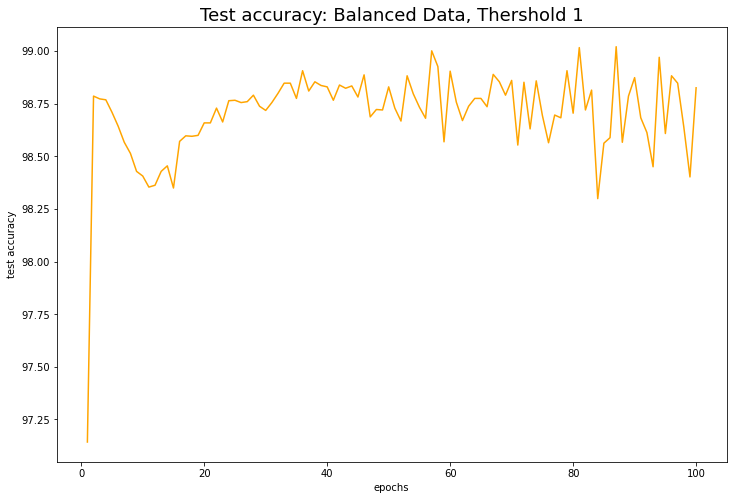

In [185]:
accuracy_plot_test(validation_accuracy_list_T1, 'Balanced Data', percent)

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [107]:
y_true_T1, y_pred_T1 = predict_list(test_loader_T1, autoencoder, classifier)

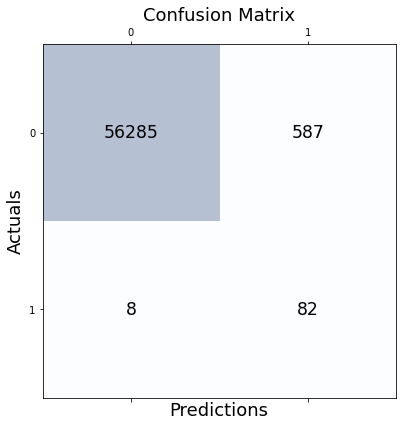

In [108]:
plot_cmx(y_true_T1, y_pred_T1)

In [109]:
accuracy_T1, recall_T1, f1_score_T1, presicion_T1 = report(test_loader_T1)

accuracy: 0.9895544398019732
recall score: 0.9503948437817478
f1 score: 0.6054079859489044
presicion: 0.561214443955243


#### plot accuracy and recall all threshold's result

In [110]:
p= [0.2, 0.3, 0.4, 0.5, 0.6, 1]
all_accuracy= np.array((accuracy_T2, accuracy_T3, accuracy_T4, accuracy_T5, accuracy_T6, accuracy_T1))
all_recall= np.array((recall_T2, recall_T3, recall_T4, recall_T5, recall_T6, recall_T1))

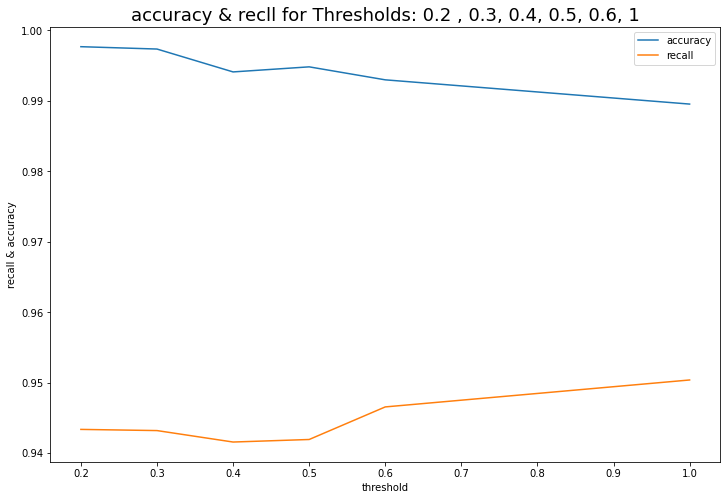

In [132]:
plt.figure(figsize=(12,8))
plt.plot(p, all_accuracy,label='accuracy')
plt.plot(p, all_recall,label='recall')
plt.title('accuracy & recll for Thresholds: 0.2 , 0.3, 0.4, 0.5, 0.6, 1', fontsize= '18')
plt.xlabel('threshold')
plt.ylabel('recall & accuracy')
plt.legend(loc=0)
plt.show()

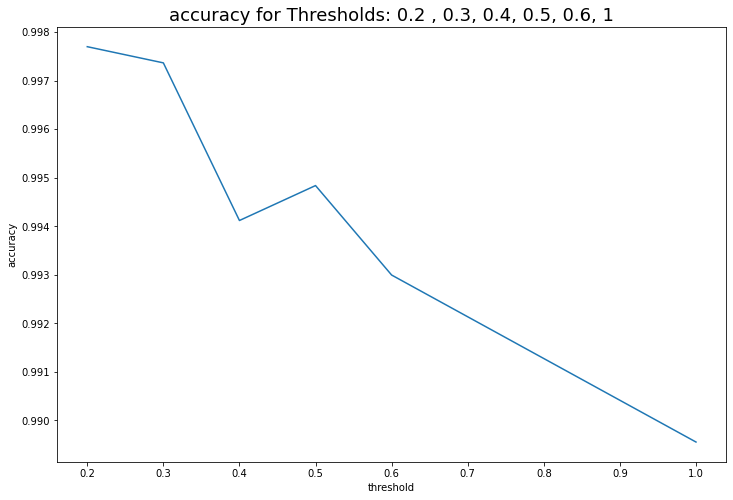

In [135]:
plt.figure(figsize=(12,8))
plt.plot(p, all_accuracy,label='accuracy')
# plt.plot(p, all_recall,label='recall')
plt.title('accuracy for Thresholds: 0.2 , 0.3, 0.4, 0.5, 0.6, 1', fontsize= '18')
plt.xlabel('threshold')
plt.ylabel('accuracy')
# plt.legend(loc=0)
plt.show()

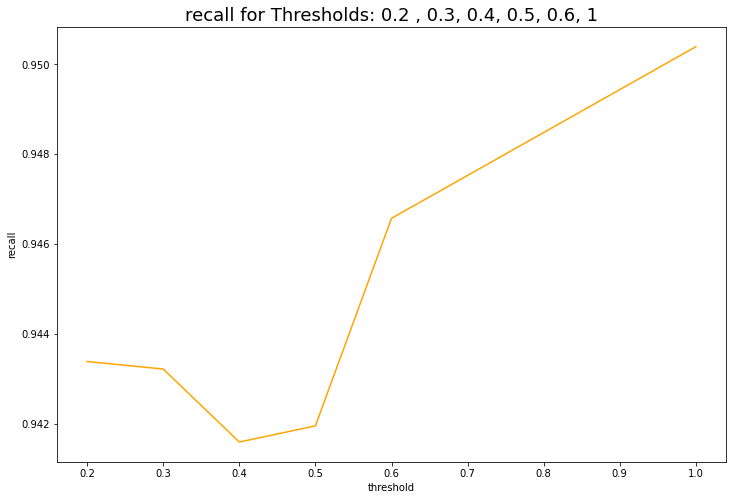

In [187]:
plt.figure(figsize=(12,8))
# plt.plot(p, all_accuracy,label='accuracy')
plt.plot(p, all_recall,label='recall', color= 'orange')
plt.title('recall for Thresholds: 0.2 , 0.3, 0.4, 0.5, 0.6, 1', fontsize= '18')
plt.xlabel('threshold')
plt.ylabel('recall')
# plt.legend(loc=0)
plt.show()

<hr/>
<hr/>

## Training: Using Unbalanced Data

In [111]:
train_loader_unblnc, validation_loader, test_loader= loader(X_train, y_train, X_val, y_val, X_test, y_test, BATCH_SIZE= 300 )

#### Model

In [112]:
autoencoder_unblnc = Autoencoder().to(device)
classifier_unblnc = Classifier().to(device)

#### Loss Function

In [113]:
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

#### Optimizer

In [114]:
autoencoder_unblnc_optimizer = optim.SGD(autoencoder_unblnc.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)
classifier_unblnc_optimizer = optim.SGD(classifier_unblnc.parameters(), lr=10e-4, momentum=0.9,weight_decay=4e-6)

### Training unbalanced data

In [115]:
def training_unbalanced_data(train_loader_unblnc, validation_loader, epochs):
    # autoencoder_unblnc.to(device)
    classifier_unblnc.to(device)

    loss_train_list_unblnc , loss_validation_list_unblnc = [] , []
    train_accuracy_list_unblnc, validation_accuracy_list_unblnc = [], []


    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    ###################################    Training     ##########################################
    for epoch in range(1, epochs+1):
        total_train, total_validation = 0 , 0
        correct_train, correct_validation = 0 , 0

        sum_of_loss_train = 0


        # autoencoder_unblnc.train()
        classifier_unblnc.train()
        # Loop for train batches
        loop_train = tqdm(enumerate(train_loader_unblnc, 1),total=len(train_loader_unblnc), desc="train")
        for i,(inputs, labels) in loop_train:
            
            inputs, labels = inputs.to(device), labels.to(device)

            # decoded = autoencoder_unblnc(inputs)
            outputs = classifier_unblnc(inputs)
            # loss_autoencoder = autoencoder_criterion(decoded, inputs)
            # loss_classifier = classifier_criterion(outputs, labels)
            # loss = loss_autoencoder + loss_classifier
            loss = classifier_criterion(outputs, labels)

            # autoencoder_unblnc_optimizer.zero_grad()
            classifier_unblnc_optimizer.zero_grad()

            loss.backward()
            # autoencoder_unblnc_optimizer.step()
            classifier_unblnc_optimizer.step()

            #calculate loss of train data
            sum_of_loss_train += loss.item()
            loop_train.set_description(f'Train - epoch : {epoch}')
            loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
            loop_train.refresh()

            #calculate accuracy of train data
            predictions_train = torch.max(outputs, 1)[1].to(device)
            correct_train += (predictions_train == labels).sum()
            total_train += len(labels)
            
        train_accuracy = correct_train * 100 / total_train   
        train_accuracy_list_unblnc.append(train_accuracy.cpu()) 
                    
        loss_train_list_unblnc.append((sum_of_loss_train/i))

        # autoencoder_unblnc.to(device)
        classifier_unblnc.to(device)
        ################################    Testing by validation data    ##############################################
        # autoencoder_unblnc.eval()
        classifier_unblnc.eval()

        with torch.no_grad():
        # Loop for validation batches
            loop_validation = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
            sum_of_loss_validation = 0
            for i,(inputs, labels) in loop_validation:
                inputs, labels = inputs.to(device), labels.to(device)
                
                labels_list.append(labels)
                # decoded = autoencoder_unblnc(inputs)
                outputs = classifier_unblnc(inputs)
                #calculate loss of validation data
                # loss_autoencoder = autoencoder_criterion(decoded, inputs)
                # loss_classifier = classifier_criterion(outputs, labels)
                loss = classifier_criterion(outputs, labels)
                # loss = loss_autoencoder + loss_classifier
                sum_of_loss_validation += loss.item()
                loop_validation.set_description(f'validation - epoch : {epoch}')
                loop_validation.set_postfix(curr_loss_validation = {sum_of_loss_validation/i})   
                loop_validation.refresh()
                #calculate accuracy of validation data
                predictions_validation = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions_validation)
                correct_validation += (predictions_validation == labels).sum()
                total_validation += len(labels)
                
            validation_accuracy = correct_validation * 100 / total_validation
            validation_accuracy_list_unblnc.append(validation_accuracy.cpu())             
            
            loss_validation_list_unblnc.append((sum_of_loss_validation/i))
                
            print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list_unblnc[-1]} , Train Accuracy= {train_accuracy:.3f} %')
            print(f'At Epoch {epoch}/{epochs}: validation Loss= {loss_validation_list_unblnc[-1]} , validation Accuracy= {validation_accuracy:.3f} %')
            print()
    return loss_train_list_unblnc, loss_validation_list_unblnc, train_accuracy_list_unblnc, validation_accuracy_list_unblnc

In [116]:
loss_train_list_unblnc, loss_validation_list_unblnc, train_accuracy_list_unblnc, validation_accuracy_list_unblnc= training_unbalanced_data(train_loader_unblnc, validation_loader, 100)

validation - epoch : 1: 100%|██████████| 152/152 [00:01<00:00, 100.00it/s, curr_loss_validation={0.3808823753344385}]


At Epoch 1/100:  Train Loss= 0.45562579752387183 , Train Accuracy= 99.823 %
At Epoch 1/100: validation Loss= 0.3808823753344385 , validation Accuracy= 99.822 %



validation - epoch : 2: 100%|██████████| 152/152 [00:01<00:00, 103.45it/s, curr_loss_validation={0.3462633565068245}]


At Epoch 2/100:  Train Loss= 0.3601292281558639 , Train Accuracy= 99.824 %
At Epoch 2/100: validation Loss= 0.3462633565068245 , validation Accuracy= 99.822 %



validation - epoch : 3: 100%|██████████| 152/152 [00:01<00:00, 99.89it/s, curr_loss_validation={0.33370050140901614}] 


At Epoch 3/100:  Train Loss= 0.3391379645388377 , Train Accuracy= 99.824 %
At Epoch 3/100: validation Loss= 0.33370050140901614 , validation Accuracy= 99.822 %



validation - epoch : 4: 100%|██████████| 152/152 [00:01<00:00, 99.23it/s, curr_loss_validation={0.32756496260040685}] 


At Epoch 4/100:  Train Loss= 0.3303117993238725 , Train Accuracy= 99.824 %
At Epoch 4/100: validation Loss= 0.32756496260040685 , validation Accuracy= 99.822 %



validation - epoch : 5: 100%|██████████| 152/152 [00:01<00:00, 122.09it/s, curr_loss_validation={0.3240867974726777}]


At Epoch 5/100:  Train Loss= 0.3256665825059539 , Train Accuracy= 99.824 %
At Epoch 5/100: validation Loss= 0.3240867974726777 , validation Accuracy= 99.822 %



validation - epoch : 6: 100%|██████████| 152/152 [00:01<00:00, 107.99it/s, curr_loss_validation={0.3219128109906849}]


At Epoch 6/100:  Train Loss= 0.3229081245433343 , Train Accuracy= 99.824 %
At Epoch 6/100: validation Loss= 0.3219128109906849 , validation Accuracy= 99.822 %



validation - epoch : 7: 100%|██████████| 152/152 [00:01<00:00, 88.78it/s, curr_loss_validation={0.3204661046988086}]


At Epoch 7/100:  Train Loss= 0.3211334550655202 , Train Accuracy= 99.824 %
At Epoch 7/100: validation Loss= 0.3204661046988086 , validation Accuracy= 99.822 %



validation - epoch : 8: 100%|██████████| 152/152 [00:01<00:00, 96.78it/s, curr_loss_validation={0.31944645568728447}]


At Epoch 8/100:  Train Loss= 0.31991314476257876 , Train Accuracy= 99.824 %
At Epoch 8/100: validation Loss= 0.31944645568728447 , validation Accuracy= 99.822 %



validation - epoch : 9: 100%|██████████| 152/152 [00:01<00:00, 98.53it/s, curr_loss_validation={0.31870601228193235}]


At Epoch 9/100:  Train Loss= 0.3190461768229541 , Train Accuracy= 99.824 %
At Epoch 9/100: validation Loss= 0.31870601228193235 , validation Accuracy= 99.822 %



validation - epoch : 10: 100%|██████████| 152/152 [00:01<00:00, 96.60it/s, curr_loss_validation={0.3181433246323937}]


At Epoch 10/100:  Train Loss= 0.3183963085083585 , Train Accuracy= 99.824 %
At Epoch 10/100: validation Loss= 0.3181433246323937 , validation Accuracy= 99.822 %



validation - epoch : 11: 100%|██████████| 152/152 [00:01<00:00, 121.81it/s, curr_loss_validation={0.31771218070858404}]


At Epoch 11/100:  Train Loss= 0.3179028077345145 , Train Accuracy= 99.824 %
At Epoch 11/100: validation Loss= 0.31771218070858404 , validation Accuracy= 99.822 %



validation - epoch : 12: 100%|██████████| 152/152 [00:01<00:00, 119.13it/s, curr_loss_validation={0.317369043630989}]


At Epoch 12/100:  Train Loss= 0.317516628750845 , Train Accuracy= 99.824 %
At Epoch 12/100: validation Loss= 0.317369043630989 , validation Accuracy= 99.822 %



validation - epoch : 13: 100%|██████████| 152/152 [00:01<00:00, 137.39it/s, curr_loss_validation={0.31708991939299985}]


At Epoch 13/100:  Train Loss= 0.31720821603544447 , Train Accuracy= 99.824 %
At Epoch 13/100: validation Loss= 0.31708991939299985 , validation Accuracy= 99.822 %



validation - epoch : 14: 100%|██████████| 152/152 [00:01<00:00, 96.69it/s, curr_loss_validation={0.3168633356690407}]


At Epoch 14/100:  Train Loss= 0.3169576401675218 , Train Accuracy= 99.824 %
At Epoch 14/100: validation Loss= 0.3168633356690407 , validation Accuracy= 99.822 %



validation - epoch : 15: 100%|██████████| 152/152 [00:01<00:00, 96.81it/s, curr_loss_validation={0.3166751287093288}]


At Epoch 15/100:  Train Loss= 0.3167509508662318 , Train Accuracy= 99.824 %
At Epoch 15/100: validation Loss= 0.3166751287093288 , validation Accuracy= 99.822 %



validation - epoch : 16: 100%|██████████| 152/152 [00:01<00:00, 110.79it/s, curr_loss_validation={0.3165169017095315}]


At Epoch 16/100:  Train Loss= 0.3165782591033923 , Train Accuracy= 99.824 %
At Epoch 16/100: validation Loss= 0.3165169017095315 , validation Accuracy= 99.822 %



validation - epoch : 17: 100%|██████████| 152/152 [00:01<00:00, 129.91it/s, curr_loss_validation={0.31638751963251516}]


At Epoch 17/100:  Train Loss= 0.3164323104153338 , Train Accuracy= 99.824 %
At Epoch 17/100: validation Loss= 0.31638751963251516 , validation Accuracy= 99.822 %



validation - epoch : 18: 100%|██████████| 152/152 [00:01<00:00, 99.99it/s, curr_loss_validation={0.3162671702080651}]


At Epoch 18/100:  Train Loss= 0.31630770700346483 , Train Accuracy= 99.824 %
At Epoch 18/100: validation Loss= 0.3162671702080651 , validation Accuracy= 99.822 %



validation - epoch : 19: 100%|██████████| 152/152 [00:01<00:00, 136.34it/s, curr_loss_validation={0.31616740869848353}]


At Epoch 19/100:  Train Loss= 0.31620038045864357 , Train Accuracy= 99.824 %
At Epoch 19/100: validation Loss= 0.31616740869848353 , validation Accuracy= 99.822 %



validation - epoch : 20: 100%|██████████| 152/152 [00:01<00:00, 125.05it/s, curr_loss_validation={0.3160829698961032}]


At Epoch 20/100:  Train Loss= 0.31610716443116726 , Train Accuracy= 99.824 %
At Epoch 20/100: validation Loss= 0.3160829698961032 , validation Accuracy= 99.822 %



validation - epoch : 21: 100%|██████████| 152/152 [00:01<00:00, 103.78it/s, curr_loss_validation={0.31600409687349673}]


At Epoch 21/100:  Train Loss= 0.3160256297376595 , Train Accuracy= 99.824 %
At Epoch 21/100: validation Loss= 0.31600409687349673 , validation Accuracy= 99.822 %



validation - epoch : 22: 100%|██████████| 152/152 [00:01<00:00, 98.23it/s, curr_loss_validation={0.3159366644134647}]


At Epoch 22/100:  Train Loss= 0.31595767475664616 , Train Accuracy= 99.824 %
At Epoch 22/100: validation Loss= 0.3159366644134647 , validation Accuracy= 99.822 %



validation - epoch : 23: 100%|██████████| 152/152 [00:01<00:00, 118.63it/s, curr_loss_validation={0.3158767617454654}]


At Epoch 23/100:  Train Loss= 0.3158902454337007 , Train Accuracy= 99.824 %
At Epoch 23/100: validation Loss= 0.3158767617454654 , validation Accuracy= 99.822 %



validation - epoch : 24: 100%|██████████| 152/152 [00:01<00:00, 111.73it/s, curr_loss_validation={0.31582328539929894}]


At Epoch 24/100:  Train Loss= 0.31583360425735774 , Train Accuracy= 99.824 %
At Epoch 24/100: validation Loss= 0.31582328539929894 , validation Accuracy= 99.822 %



validation - epoch : 25: 100%|██████████| 152/152 [00:01<00:00, 101.85it/s, curr_loss_validation={0.31577780783960696}]


At Epoch 25/100:  Train Loss= 0.31578675726134525 , Train Accuracy= 99.824 %
At Epoch 25/100: validation Loss= 0.31577780783960696 , validation Accuracy= 99.822 %



validation - epoch : 26: 100%|██████████| 152/152 [00:01<00:00, 98.13it/s, curr_loss_validation={0.3157345670226373}]


At Epoch 26/100:  Train Loss= 0.3157373146693173 , Train Accuracy= 99.824 %
At Epoch 26/100: validation Loss= 0.3157345670226373 , validation Accuracy= 99.822 %



validation - epoch : 27: 100%|██████████| 152/152 [00:01<00:00, 135.30it/s, curr_loss_validation={0.31569291259113114}]


At Epoch 27/100:  Train Loss= 0.3156961505546382 , Train Accuracy= 99.824 %
At Epoch 27/100: validation Loss= 0.31569291259113114 , validation Accuracy= 99.822 %



validation - epoch : 28: 100%|██████████| 152/152 [00:01<00:00, 95.19it/s, curr_loss_validation={0.3156573554795039}]


At Epoch 28/100:  Train Loss= 0.3156588256457134 , Train Accuracy= 99.824 %
At Epoch 28/100: validation Loss= 0.3156573554795039 , validation Accuracy= 99.822 %



validation - epoch : 29: 100%|██████████| 152/152 [00:01<00:00, 113.53it/s, curr_loss_validation={0.31562747688669907}]


At Epoch 29/100:  Train Loss= 0.3156248605074851 , Train Accuracy= 99.824 %
At Epoch 29/100: validation Loss= 0.31562747688669907 , validation Accuracy= 99.822 %



validation - epoch : 30: 100%|██████████| 152/152 [00:01<00:00, 93.79it/s, curr_loss_validation={0.3156003606946845}]


At Epoch 30/100:  Train Loss= 0.3155938578083327 , Train Accuracy= 99.824 %
At Epoch 30/100: validation Loss= 0.3156003606946845 , validation Accuracy= 99.822 %



validation - epoch : 31: 100%|██████████| 152/152 [00:01<00:00, 106.93it/s, curr_loss_validation={0.31556812869875056}]


At Epoch 31/100:  Train Loss= 0.3155654470779394 , Train Accuracy= 99.824 %
At Epoch 31/100: validation Loss= 0.31556812869875056 , validation Accuracy= 99.822 %



validation - epoch : 32: 100%|██████████| 152/152 [00:01<00:00, 102.67it/s, curr_loss_validation={0.3155431121979889}]


At Epoch 32/100:  Train Loss= 0.31554320910455363 , Train Accuracy= 99.824 %
At Epoch 32/100: validation Loss= 0.3155431121979889 , validation Accuracy= 99.822 %



validation - epoch : 33: 100%|██████████| 152/152 [00:01<00:00, 104.73it/s, curr_loss_validation={0.31552761440214355}]


At Epoch 33/100:  Train Loss= 0.31551532025792095 , Train Accuracy= 99.824 %
At Epoch 33/100: validation Loss= 0.31552761440214355 , validation Accuracy= 99.822 %



validation - epoch : 34: 100%|██████████| 152/152 [00:01<00:00, 119.93it/s, curr_loss_validation={0.315498720462385}]


At Epoch 34/100:  Train Loss= 0.3154931252234076 , Train Accuracy= 99.824 %
At Epoch 34/100: validation Loss= 0.315498720462385 , validation Accuracy= 99.822 %



validation - epoch : 35: 100%|██████████| 152/152 [00:01<00:00, 121.62it/s, curr_loss_validation={0.31548147138796356}]


At Epoch 35/100:  Train Loss= 0.31547257804164763 , Train Accuracy= 99.824 %
At Epoch 35/100: validation Loss= 0.31548147138796356 , validation Accuracy= 99.822 %



validation - epoch : 36: 100%|██████████| 152/152 [00:00<00:00, 153.74it/s, curr_loss_validation={0.31546058133244514}]


At Epoch 36/100:  Train Loss= 0.31545350881979656 , Train Accuracy= 99.824 %
At Epoch 36/100: validation Loss= 0.31546058133244514 , validation Accuracy= 99.822 %



validation - epoch : 37: 100%|██████████| 152/152 [00:01<00:00, 117.87it/s, curr_loss_validation={0.3154460066243222}]


At Epoch 37/100:  Train Loss= 0.3154357801632662 , Train Accuracy= 99.824 %
At Epoch 37/100: validation Loss= 0.3154460066243222 , validation Accuracy= 99.822 %



validation - epoch : 38: 100%|██████████| 152/152 [00:01<00:00, 107.34it/s, curr_loss_validation={0.31543006198970897}]


At Epoch 38/100:  Train Loss= 0.31541924938363464 , Train Accuracy= 99.824 %
At Epoch 38/100: validation Loss= 0.31543006198970897 , validation Accuracy= 99.822 %



validation - epoch : 39: 100%|██████████| 152/152 [00:01<00:00, 120.30it/s, curr_loss_validation={0.3154151533779345}]


At Epoch 39/100:  Train Loss= 0.31540767843589973 , Train Accuracy= 99.824 %
At Epoch 39/100: validation Loss= 0.3154151533779345 , validation Accuracy= 99.822 %



validation - epoch : 40: 100%|██████████| 152/152 [00:01<00:00, 125.34it/s, curr_loss_validation={0.3153986713211787}]


At Epoch 40/100:  Train Loss= 0.31539325151396425 , Train Accuracy= 99.824 %
At Epoch 40/100: validation Loss= 0.3153986713211787 , validation Accuracy= 99.822 %



validation - epoch : 41: 100%|██████████| 152/152 [00:01<00:00, 104.17it/s, curr_loss_validation={0.31538557555330426}]


At Epoch 41/100:  Train Loss= 0.31537586092752845 , Train Accuracy= 99.824 %
At Epoch 41/100: validation Loss= 0.31538557555330426 , validation Accuracy= 99.822 %



validation - epoch : 42: 100%|██████████| 152/152 [00:01<00:00, 125.79it/s, curr_loss_validation={0.31537328248745516}]


At Epoch 42/100:  Train Loss= 0.31536317293189076 , Train Accuracy= 99.824 %
At Epoch 42/100: validation Loss= 0.31537328248745516 , validation Accuracy= 99.822 %



validation - epoch : 43: 100%|██████████| 152/152 [00:01<00:00, 134.91it/s, curr_loss_validation={0.3153642431685799}]


At Epoch 43/100:  Train Loss= 0.31535123381763697 , Train Accuracy= 99.824 %
At Epoch 43/100: validation Loss= 0.3153642431685799 , validation Accuracy= 99.822 %



validation - epoch : 44: 100%|██████████| 152/152 [00:01<00:00, 86.72it/s, curr_loss_validation={0.31535334551804944}]


At Epoch 44/100:  Train Loss= 0.31534000461626993 , Train Accuracy= 99.824 %
At Epoch 44/100: validation Loss= 0.31535334551804944 , validation Accuracy= 99.822 %



validation - epoch : 45: 100%|██████████| 152/152 [00:01<00:00, 133.91it/s, curr_loss_validation={0.3153405313036944}]


At Epoch 45/100:  Train Loss= 0.31533711756530564 , Train Accuracy= 99.824 %
At Epoch 45/100: validation Loss= 0.3153405313036944 , validation Accuracy= 99.822 %



validation - epoch : 46: 100%|██████████| 152/152 [00:01<00:00, 113.21it/s, curr_loss_validation={0.3153308271185348}]


At Epoch 46/100:  Train Loss= 0.31531941243692446 , Train Accuracy= 99.824 %
At Epoch 46/100: validation Loss= 0.3153308271185348 , validation Accuracy= 99.822 %



validation - epoch : 47: 100%|██████████| 152/152 [00:01<00:00, 97.70it/s, curr_loss_validation={0.31532162290654686}]


At Epoch 47/100:  Train Loss= 0.3153099494152947 , Train Accuracy= 99.824 %
At Epoch 47/100: validation Loss= 0.31532162290654686 , validation Accuracy= 99.822 %



validation - epoch : 48: 100%|██████████| 152/152 [00:01<00:00, 103.45it/s, curr_loss_validation={0.31531292396156413}]


At Epoch 48/100:  Train Loss= 0.3153009940625021 , Train Accuracy= 99.824 %
At Epoch 48/100: validation Loss= 0.31531292396156413 , validation Accuracy= 99.822 %



validation - epoch : 49: 100%|██████████| 152/152 [00:01<00:00, 116.82it/s, curr_loss_validation={0.3153071960336284}]


At Epoch 49/100:  Train Loss= 0.3152925204485655 , Train Accuracy= 99.824 %
At Epoch 49/100: validation Loss= 0.3153071960336284 , validation Accuracy= 99.822 %



validation - epoch : 50: 100%|██████████| 152/152 [00:01<00:00, 144.32it/s, curr_loss_validation={0.3152968226686904}]


At Epoch 50/100:  Train Loss= 0.31528832797745343 , Train Accuracy= 99.824 %
At Epoch 50/100: validation Loss= 0.3152968226686904 , validation Accuracy= 99.822 %



validation - epoch : 51: 100%|██████████| 152/152 [00:01<00:00, 135.08it/s, curr_loss_validation={0.31528937051955025}]


At Epoch 51/100:  Train Loss= 0.315280674809688 , Train Accuracy= 99.824 %
At Epoch 51/100: validation Loss= 0.31528937051955025 , validation Accuracy= 99.822 %



validation - epoch : 52: 100%|██████████| 152/152 [00:01<00:00, 125.91it/s, curr_loss_validation={0.315282301487107}]


At Epoch 52/100:  Train Loss= 0.3152695605531335 , Train Accuracy= 99.824 %
At Epoch 52/100: validation Loss= 0.315282301487107 , validation Accuracy= 99.822 %



validation - epoch : 53: 100%|██████████| 152/152 [00:01<00:00, 116.97it/s, curr_loss_validation={0.3152780685769884}]


At Epoch 53/100:  Train Loss= 0.31526263822850426 , Train Accuracy= 99.824 %
At Epoch 53/100: validation Loss= 0.3152780685769884 , validation Accuracy= 99.822 %



validation - epoch : 54: 100%|██████████| 152/152 [00:01<00:00, 140.48it/s, curr_loss_validation={0.31526912121396317}]


At Epoch 54/100:  Train Loss= 0.3152560413766064 , Train Accuracy= 99.824 %
At Epoch 54/100: validation Loss= 0.31526912121396317 , validation Accuracy= 99.822 %



validation - epoch : 55: 100%|██████████| 152/152 [00:01<00:00, 132.69it/s, curr_loss_validation={0.31526299232715055}]


At Epoch 55/100:  Train Loss= 0.3152497664682175 , Train Accuracy= 99.824 %
At Epoch 55/100: validation Loss= 0.31526299232715055 , validation Accuracy= 99.822 %



validation - epoch : 56: 100%|██████████| 152/152 [00:01<00:00, 112.10it/s, curr_loss_validation={0.31525713185730736}]


At Epoch 56/100:  Train Loss= 0.31524762869077294 , Train Accuracy= 99.824 %
At Epoch 56/100: validation Loss= 0.31525713185730736 , validation Accuracy= 99.822 %



validation - epoch : 57: 100%|██████████| 152/152 [00:01<00:00, 127.75it/s, curr_loss_validation={0.31525404731694023}]


At Epoch 57/100:  Train Loss= 0.3152380316567264 , Train Accuracy= 99.824 %
At Epoch 57/100: validation Loss= 0.31525404731694023 , validation Accuracy= 99.822 %



validation - epoch : 58: 100%|██████████| 152/152 [00:01<00:00, 120.89it/s, curr_loss_validation={0.3152461646026687}]


At Epoch 58/100:  Train Loss= 0.315232543715913 , Train Accuracy= 99.824 %
At Epoch 58/100: validation Loss= 0.3152461646026687 , validation Accuracy= 99.822 %



validation - epoch : 59: 100%|██████████| 152/152 [00:01<00:00, 149.63it/s, curr_loss_validation={0.31524356866353437}]


At Epoch 59/100:  Train Loss= 0.3152273079184325 , Train Accuracy= 99.824 %
At Epoch 59/100: validation Loss= 0.31524356866353437 , validation Accuracy= 99.822 %



validation - epoch : 60: 100%|██████████| 152/152 [00:01<00:00, 138.06it/s, curr_loss_validation={0.31523613768972847}]


At Epoch 60/100:  Train Loss= 0.3152222868643309 , Train Accuracy= 99.824 %
At Epoch 60/100: validation Loss= 0.31523613768972847 , validation Accuracy= 99.822 %



validation - epoch : 61: 100%|██████████| 152/152 [00:01<00:00, 112.66it/s, curr_loss_validation={0.31523141951153155}]


At Epoch 61/100:  Train Loss= 0.3152174774165216 , Train Accuracy= 99.824 %
At Epoch 61/100: validation Loss= 0.31523141951153155 , validation Accuracy= 99.822 %



validation - epoch : 62: 100%|██████████| 152/152 [00:01<00:00, 133.31it/s, curr_loss_validation={0.3152294274615614}]


At Epoch 62/100:  Train Loss= 0.3152128537430575 , Train Accuracy= 99.824 %
At Epoch 62/100: validation Loss= 0.3152294274615614 , validation Accuracy= 99.822 %



validation - epoch : 63: 100%|██████████| 152/152 [00:01<00:00, 117.91it/s, curr_loss_validation={0.31522256175154134}]


At Epoch 63/100:  Train Loss= 0.3152084165301762 , Train Accuracy= 99.824 %
At Epoch 63/100: validation Loss= 0.31522256175154134 , validation Accuracy= 99.822 %



validation - epoch : 64: 100%|██████████| 152/152 [00:01<00:00, 95.21it/s, curr_loss_validation={0.3152234430767988}]


At Epoch 64/100:  Train Loss= 0.31520416930710016 , Train Accuracy= 99.824 %
At Epoch 64/100: validation Loss= 0.3152234430767988 , validation Accuracy= 99.822 %



validation - epoch : 65: 100%|██████████| 152/152 [00:01<00:00, 143.52it/s, curr_loss_validation={0.3152169200934862}]


At Epoch 65/100:  Train Loss= 0.3152000814872353 , Train Accuracy= 99.824 %
At Epoch 65/100: validation Loss= 0.3152169200934862 , validation Accuracy= 99.822 %



validation - epoch : 66: 100%|██████████| 152/152 [00:01<00:00, 123.23it/s, curr_loss_validation={0.31521054063188403}]


At Epoch 66/100:  Train Loss= 0.3151961512079364 , Train Accuracy= 99.824 %
At Epoch 66/100: validation Loss= 0.31521054063188403 , validation Accuracy= 99.822 %



validation - epoch : 70: 100%|██████████| 152/152 [00:01<00:00, 127.73it/s, curr_loss_validation={0.31519648609192746}]


At Epoch 70/100:  Train Loss= 0.3151818203102601 , Train Accuracy= 99.824 %
At Epoch 70/100: validation Loss= 0.31519648609192746 , validation Accuracy= 99.822 %



validation - epoch : 71: 100%|██████████| 152/152 [00:01<00:00, 116.90it/s, curr_loss_validation={0.31519328900857974}]


At Epoch 71/100:  Train Loss= 0.31517856180863946 , Train Accuracy= 99.824 %
At Epoch 71/100: validation Loss= 0.31519328900857974 , validation Accuracy= 99.822 %



validation - epoch : 72: 100%|██████████| 152/152 [00:01<00:00, 122.46it/s, curr_loss_validation={0.31519272374479396}]


At Epoch 72/100:  Train Loss= 0.3151754190361029 , Train Accuracy= 99.824 %
At Epoch 72/100: validation Loss= 0.31519272374479396 , validation Accuracy= 99.822 %



validation - epoch : 73: 100%|██████████| 152/152 [00:01<00:00, 137.42it/s, curr_loss_validation={0.31518722090281936}]


At Epoch 73/100:  Train Loss= 0.3151762437957682 , Train Accuracy= 99.824 %
At Epoch 73/100: validation Loss= 0.31518722090281936 , validation Accuracy= 99.822 %



validation - epoch : 74: 100%|██████████| 152/152 [00:01<00:00, 126.00it/s, curr_loss_validation={0.3151843232151709}]


At Epoch 74/100:  Train Loss= 0.3151694487682299 , Train Accuracy= 99.824 %
At Epoch 74/100: validation Loss= 0.3151843232151709 , validation Accuracy= 99.822 %



validation - epoch : 75: 100%|██████████| 152/152 [00:01<00:00, 133.71it/s, curr_loss_validation={0.31518405381786196}]


At Epoch 75/100:  Train Loss= 0.3151665980878629 , Train Accuracy= 99.824 %
At Epoch 75/100: validation Loss= 0.31518405381786196 , validation Accuracy= 99.822 %



validation - epoch : 76: 100%|██████████| 152/152 [00:01<00:00, 125.63it/s, curr_loss_validation={0.3151788358625613}]


At Epoch 76/100:  Train Loss= 0.3151638574506107 , Train Accuracy= 99.824 %
At Epoch 76/100: validation Loss= 0.3151788358625613 , validation Accuracy= 99.822 %



validation - epoch : 77: 100%|██████████| 152/152 [00:01<00:00, 140.52it/s, curr_loss_validation={0.3151787439067113}]


At Epoch 77/100:  Train Loss= 0.3151650458182159 , Train Accuracy= 99.824 %
At Epoch 77/100: validation Loss= 0.3151787439067113 , validation Accuracy= 99.822 %



validation - epoch : 80: 100%|██████████| 152/152 [00:01<00:00, 115.75it/s, curr_loss_validation={0.3151714195938487}]


At Epoch 80/100:  Train Loss= 0.3151537351506321 , Train Accuracy= 99.824 %
At Epoch 80/100: validation Loss= 0.3151714195938487 , validation Accuracy= 99.822 %



validation - epoch : 81: 100%|██████████| 152/152 [00:01<00:00, 116.67it/s, curr_loss_validation={0.315166602205289}]


At Epoch 81/100:  Train Loss= 0.31515141703972693 , Train Accuracy= 99.824 %
At Epoch 81/100: validation Loss= 0.315166602205289 , validation Accuracy= 99.822 %



validation - epoch : 82: 100%|██████████| 152/152 [00:01<00:00, 92.65it/s, curr_loss_validation={0.3151668943464756}]


At Epoch 82/100:  Train Loss= 0.3151530119541444 , Train Accuracy= 99.824 %
At Epoch 82/100: validation Loss= 0.3151668943464756 , validation Accuracy= 99.822 %



validation - epoch : 83: 100%|██████████| 152/152 [00:01<00:00, 149.60it/s, curr_loss_validation={0.31516473230562714}]


At Epoch 83/100:  Train Loss= 0.3151469502696081 , Train Accuracy= 99.824 %
At Epoch 83/100: validation Loss= 0.31516473230562714 , validation Accuracy= 99.822 %



validation - epoch : 85: 100%|██████████| 152/152 [00:01<00:00, 89.64it/s, curr_loss_validation={0.31516057821480853}]


At Epoch 85/100:  Train Loss= 0.3151427452011328 , Train Accuracy= 99.824 %
At Epoch 85/100: validation Loss= 0.31516057821480853 , validation Accuracy= 99.822 %



validation - epoch : 86:  64%|██████▍   | 97/152 [00:00<00:00, 130.46it/s, curr_loss_validation={0.31492750799017294}]

At Epoch 86/100:  Train Loss= 0.31514073153467553 , Train Accuracy= 99.824 %
At Epoch 86/100: validation Loss= 0.31515609374956083 , validation Accuracy= 99.822 %



validation - epoch : 87: 100%|██████████| 152/152 [00:01<00:00, 97.51it/s, curr_loss_validation={0.31515416895088394}]


At Epoch 87/100:  Train Loss= 0.31513878477639273 , Train Accuracy= 99.824 %
At Epoch 87/100: validation Loss= 0.31515416895088394 , validation Accuracy= 99.822 %



validation - epoch : 88: 100%|██████████| 152/152 [00:01<00:00, 102.25it/s, curr_loss_validation={0.3151522927770489}]


At Epoch 88/100:  Train Loss= 0.3151407460927179 , Train Accuracy= 99.824 %
At Epoch 88/100: validation Loss= 0.3151522927770489 , validation Accuracy= 99.822 %



validation - epoch : 89: 100%|██████████| 152/152 [00:01<00:00, 135.83it/s, curr_loss_validation={0.31515048640339}]


At Epoch 89/100:  Train Loss= 0.31513503983028623 , Train Accuracy= 99.824 %
At Epoch 89/100: validation Loss= 0.31515048640339 , validation Accuracy= 99.822 %



validation - epoch : 90: 100%|██████████| 152/152 [00:01<00:00, 100.83it/s, curr_loss_validation={0.3151512649890624}]


At Epoch 90/100:  Train Loss= 0.31513326649407025 , Train Accuracy= 99.824 %
At Epoch 90/100: validation Loss= 0.3151512649890624 , validation Accuracy= 99.822 %



validation - epoch : 91: 100%|██████████| 152/152 [00:01<00:00, 141.17it/s, curr_loss_validation={0.31514701384462807}]


At Epoch 91/100:  Train Loss= 0.31513153261652116 , Train Accuracy= 99.824 %
At Epoch 91/100: validation Loss= 0.31514701384462807 , validation Accuracy= 99.822 %



validation - epoch : 92: 100%|██████████| 152/152 [00:01<00:00, 97.39it/s, curr_loss_validation={0.31514534844379677}]


At Epoch 92/100:  Train Loss= 0.3151336944122848 , Train Accuracy= 99.824 %
At Epoch 92/100: validation Loss= 0.31514534844379677 , validation Accuracy= 99.822 %



validation - epoch : 93: 100%|██████████| 152/152 [00:01<00:00, 121.97it/s, curr_loss_validation={0.31514373696164083}]


At Epoch 93/100:  Train Loss= 0.31513205043187265 , Train Accuracy= 99.824 %
At Epoch 93/100: validation Loss= 0.31514373696164083 , validation Accuracy= 99.822 %



validation - epoch : 94: 100%|██████████| 152/152 [00:01<00:00, 111.41it/s, curr_loss_validation={0.3151421670458819}]


At Epoch 94/100:  Train Loss= 0.3151266034692526 , Train Accuracy= 99.824 %
At Epoch 94/100: validation Loss= 0.3151421670458819 , validation Accuracy= 99.822 %



validation - epoch : 95: 100%|██████████| 152/152 [00:01<00:00, 117.04it/s, curr_loss_validation={0.31514061830545725}]


At Epoch 95/100:  Train Loss= 0.315125039386514 , Train Accuracy= 99.824 %
At Epoch 95/100: validation Loss= 0.31514061830545725 , validation Accuracy= 99.822 %



validation - epoch : 96: 100%|██████████| 152/152 [00:01<00:00, 89.53it/s, curr_loss_validation={0.31514163942713486}]


At Epoch 96/100:  Train Loss= 0.31512351108616904 , Train Accuracy= 99.824 %
At Epoch 96/100: validation Loss= 0.31514163942713486 , validation Accuracy= 99.822 %



validation - epoch : 97: 100%|██████████| 152/152 [00:01<00:00, 100.50it/s, curr_loss_validation={0.31514018087794904}]


At Epoch 97/100:  Train Loss= 0.31512202650896814 , Train Accuracy= 99.824 %
At Epoch 97/100: validation Loss= 0.31514018087794904 , validation Accuracy= 99.822 %



validation - epoch : 98: 100%|██████████| 152/152 [00:01<00:00, 138.57it/s, curr_loss_validation={0.31513622736460284}]


At Epoch 98/100:  Train Loss= 0.3151205856058943 , Train Accuracy= 99.824 %
At Epoch 98/100: validation Loss= 0.31513622736460284 , validation Accuracy= 99.822 %



validation - epoch : 99: 100%|██████████| 152/152 [00:01<00:00, 116.06it/s, curr_loss_validation={0.31513482743972226}]


At Epoch 99/100:  Train Loss= 0.31511916979951293 , Train Accuracy= 99.824 %
At Epoch 99/100: validation Loss= 0.31513482743972226 , validation Accuracy= 99.822 %



validation - epoch : 100: 100%|██████████| 152/152 [00:01<00:00, 124.50it/s, curr_loss_validation={0.31513347182618945}]


At Epoch 100/100:  Train Loss= 0.3151255126944498 , Train Accuracy= 99.824 %
At Epoch 100/100: validation Loss= 0.31513347182618945 , validation Accuracy= 99.822 %



#### Loss plot

In [124]:
#plot of loss
def loss_plot_unblnc(train_loss,val_loss,data_kind):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss')
    plt.title(f'Train & Test Loss: {data_kind}', fontsize= '18')
    plt.legend(loc=0)
    plt.show()

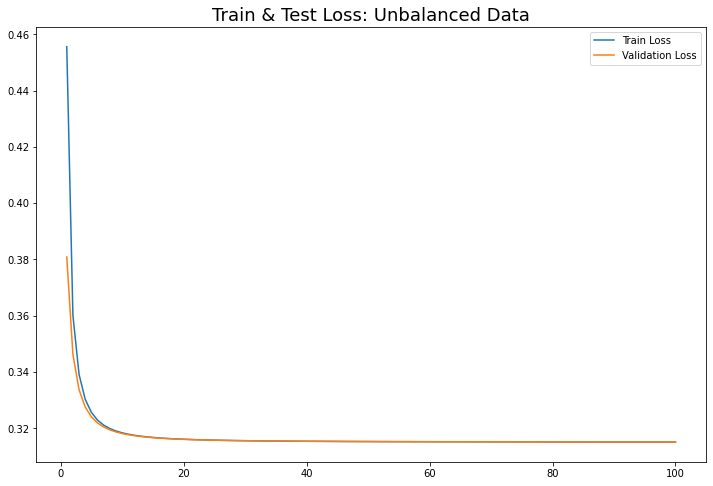

In [125]:
loss_plot_unblnc(loss_train_list_unblnc, loss_validation_list_unblnc, 'Unbalanced Data')


In [ ]:
# plot of loss
plt.figure(figsize=(12,8))
plt.plot(list(range(1,len(loss_train_list_unblnc)+1)), loss_train_list_unblnc,label='Train loss')
plt.title('Train loss: Unbalanced Data', fontsize= '18')
# plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.show()

In [ ]:
# plot of loss
plt.figure(figsize=(12,8))
plt.plot(list(range(1,len(loss_validation_list_unblnc)+1)), loss_validation_list_unblnc,label='Test loss',color= 'orange')
plt.title('Test loss: Unbalanced Data', fontsize= '18')
# plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.show()

#### Accuracy plot

In [126]:
# plot of accuracy
def accuracy_plot_unblnc(train_acc,val_acc,data_kind, percent):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
    plt.title(f'Train & Test accuracy: {data_kind}', fontsize= '18')
    plt.legend(loc=0)
    plt.show()

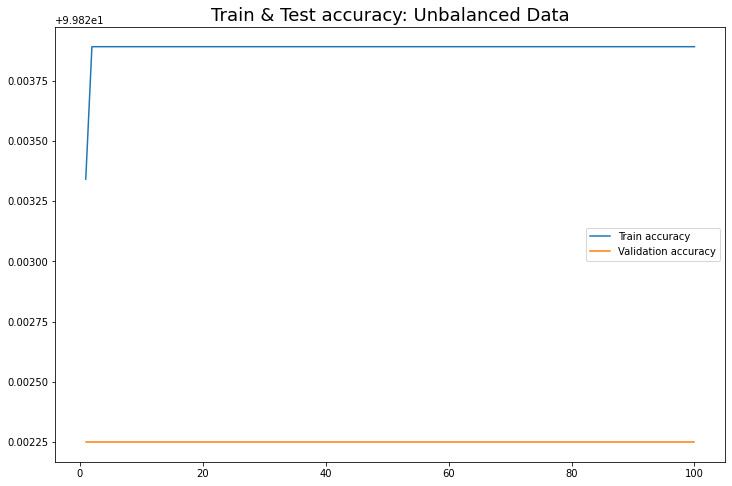

In [127]:
accuracy_plot_unblnc(train_accuracy_list_unblnc, validation_accuracy_list_unblnc, 'Unbalanced Data', percent)

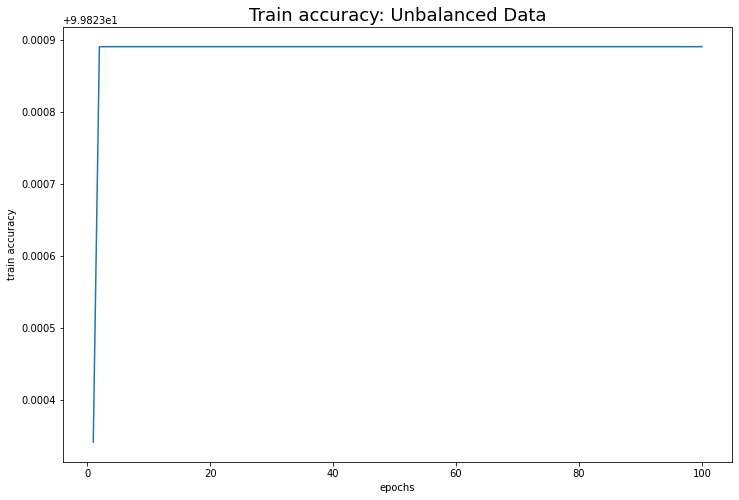

In [188]:
# plot of accuracy
plt.figure(figsize=(12,8))
plt.plot(list(range(1,len(train_accuracy_list_unblnc)+1)), train_accuracy_list_unblnc,label='Train accuracy')
# plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
plt.title('Train accuracy: Unbalanced Data', fontsize= '18')
# plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.show()

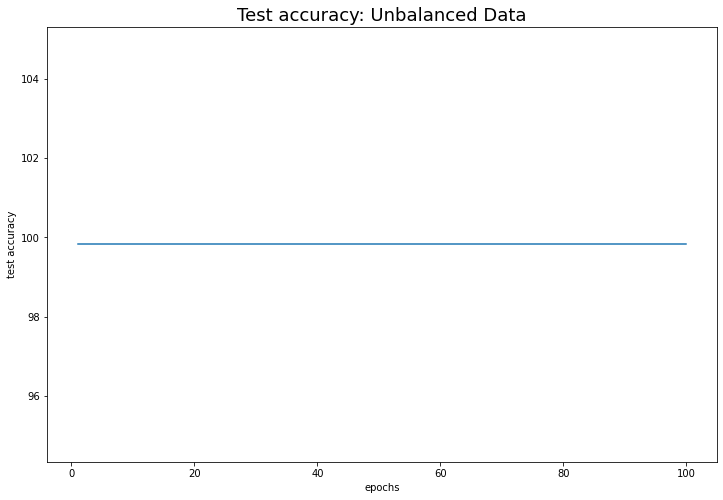

In [189]:
# plot of accuracy
plt.figure(figsize=(12,8))
plt.plot(list(range(1,len(validation_accuracy_list_unblnc)+1)), validation_accuracy_list_unblnc,label='Test accuracy', color= 'orange')
plt.title('Test accuracy: Unbalanced Data', fontsize= '18')
# plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.show()

#### Confusion matrix , Accuracy, recall score, F1 score, Presicion of Test data:

In [119]:
y_actual = []
y_pred = []
loss_test= []
with torch.no_grad():
    sum_of_loss= 0
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        #calculate outputs
        # decoded = autoencoder(images)
        outputs = classifier_unblnc(images)
        _, predicted = torch.max(outputs.data, 1)
        for a, b in zip(labels, predicted):
            y_actual.append(a.item())
            y_pred.append(b.item())
    
    
accuracy_unblnc = accuracy_score(y_actual, y_pred)
recall_sc_unblnc = recall_score(y_actual, y_pred, average="macro")
f1_sc_unblnc = f1_score(y_actual, y_pred, average="macro")
presicion_unblnc = precision_score(y_actual, y_pred, average="macro")

print("classification report for unbalanced data training:")
# accuracy
print("accuracy:", accuracy_unblnc)
# recall
print("recall score:", recall_sc_unblnc)
# f1_score
print("f1 score:", f1_sc_unblnc)
# precision
print("presicion:", presicion_unblnc)


classification report for unbalanced data training:
accuracy: 0.9984199992977775
recall score: 0.5
f1 score: 0.49960468752745224
presicion: 0.49920999964888874


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
y_true_unblnc, y_pred_unblnc = predict_list(test_loader, autoencoder, classifier)

In [119]:
plot_cmx(y_true_unblnc, y_pred_unblnc)